In [2]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
date = 'Дата замера'
hole = 'Скважина'
x1 = 'Способ эксплуатации'
x2 = 'Режим'
X = [x1, x2]
y1 = 'Рпр(ТМ)'
y2 = 'Рзаб(Рпр)'
y3 = 'Рзаб(Нд)'
y4 = 'Рзаб(иссл)'
Y = [y1, y2, y3, y4]
def load_some_data(path, separ = ':'):
    return pd.read_csv(path, sep=separ, parse_dates = [date], index_col = date,  encoding='cp1251')


In [3]:
df = load_some_data('data2.csv')

In [4]:
import datetime
#самые полные данные, где всегда есть режим и способ
#отбросили январь, ибо данные пропущены
filtered = df.loc[df.index.date >= datetime.date(2018,2,1)]
tmp = filtered[[hole,x1,x2]]
tmp[X] = tmp[X].isnull()
tmp = tmp.loc[(tmp[x1]) | (tmp[x2])]
nulls = tmp.groupby(hole).count().reset_index()[hole]
useful = filtered.loc[~filtered[hole].isin(nulls)]

D:\anaconda\envs\foo\lib\site-packages\pandas\core\frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [5]:
#выставление категорий
cats_x1 = useful[x1].astype('category').cat
useful[x1] = useful[x1].astype('category').cat.codes
cats_x2 = useful[x2].astype('category').cat
useful[x2] = useful[x2].astype('category').cat.codes

D:\anaconda\envs\foo\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
D:\anaconda\envs\foo\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [36]:
#useful.loc[useful[hole] == '1009-2']

In [6]:
spaces = useful.set_index([hole]).isnull()
spaces = spaces.groupby(spaces.index).sum()[Y]
not_spaces = useful.set_index([hole]).notna()
not_spaces = not_spaces.groupby(not_spaces.index).sum()[Y]
res = pd.DataFrame()
nsp = not_spaces.sum(axis = 1)
sp = spaces.sum(axis = 1)
#сформировали массив с отношением заполненных давлений
res['factor'] = nsp/(sp + nsp)
res.sort_values(by = ['factor'], inplace = True)
#итоговая выборка
targets = res.loc[res['factor'] > res['factor'].median()]
#232 скважина уникальная
targets  = targets.loc[targets.index != '232']
targets.loc[targets.index == '73']

factor
Скважина          
73        0.558908

In [7]:
from sklearn import preprocessing
from numpy import nan
#очистка выборосов и нормализация
def transform(d):
    df = d.copy()
    scaler = preprocessing.MinMaxScaler()
    for y in Y:
        #df[y].interpolate(inplace = True)
        down_quan = df[y].quantile(0.1)
        up_quan = df[y].quantile(0.9)
        df.loc[(df[y] < down_quan) | (df[y] > up_quan),y] = nan
        #df[y] = df[y].rolling(4).mean()
        
        #df[y].interpolate(inplace = True)
        df[y] =  scaler.fit_transform(df[[y]])
        #df[y] = df[y]/ df[y].max()
    return df

In [8]:
hole_232 = useful.loc[useful[hole] == '232']
final = transform(useful.loc[useful[hole].isin(targets.index)])

In [16]:
#загрузка в csv для инфлюкса
def load_before_influx(df, csv_name):
    for_influx = df.copy()
    for_influx.index.names=['date']
    for_influx.columns = ['hole','method','mode', 'P(TM)','P(rpr)', 'P(nd)', 'P(issl)']
    for_influx.to_csv(csv_name)

In [35]:
#load_before_influx(df, 'raw.csv')
#load_before_influx(useful, 'useful.csv')
load_before_influx(final, 'final.csv')
load_before_influx(hole_232, '232.csv')

In [9]:
import os
%matplotlib inline

def create_directory(dir):
    if not os.path.exists(dir):
        os.makedirs(dir)
    return dir
def draw_plot(name_hole, data_to_draw, what_to_do ='see', Y = Y):
    formatter = ticker.FormatStrFormatter('%.0f')
    fig, axes = plt.subplots(1,2)
    for y in Y:
        axes[0].plot(data_to_draw[y], label = y)
    axes[0].legend()
    axes[0].set_title('Измерения давлений')
    axes[0].set_xlabel(date, fontsize = 12)
    axes[0].set_ylabel('P', fontsize = 12)
    
    axes[1].plot(data_to_draw[x1], label = x1)
    axes[1].plot(data_to_draw[x2], label = x2)
    axes[1].set_title(x1 + 'and' + x2)
    axes[1].legend()
    axes[1].set_xlabel(date, fontsize = 12)
    axes[1].set_ylabel('№', fontsize = 12)
    axes[1].yaxis.set_major_formatter(formatter)
    fig.set_figwidth(15)
    fig.set_figheight(8)
    fig.suptitle(hole + ' ' + str(name_hole))
    plt.legend()
    if (what_to_do == 'save'):
        plt.savefig(create_directory('diagrams') + '/' + name_hole + '.png',
                    dpi = 100, format = 'png')
    else:
        plt.show()

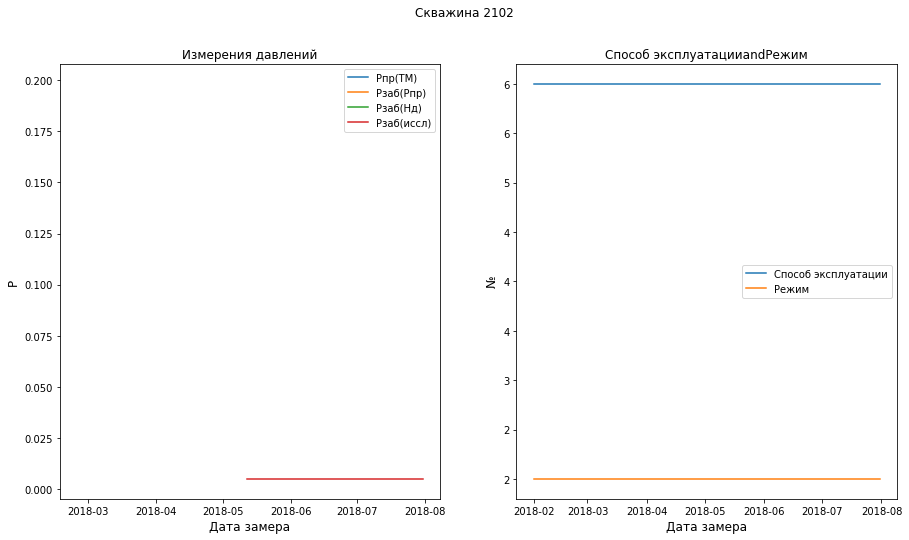

In [50]:
draw_plot(2102, final[final[hole] == '2102'])
#final[final[hole] == '2102']

D:\anaconda\envs\foo\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


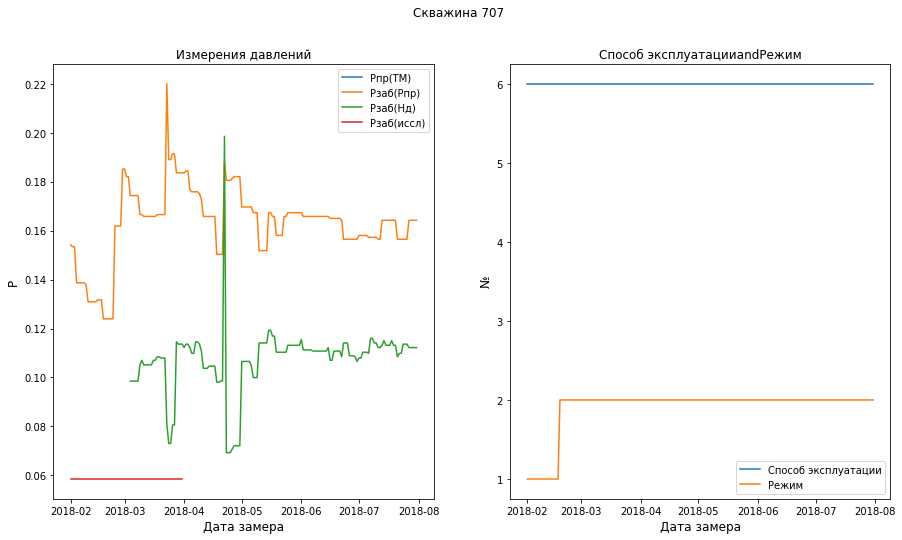

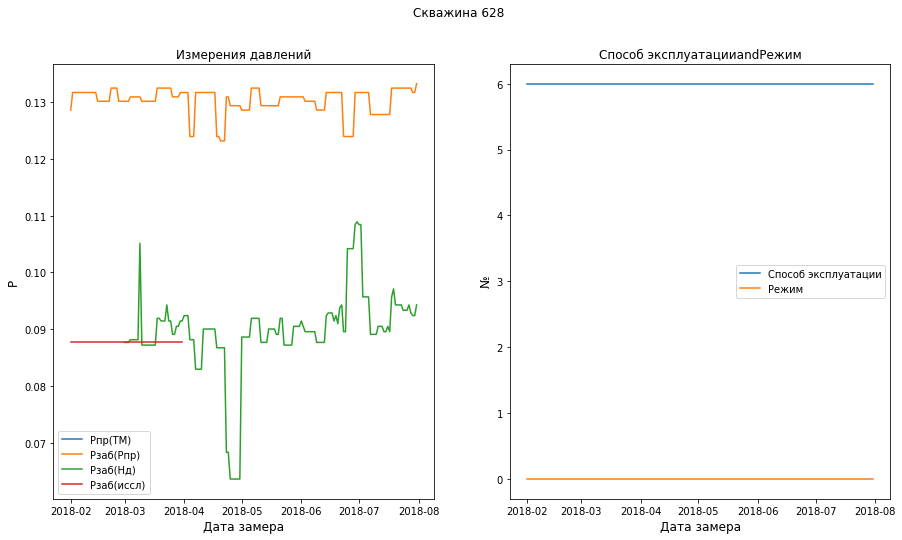

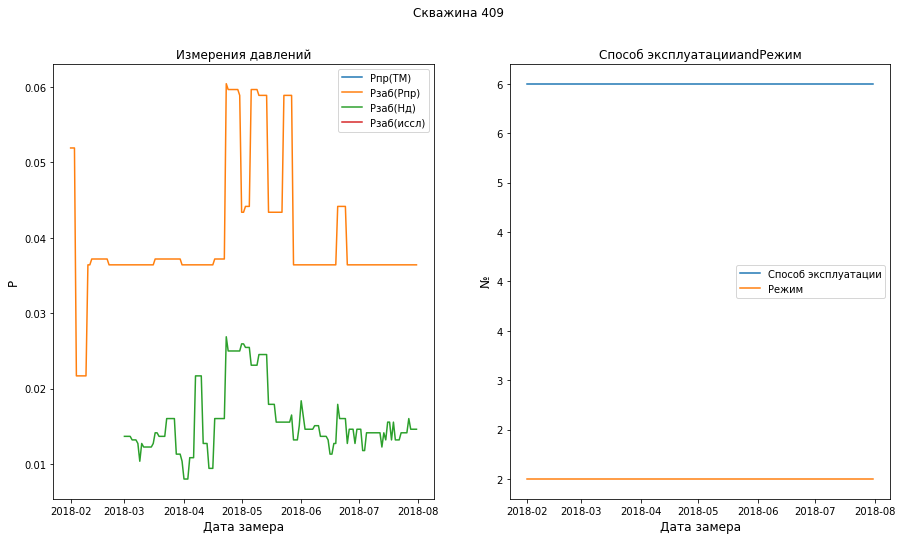

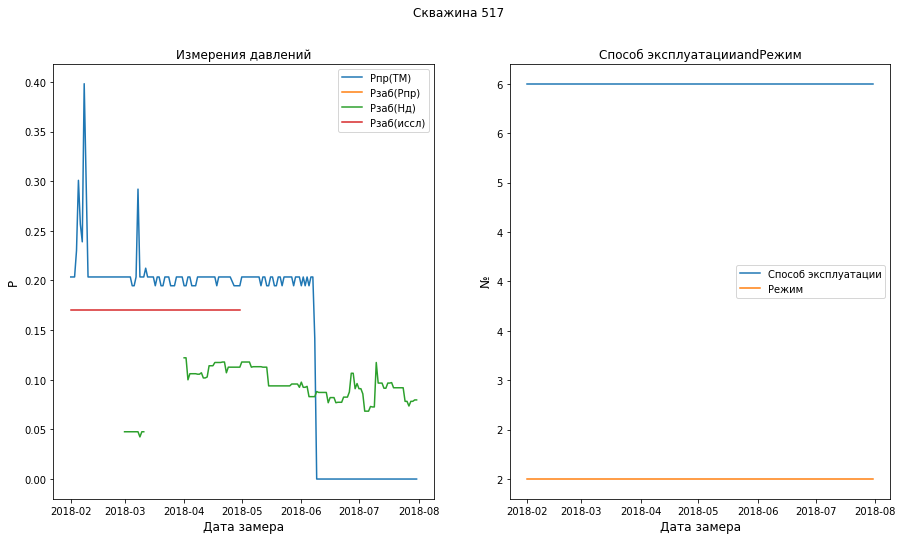

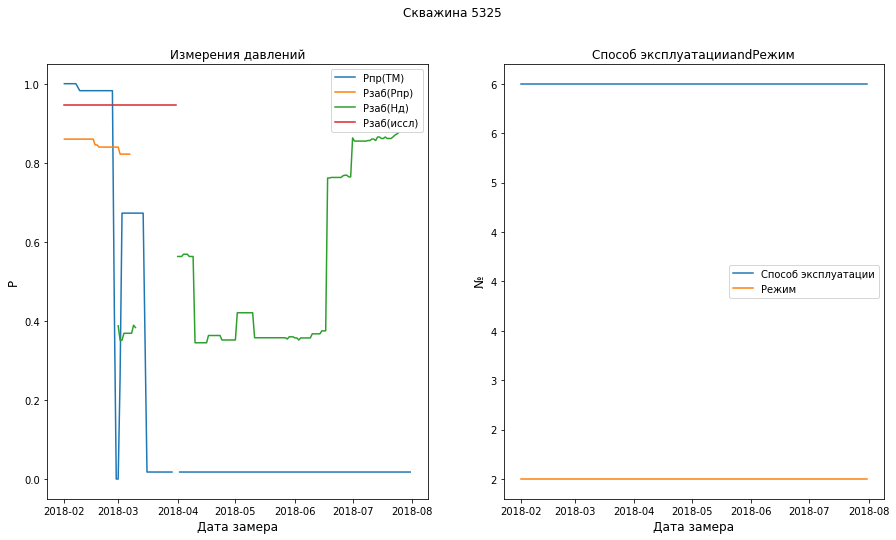

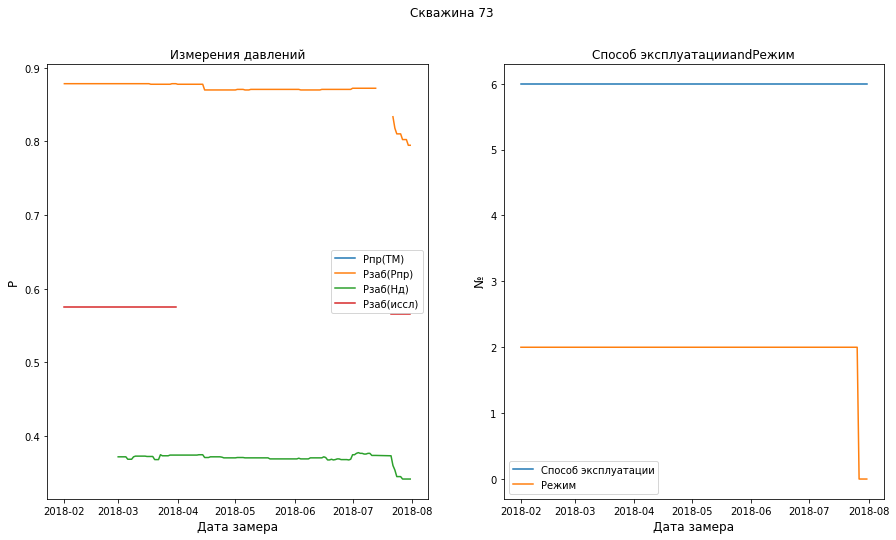

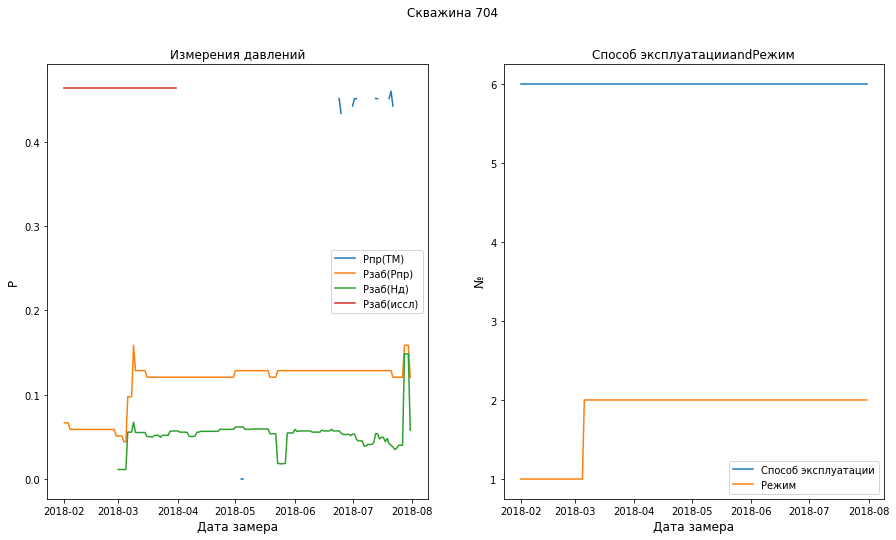

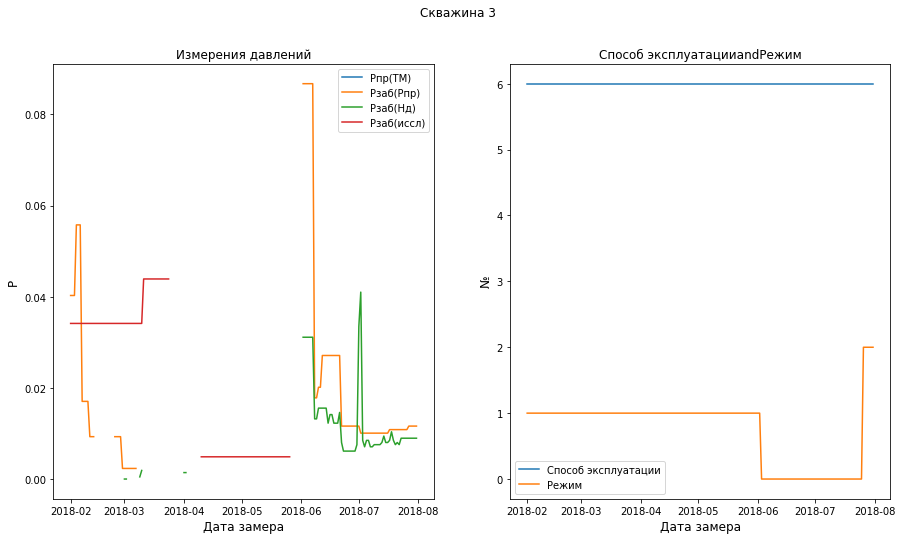

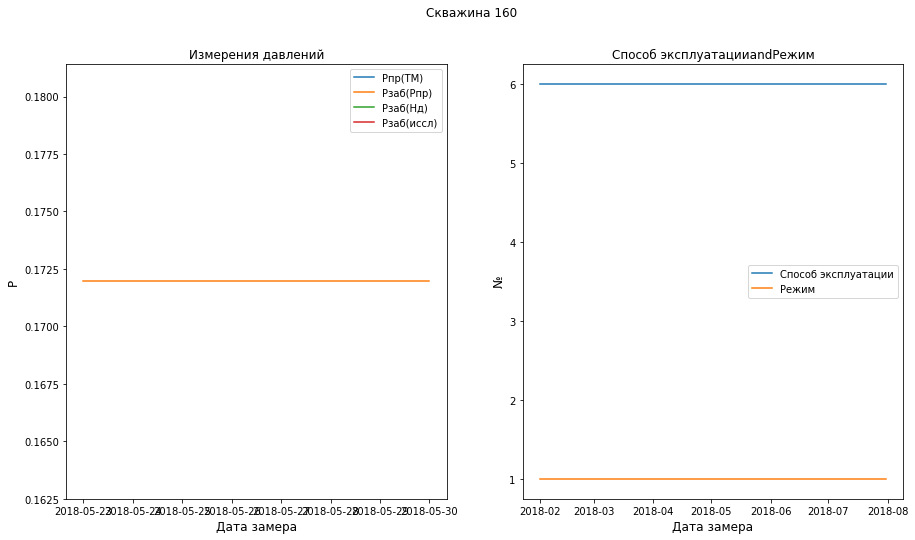

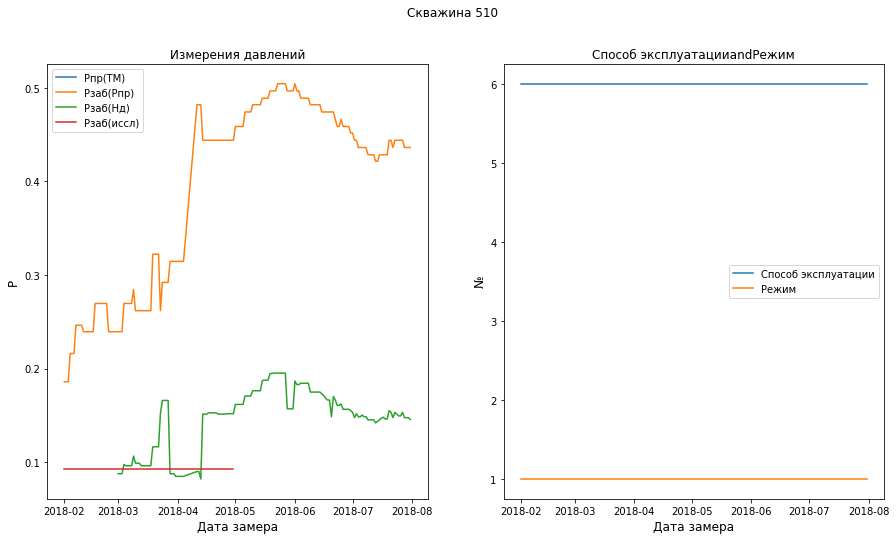

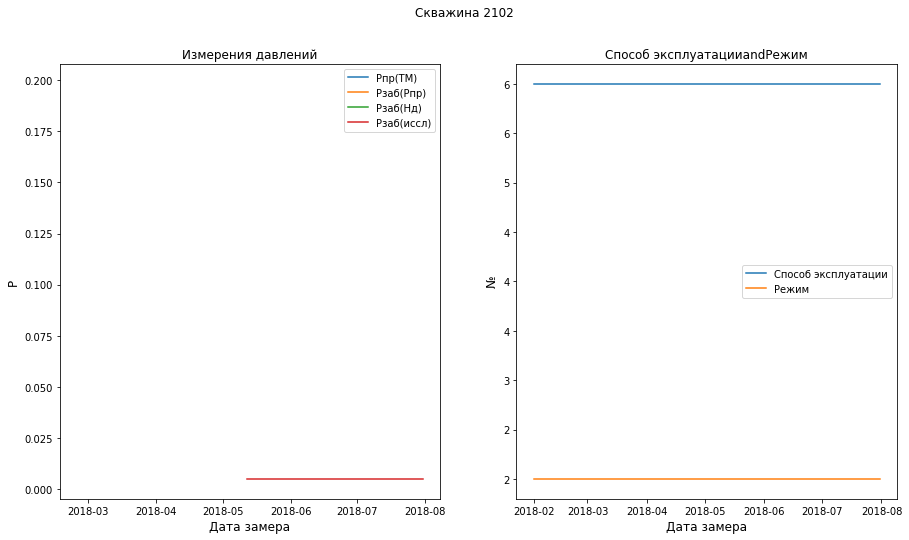

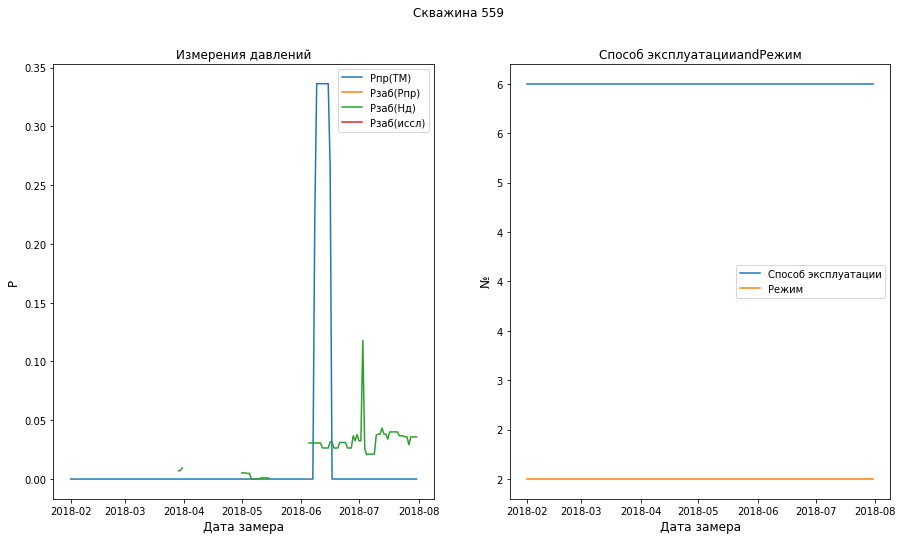

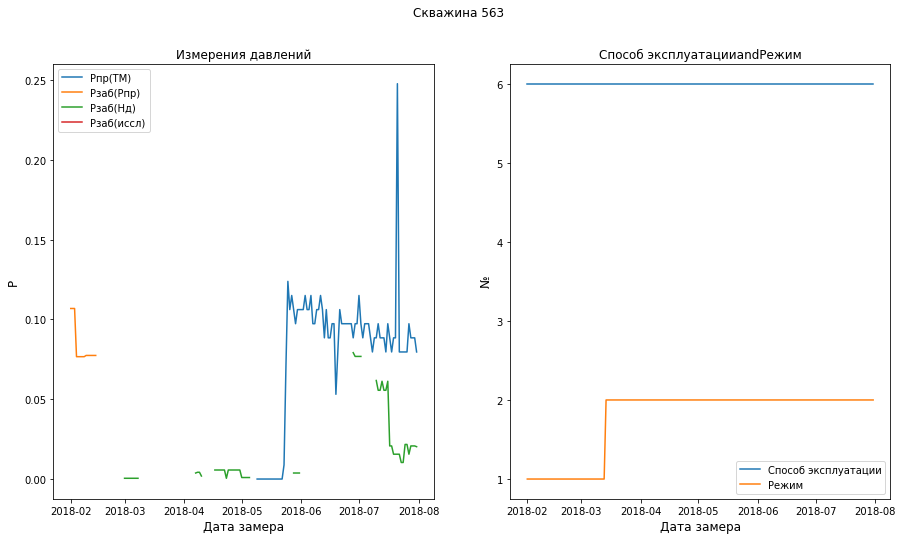

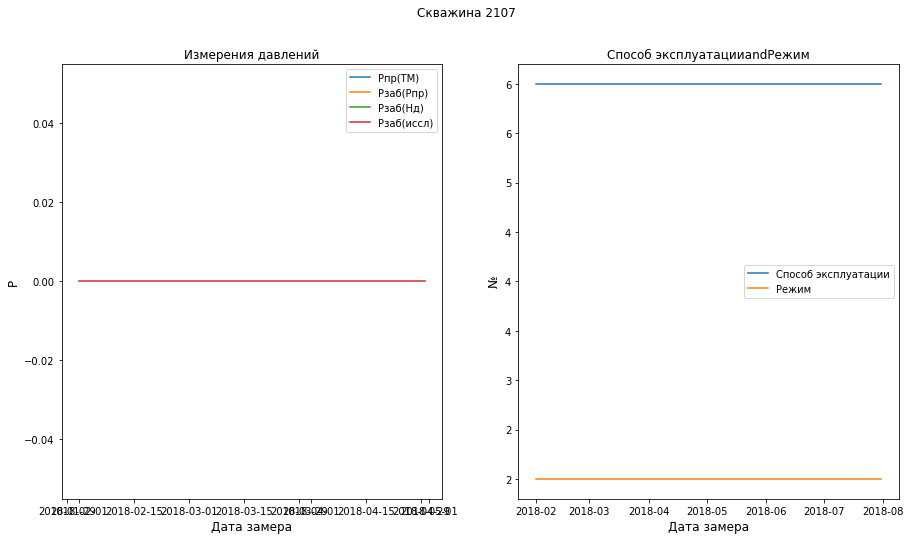

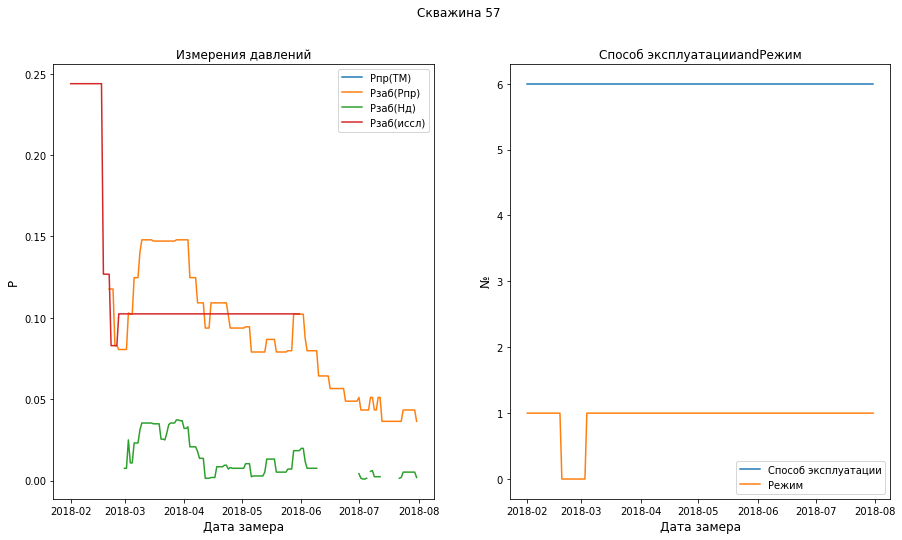

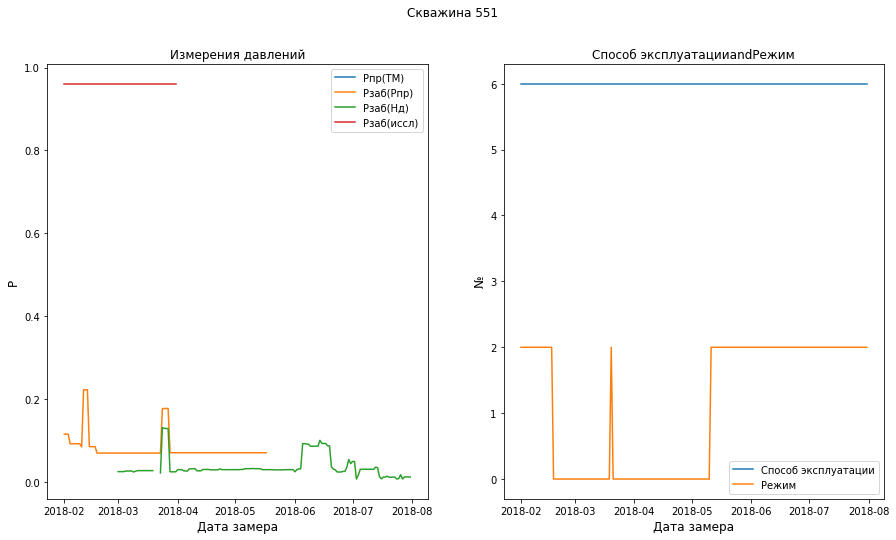

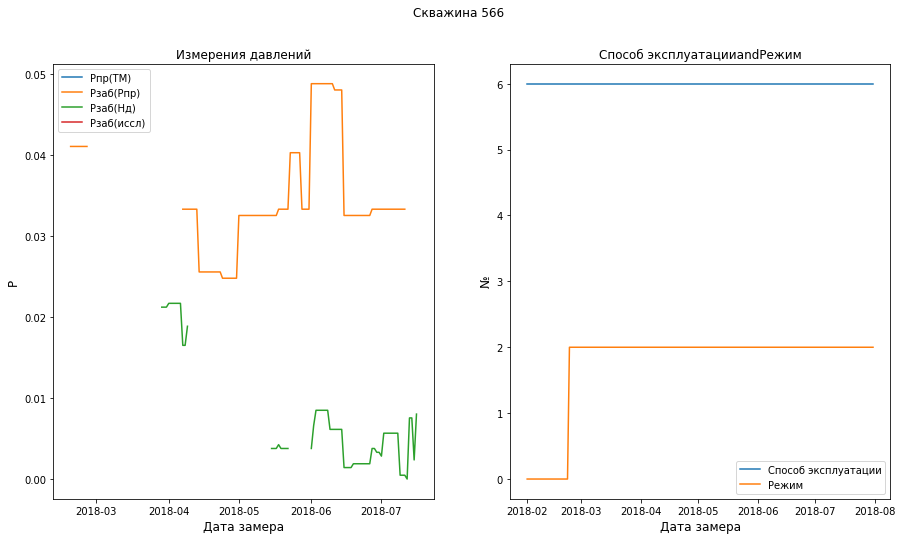

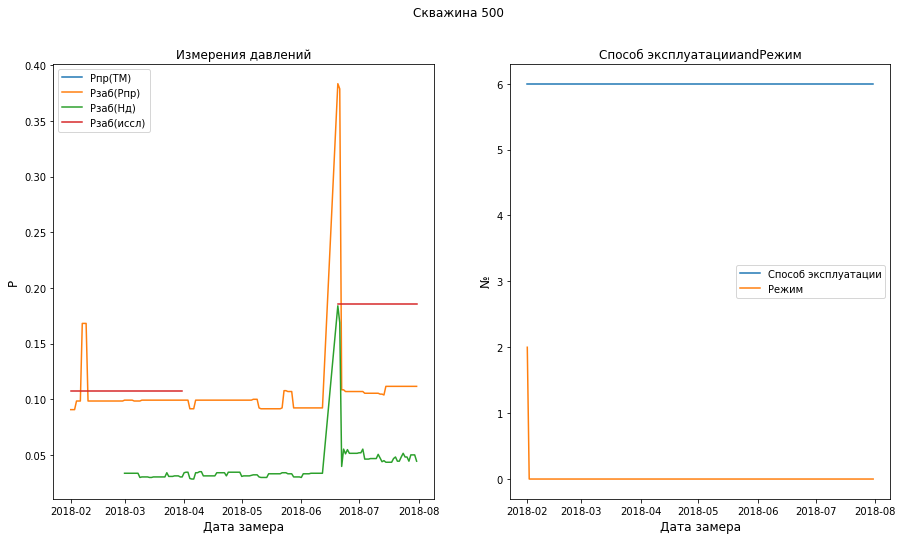

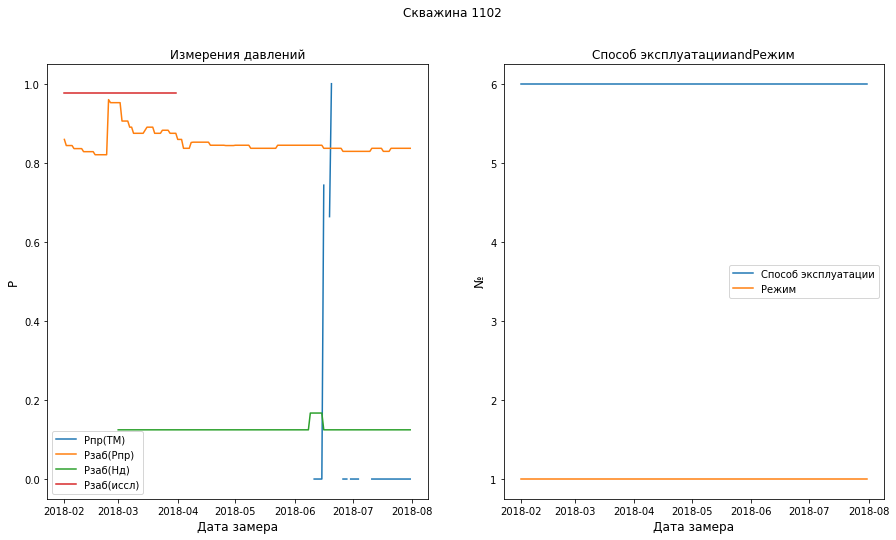

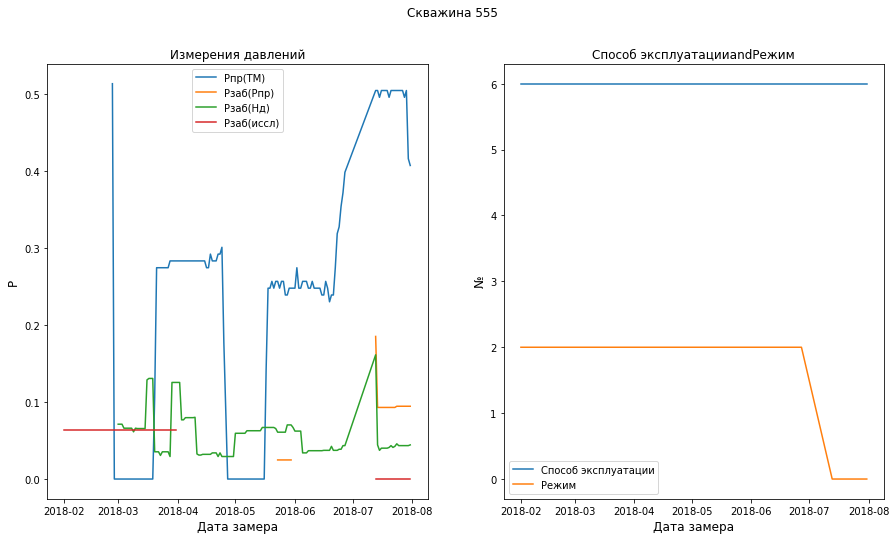

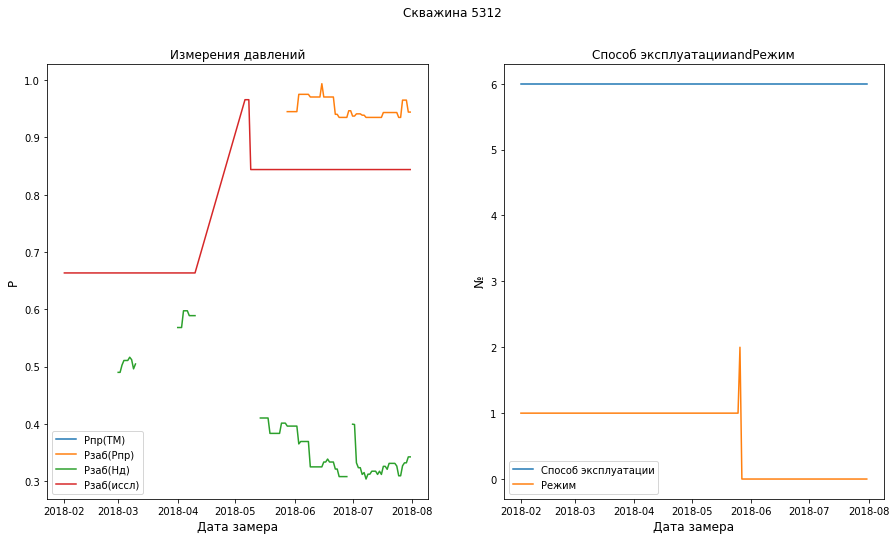

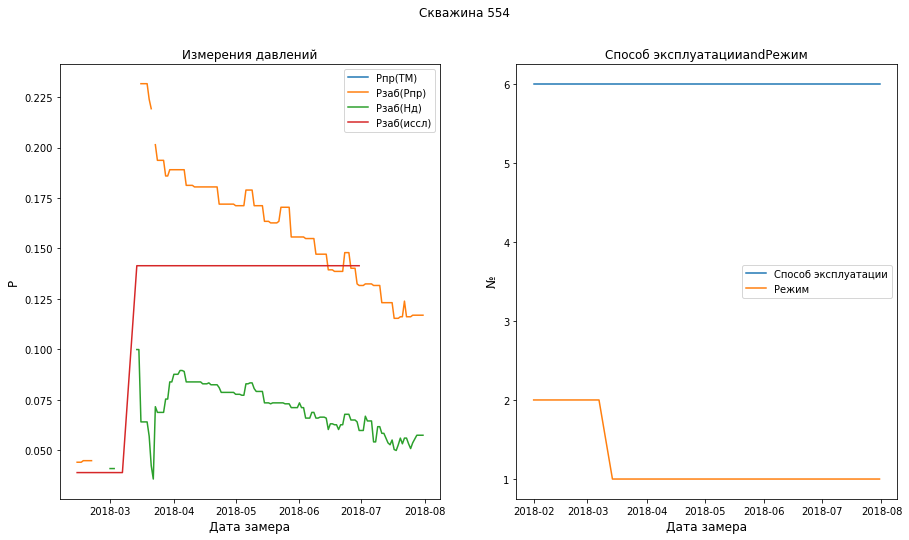

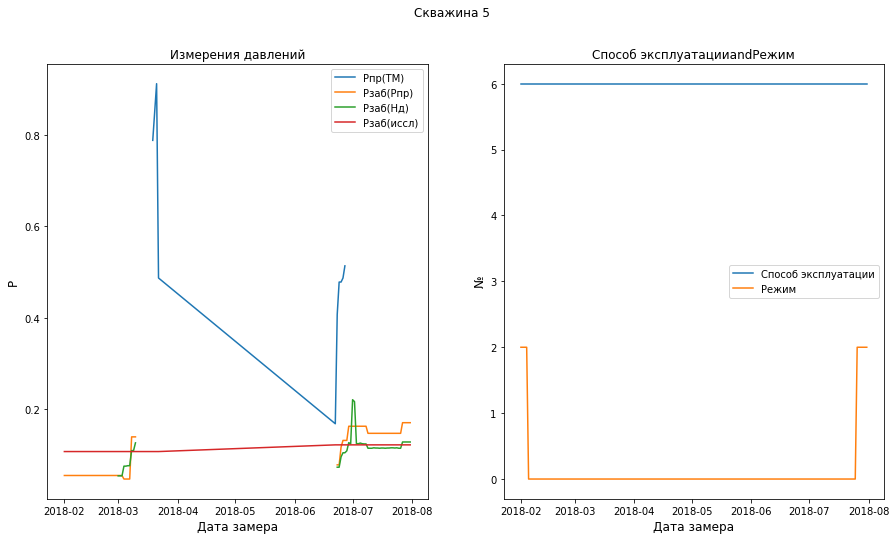

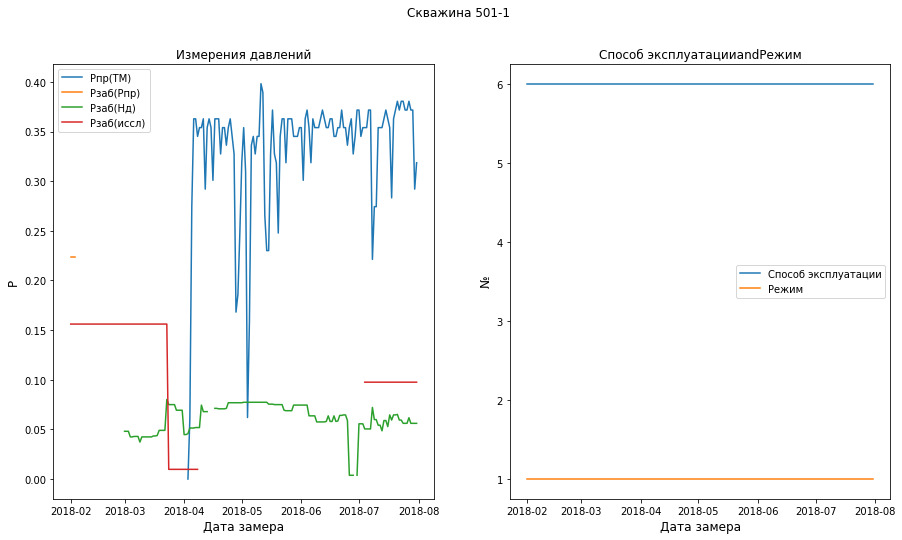

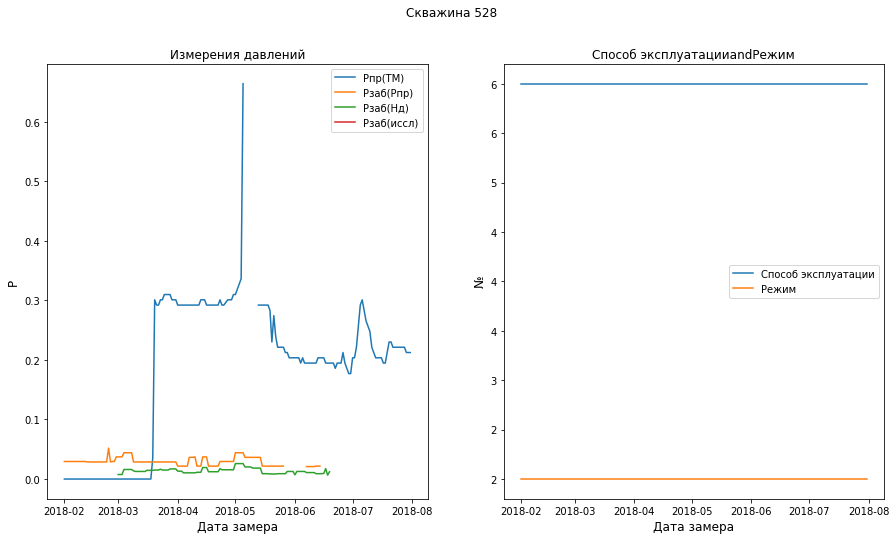

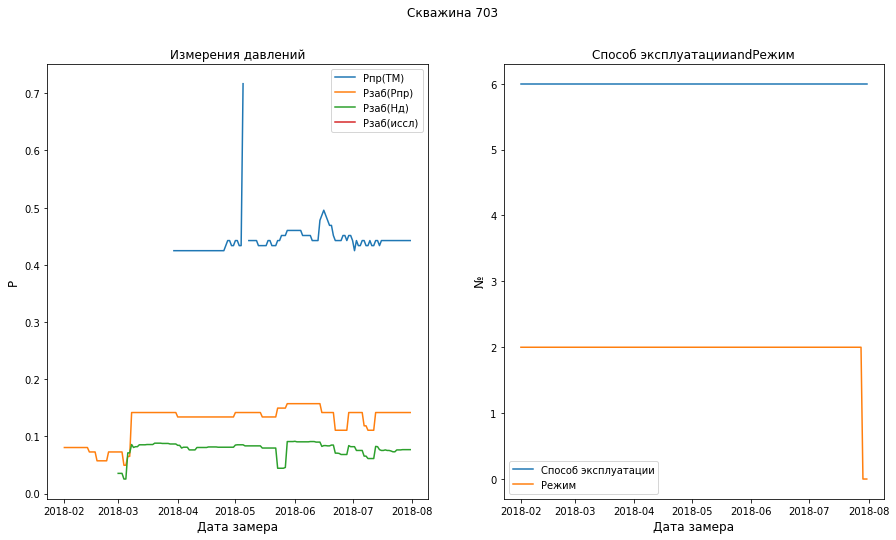

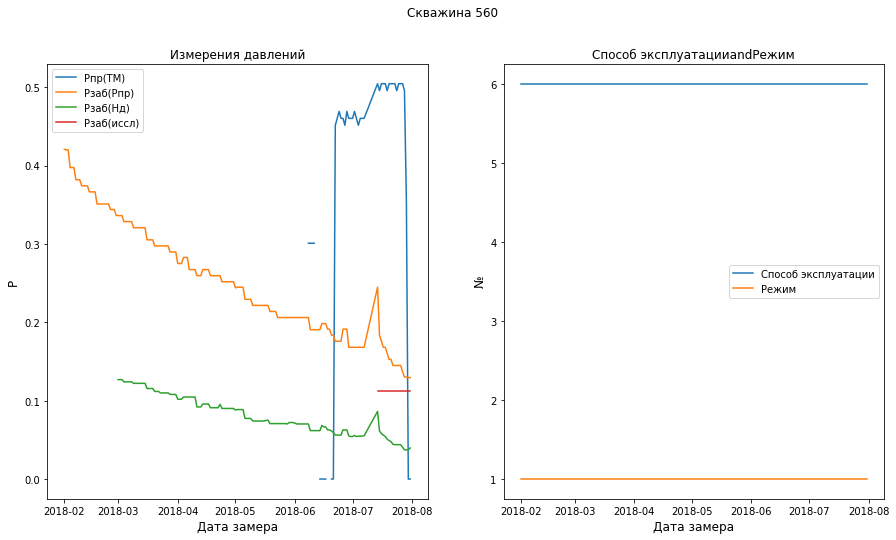

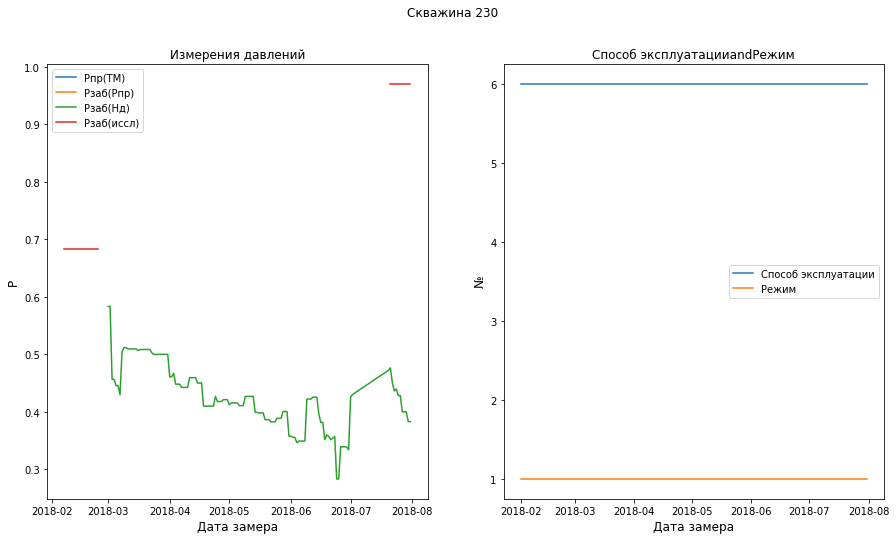

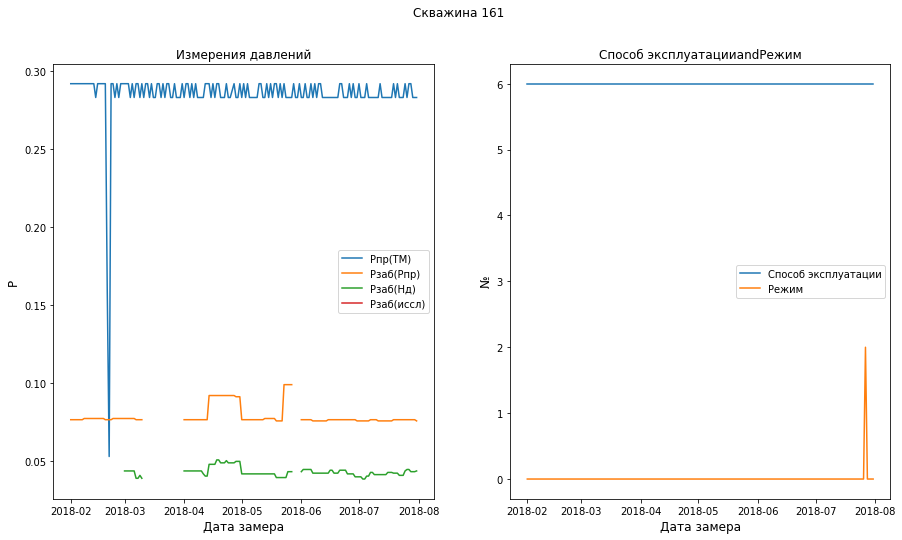

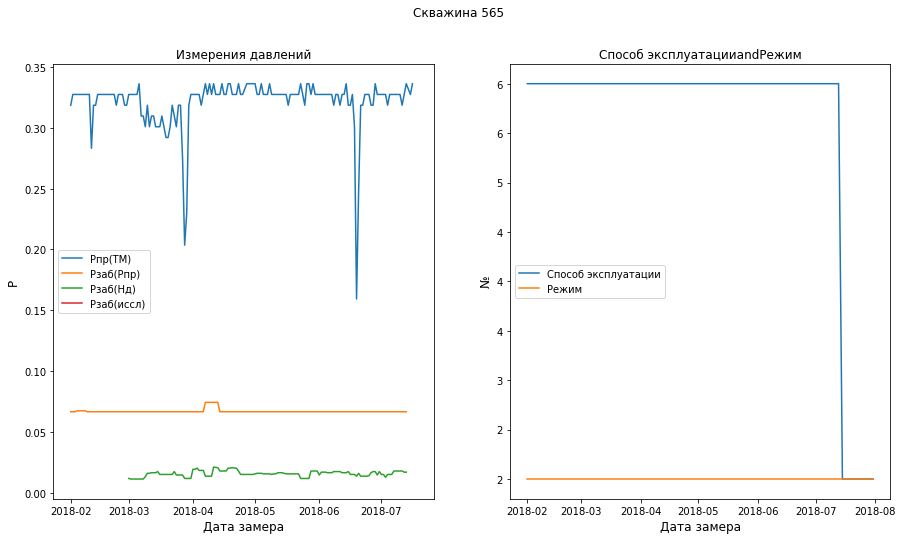

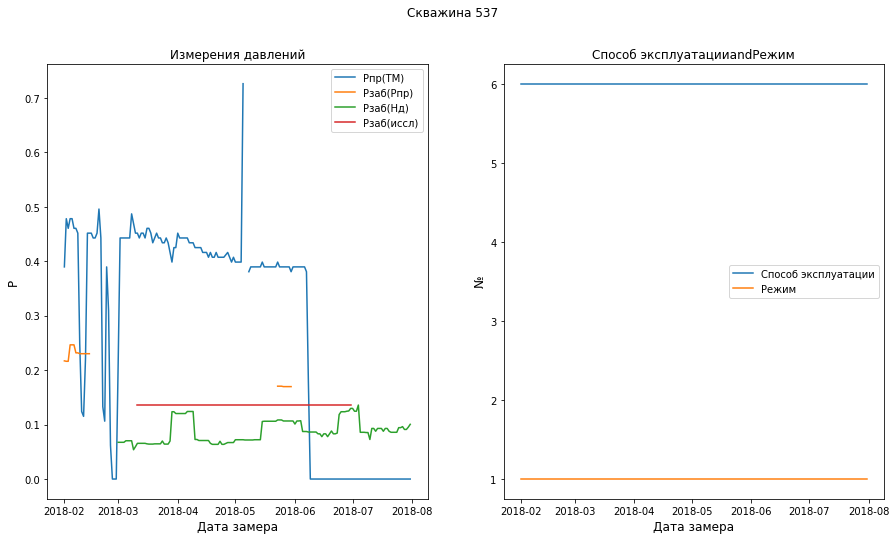

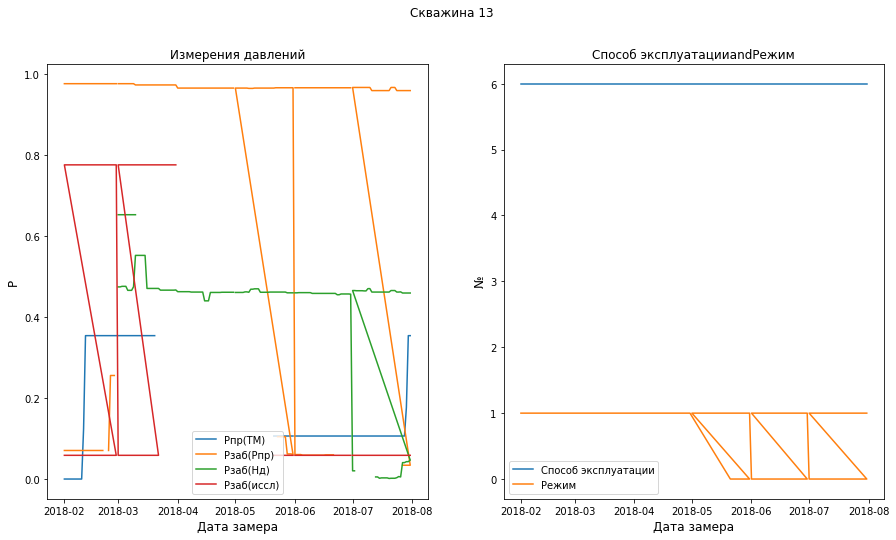

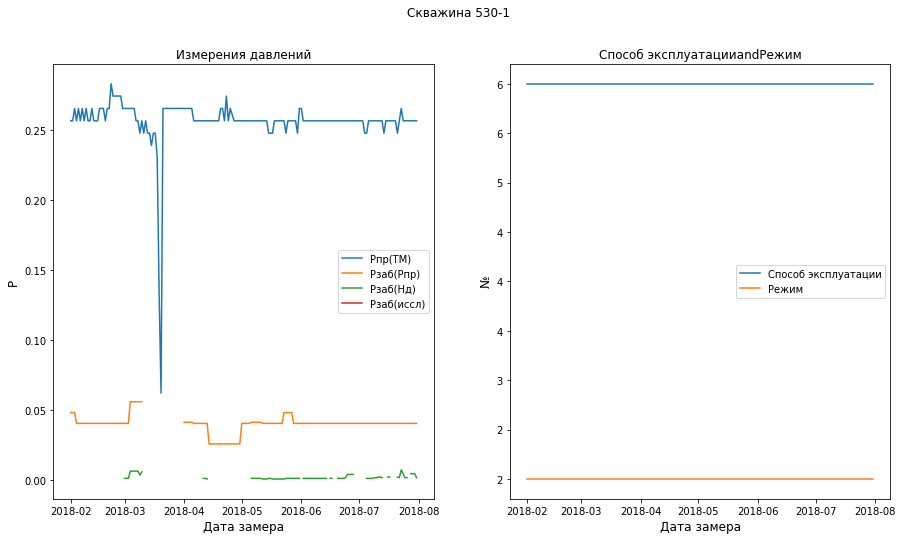

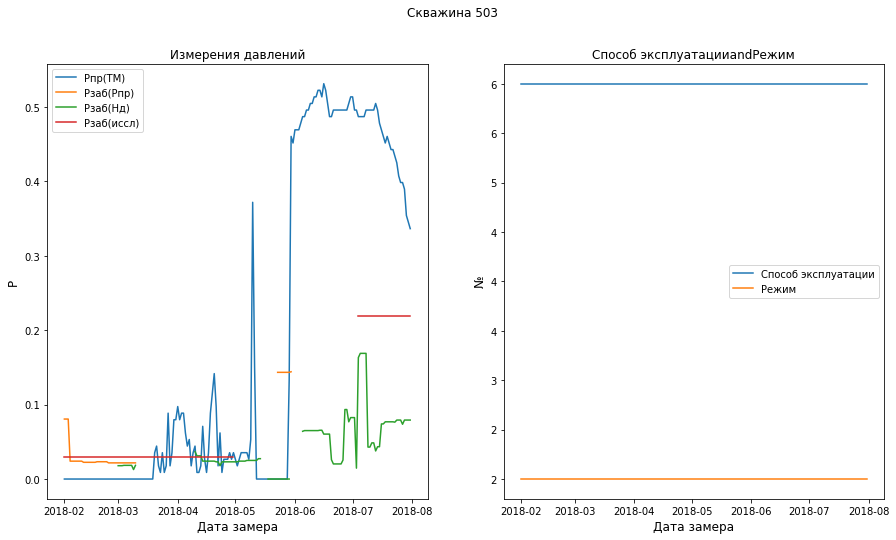

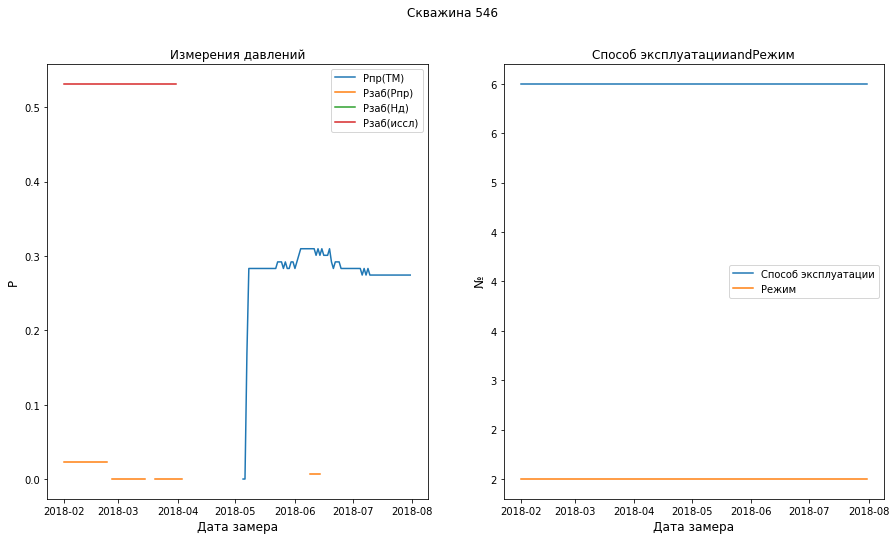

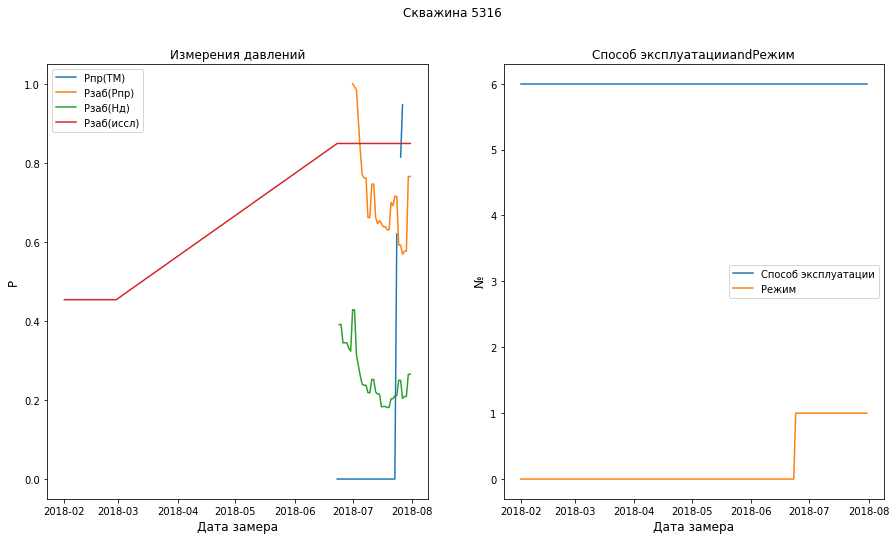

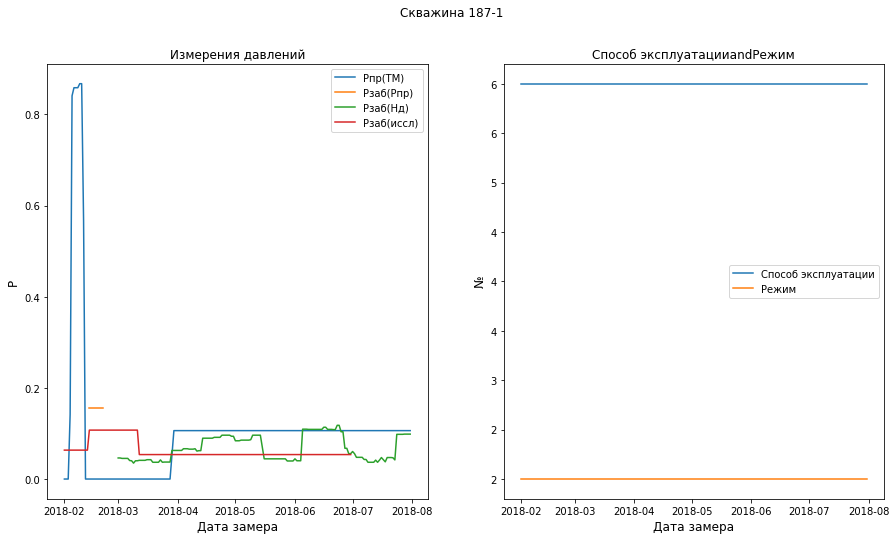

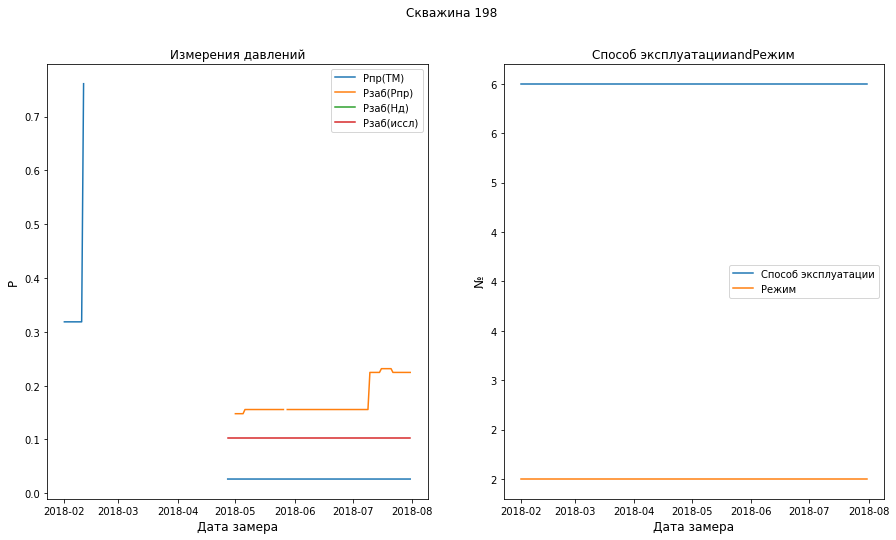

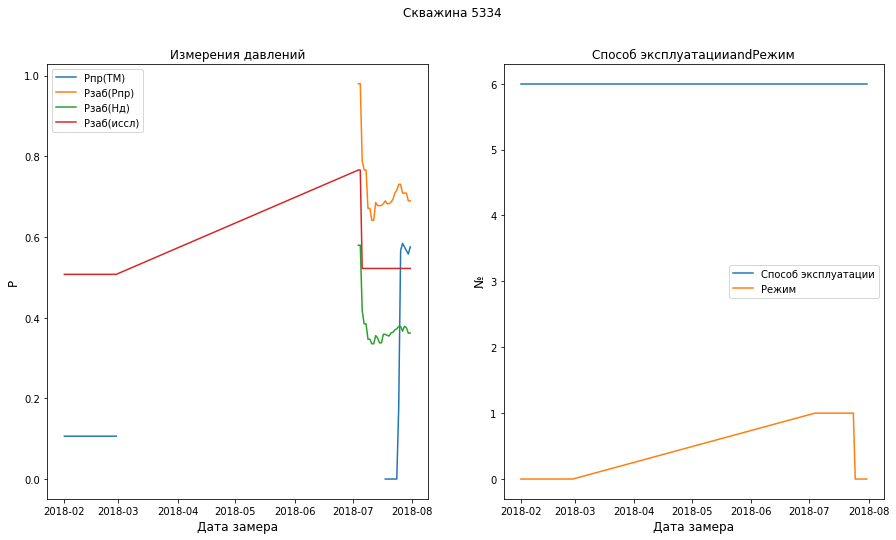

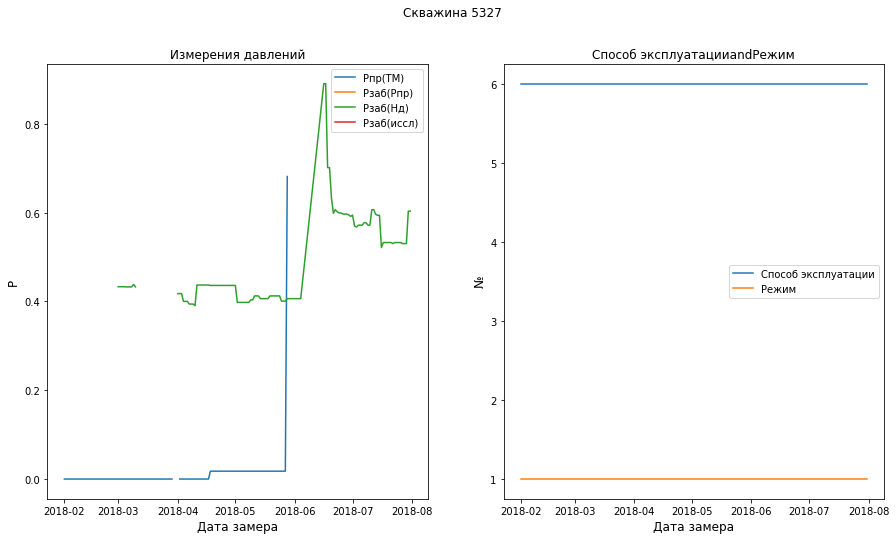

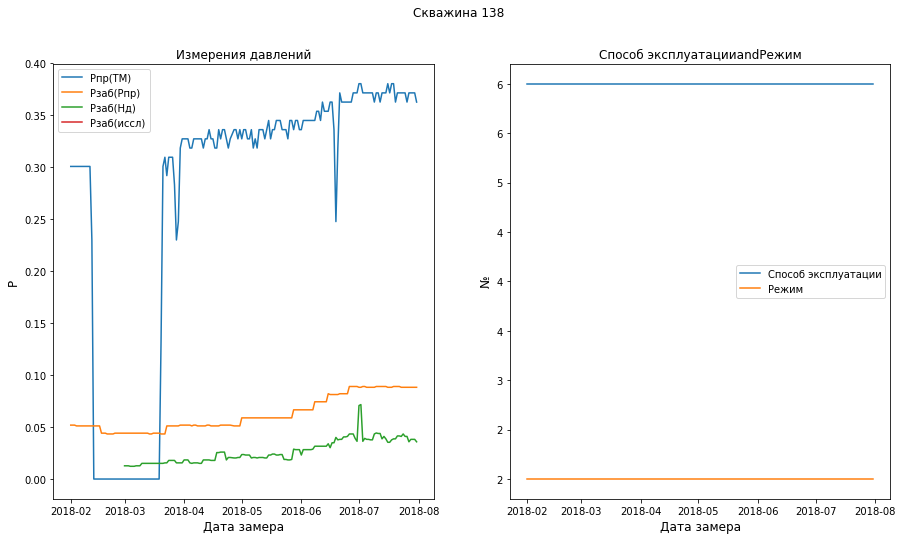

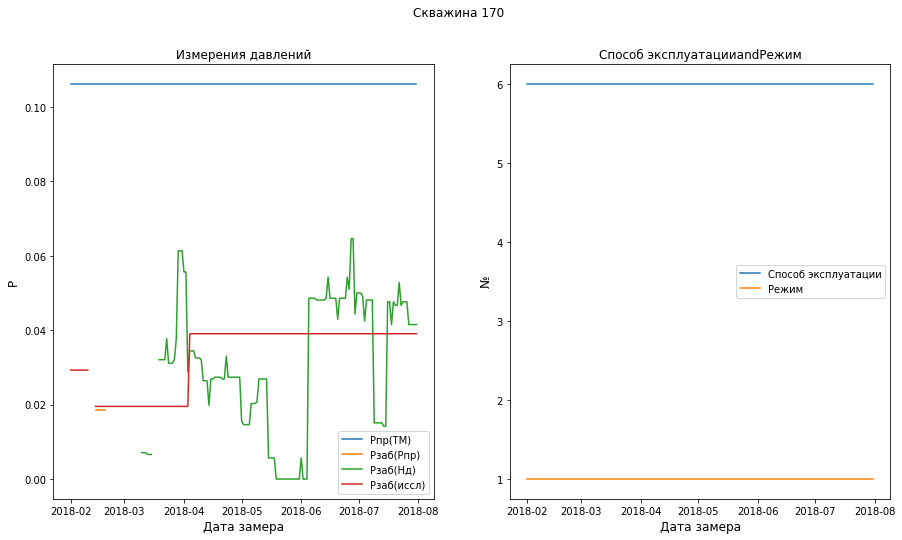

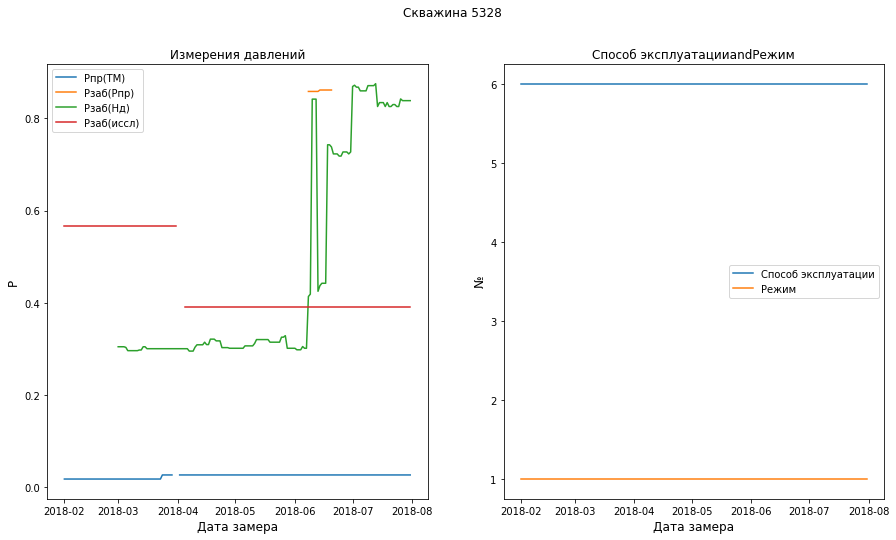

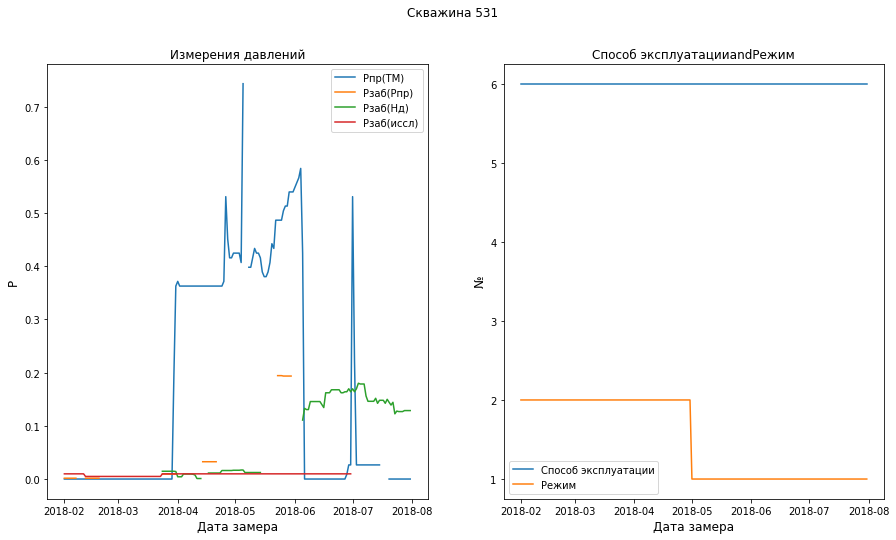

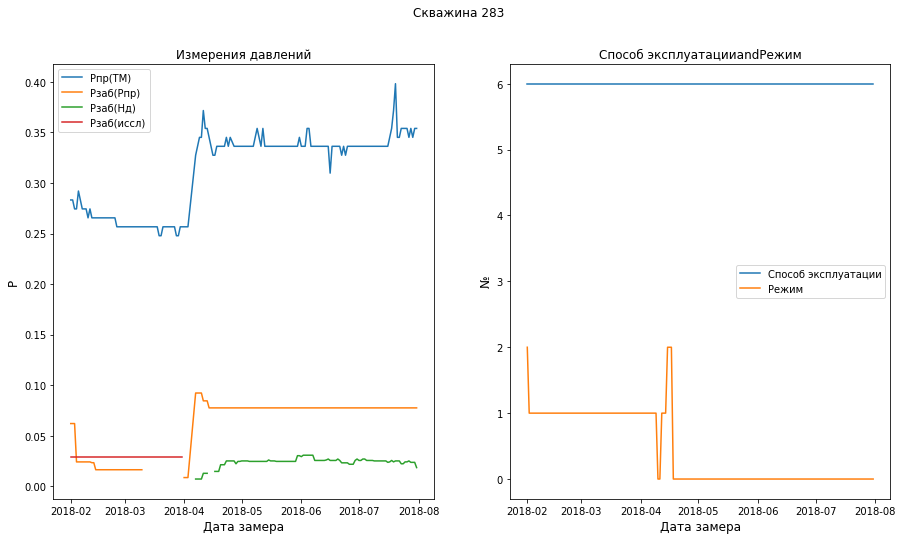

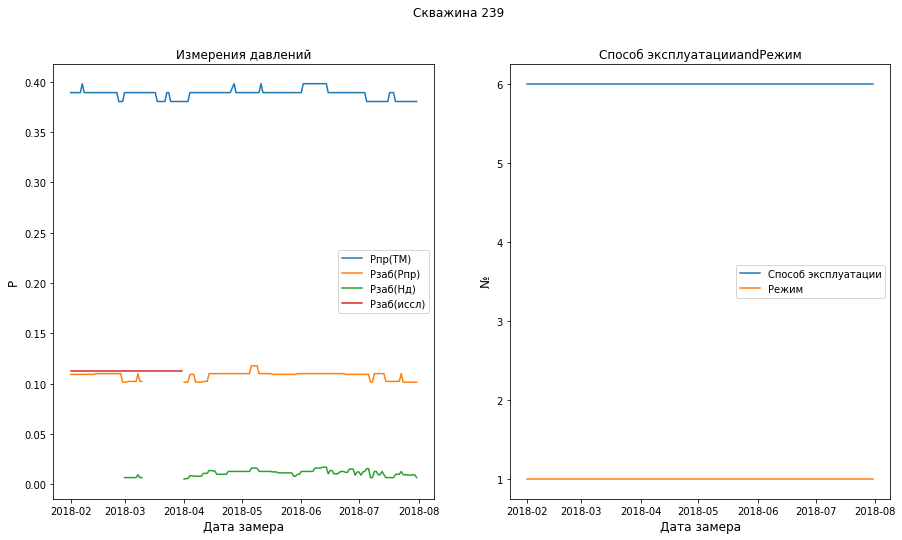

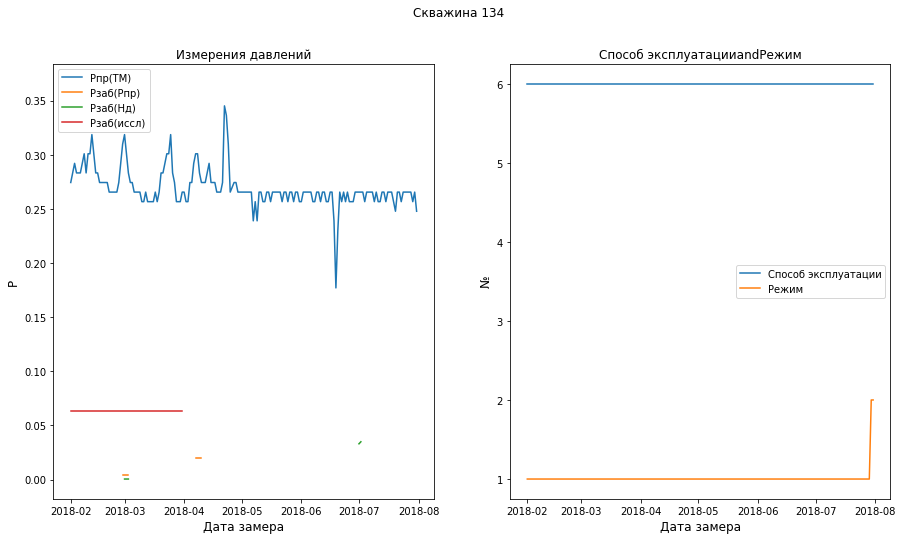

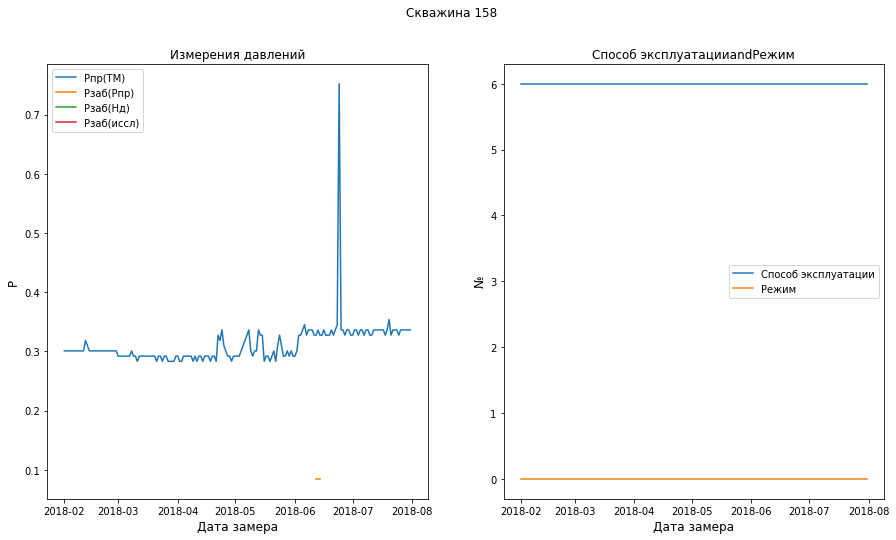

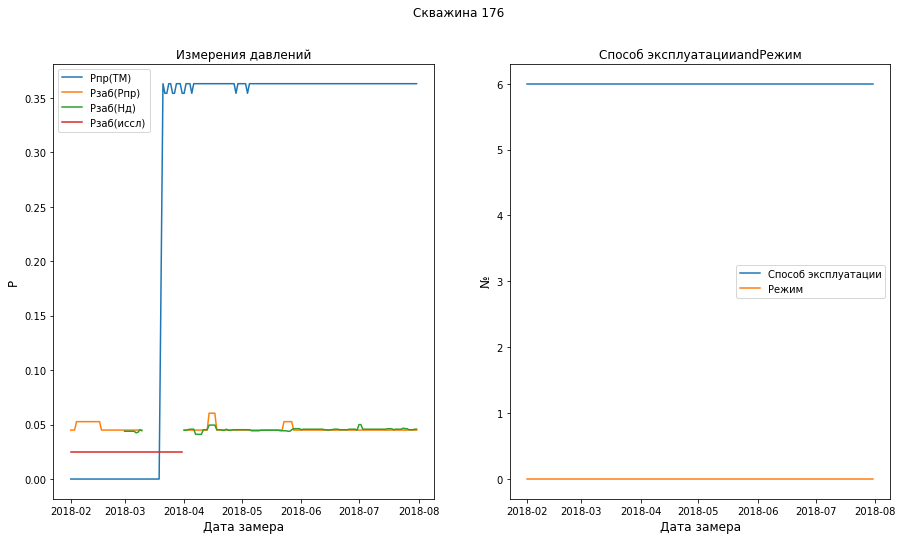

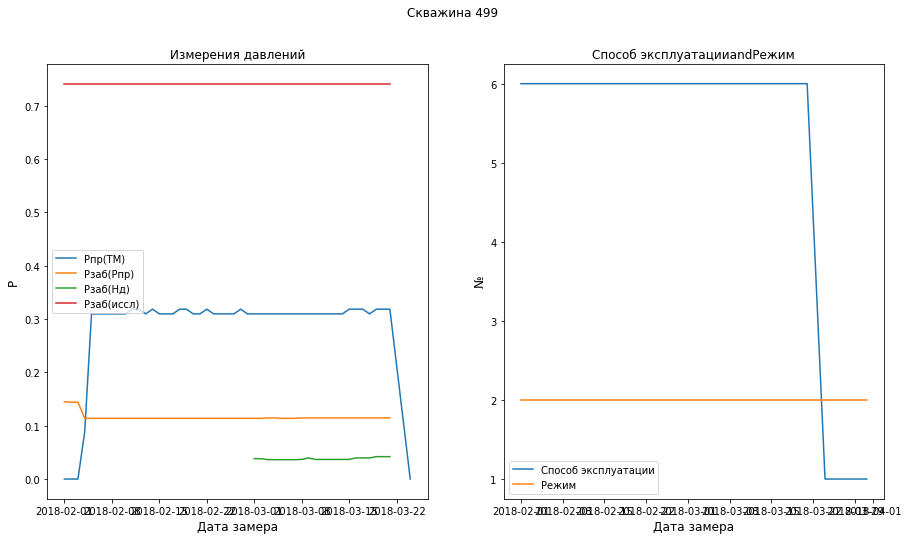

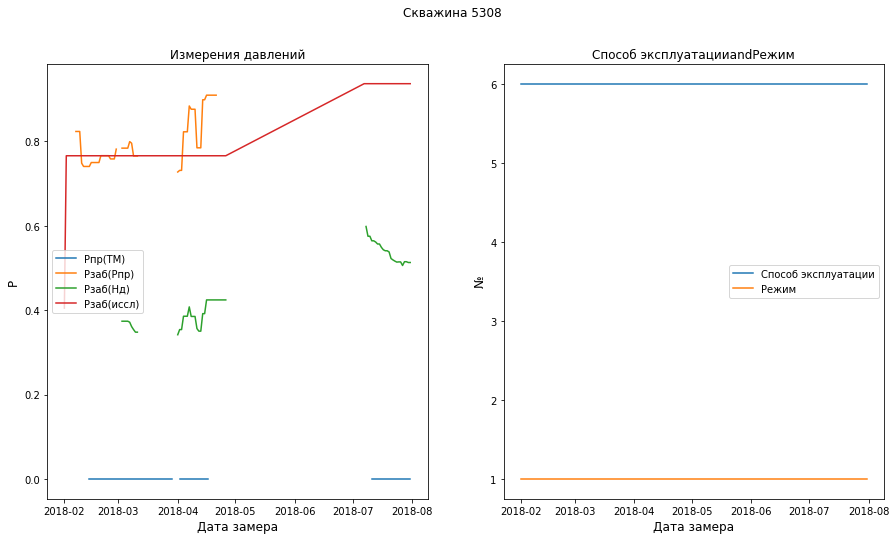

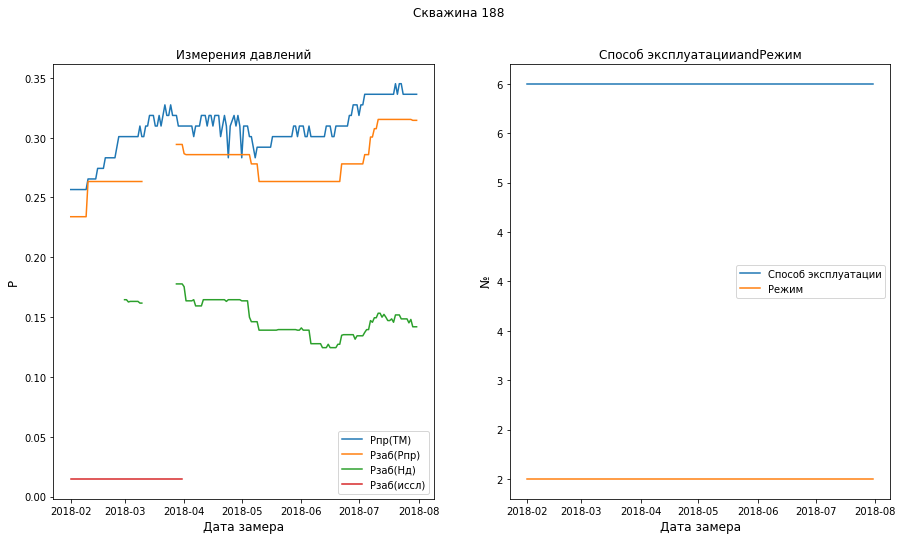

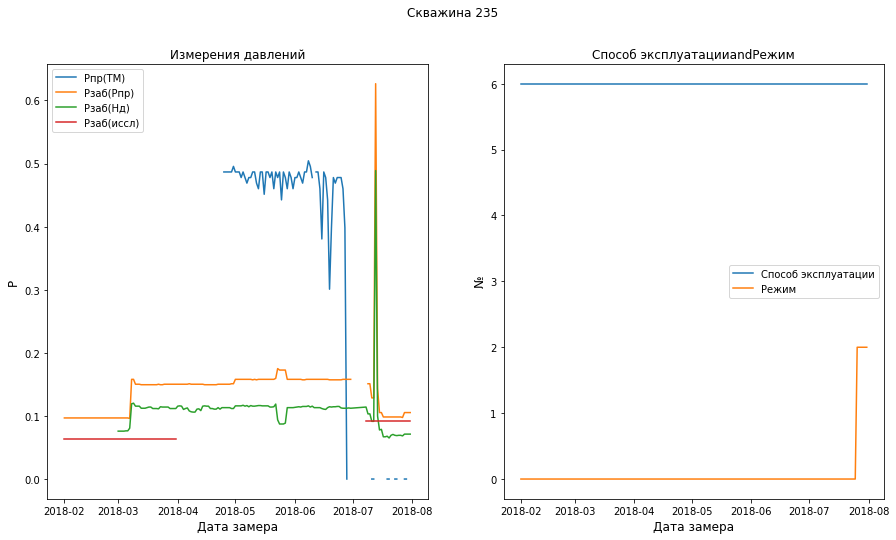

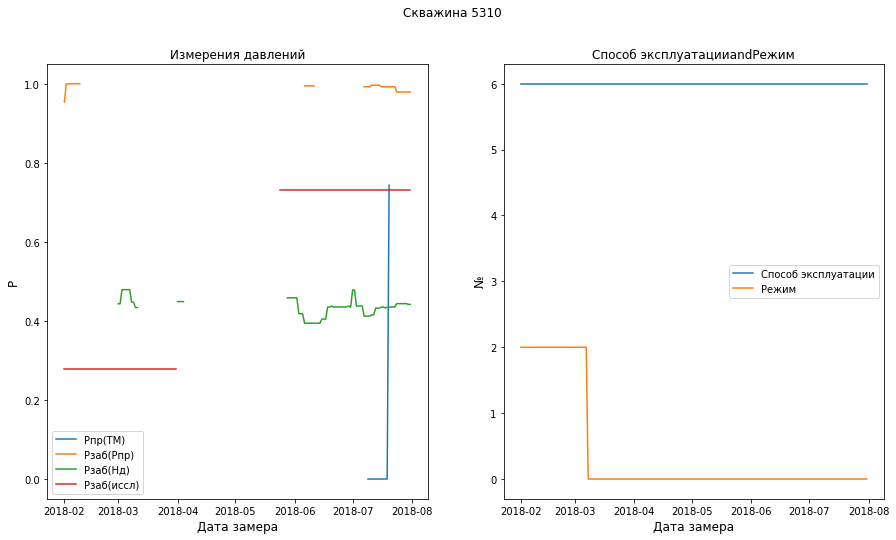

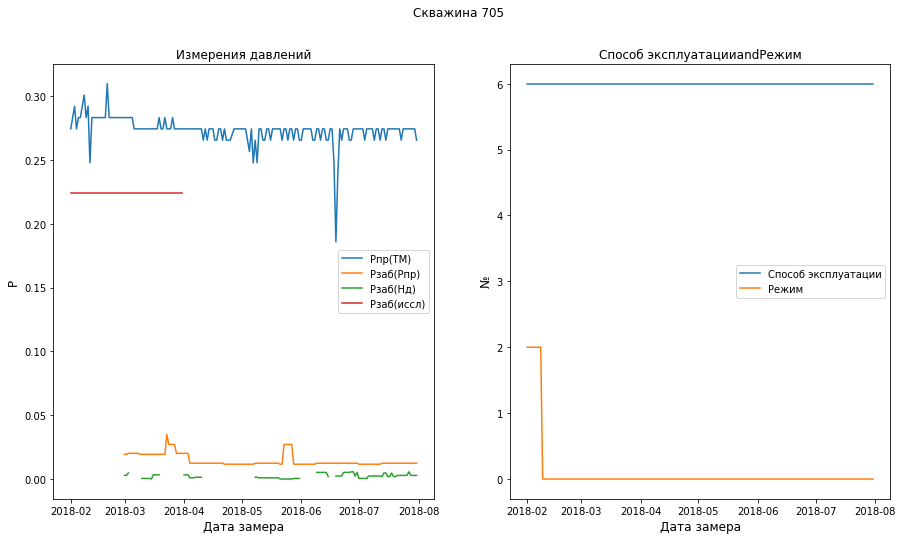

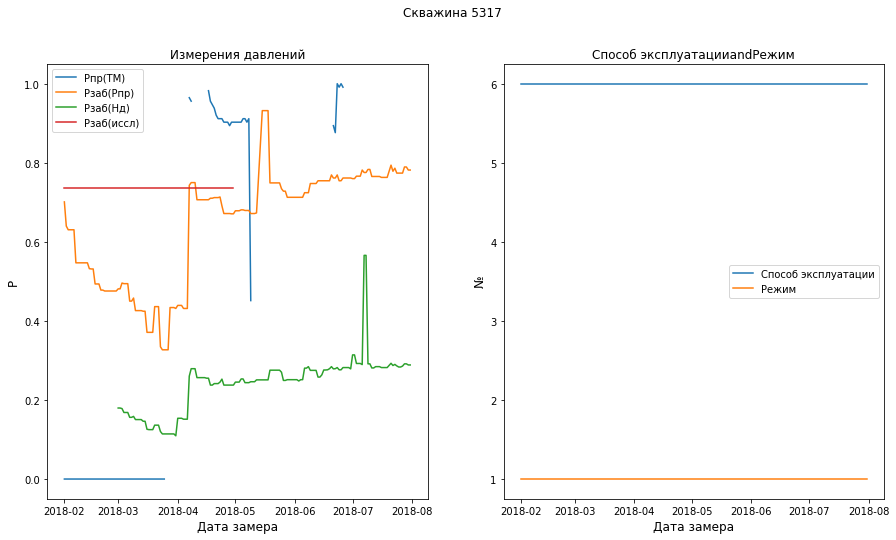

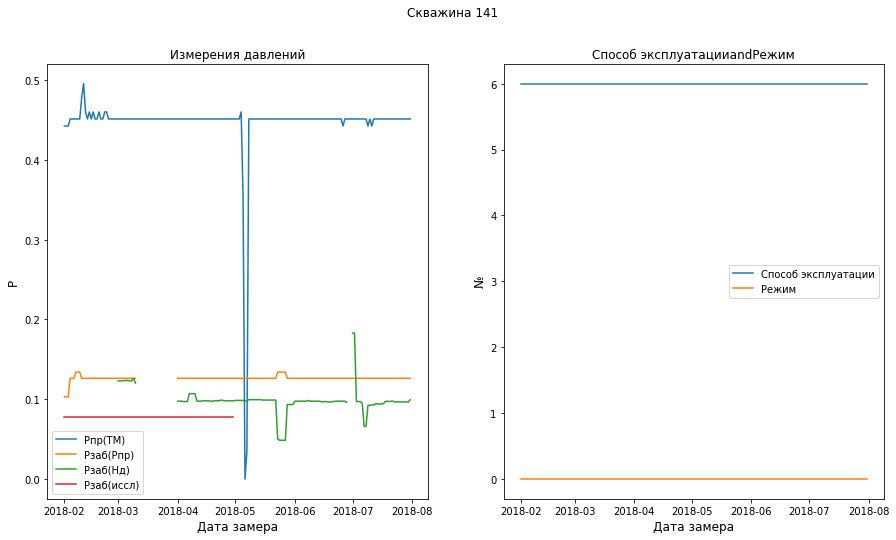

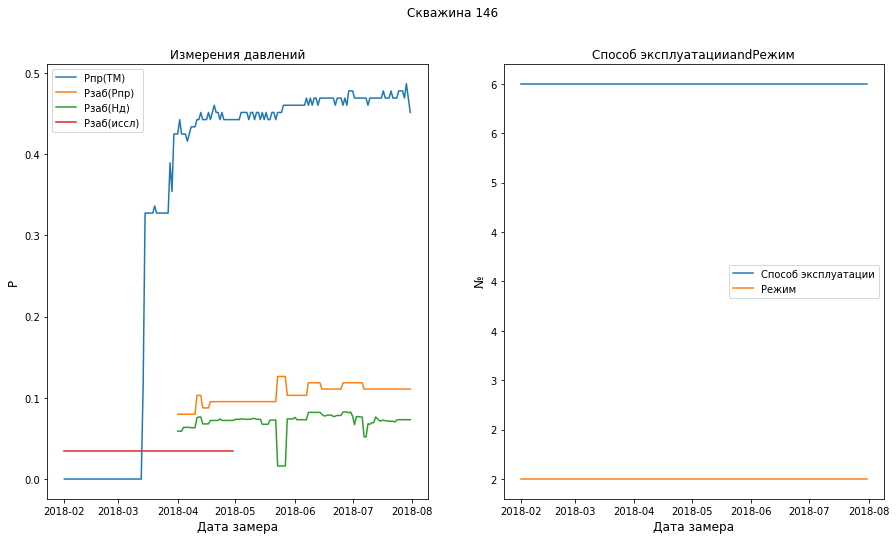

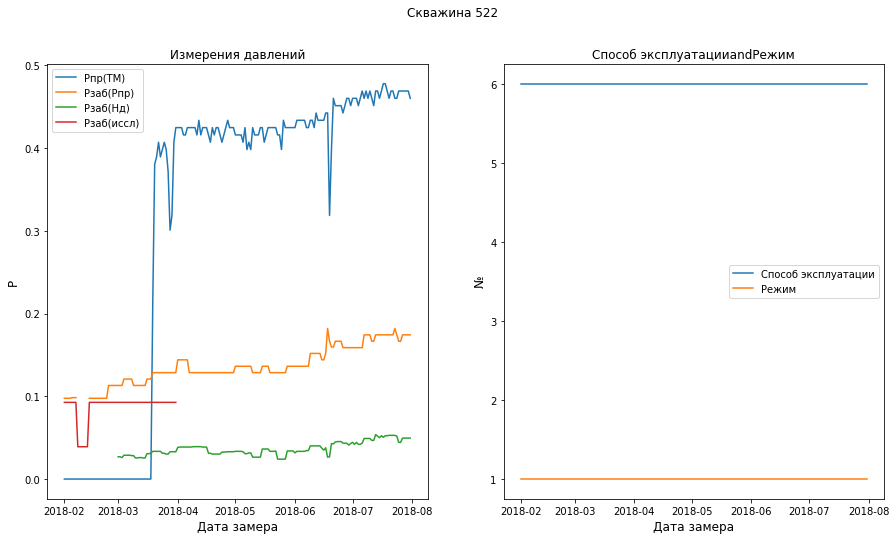

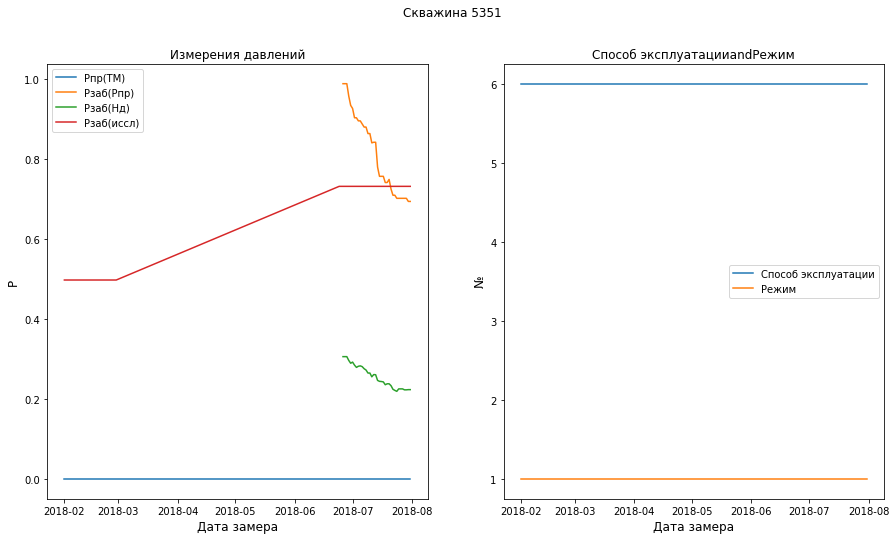

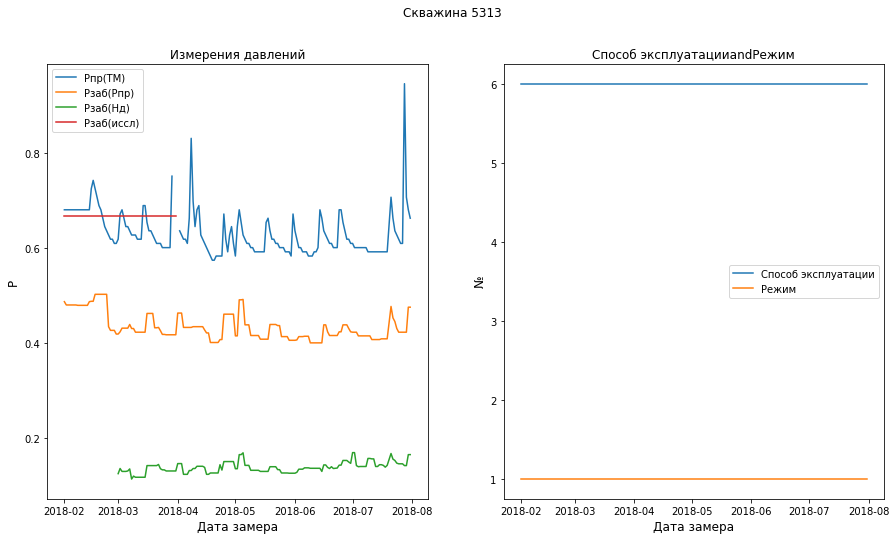

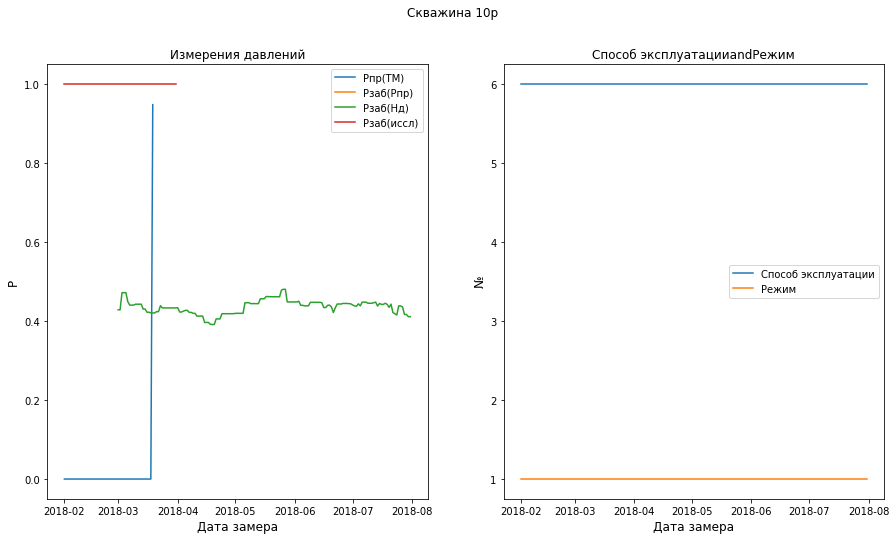

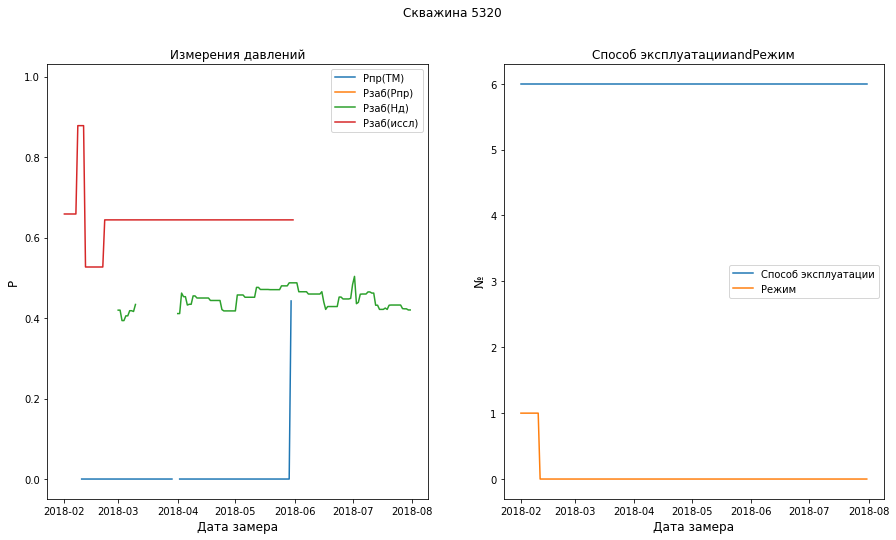

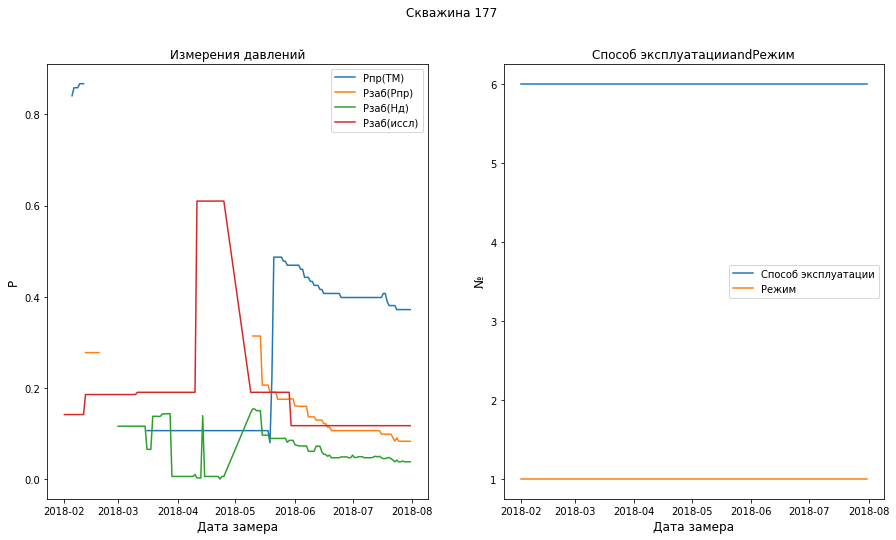

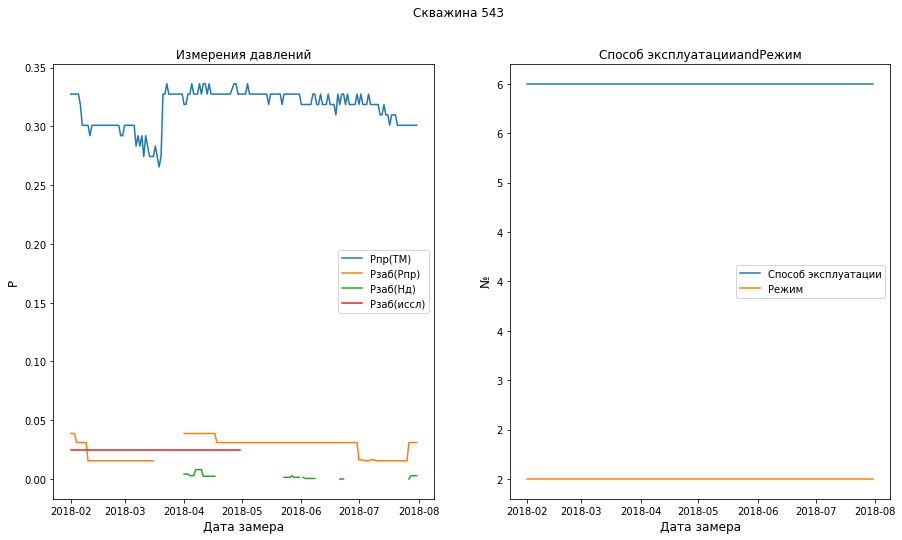

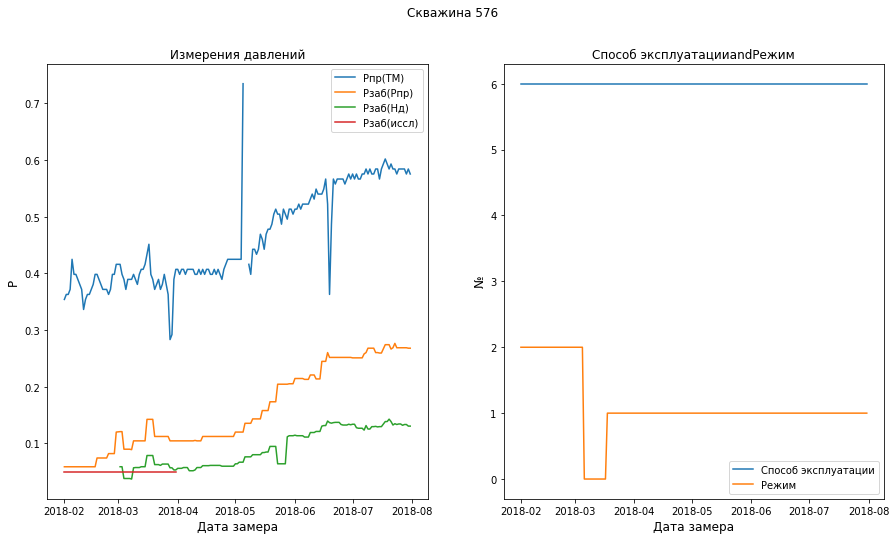

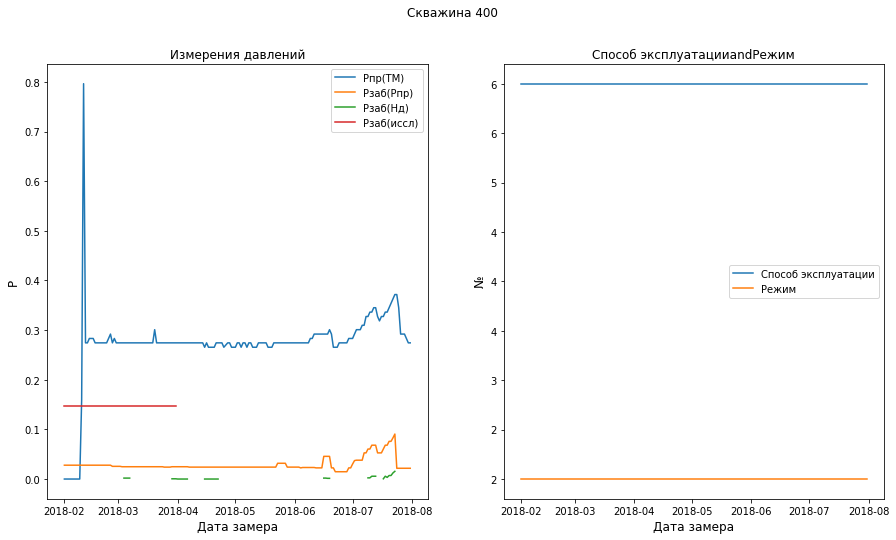

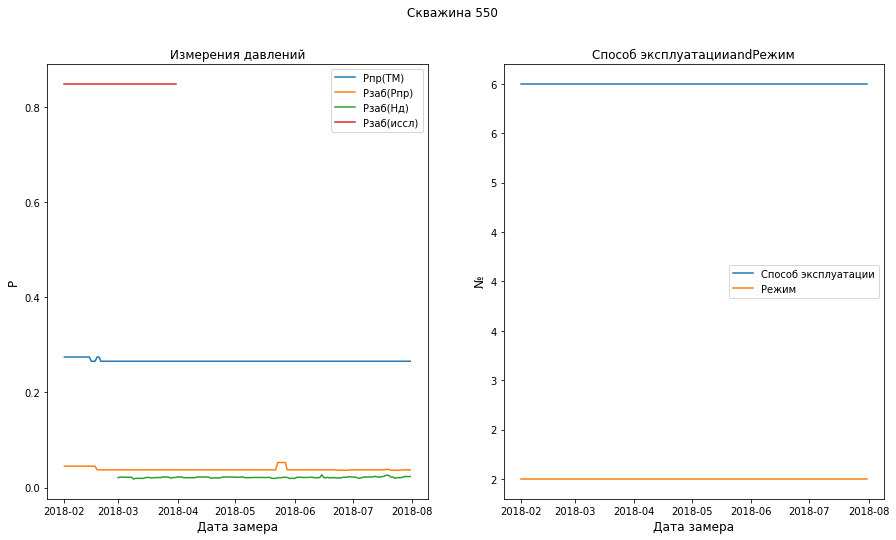

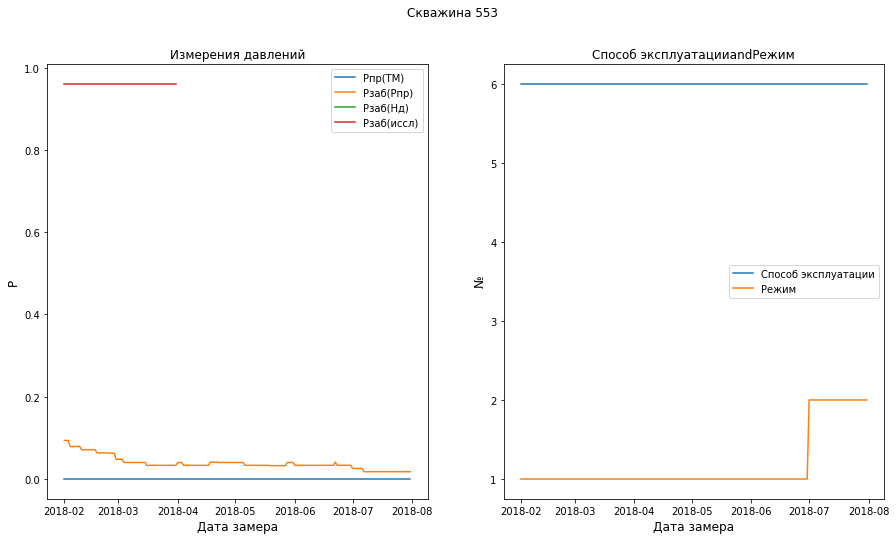

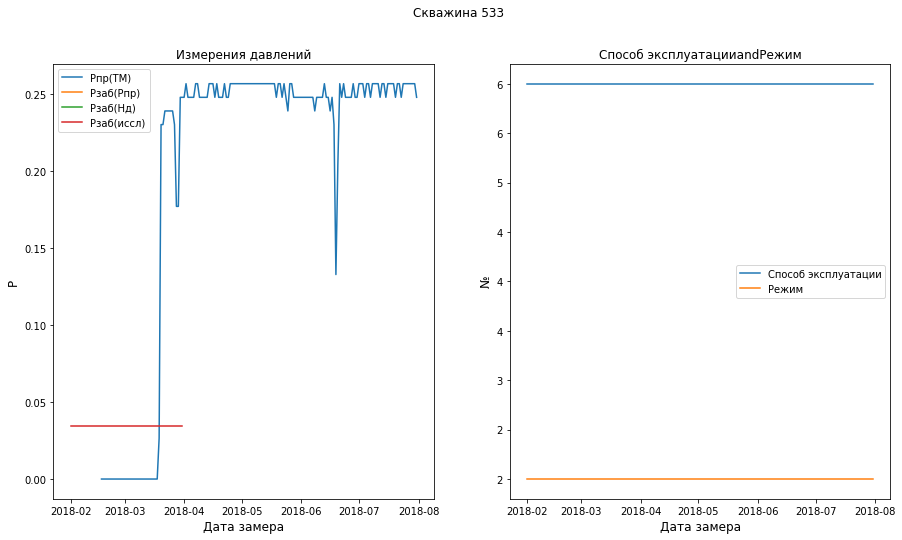

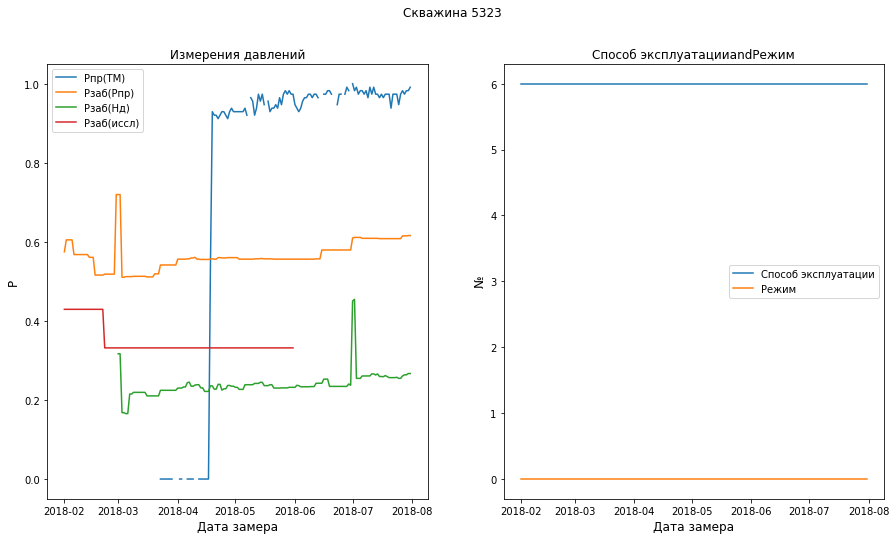

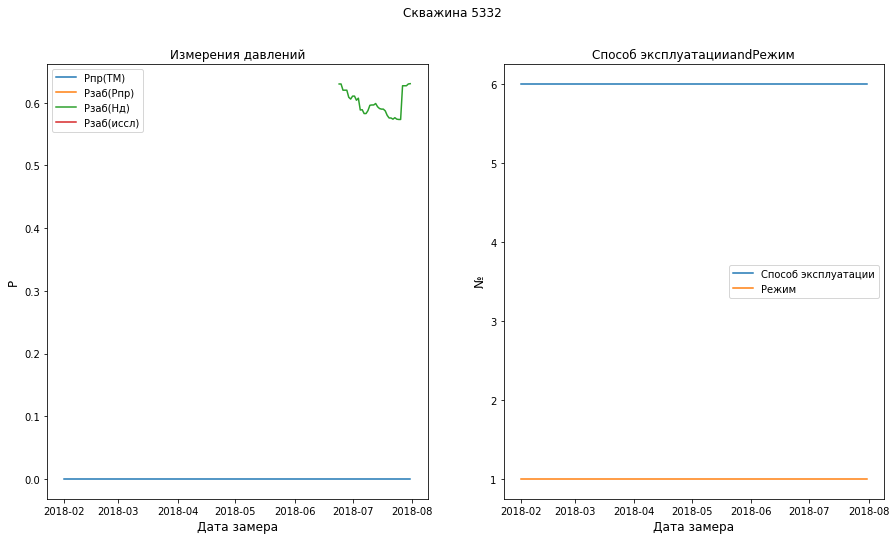

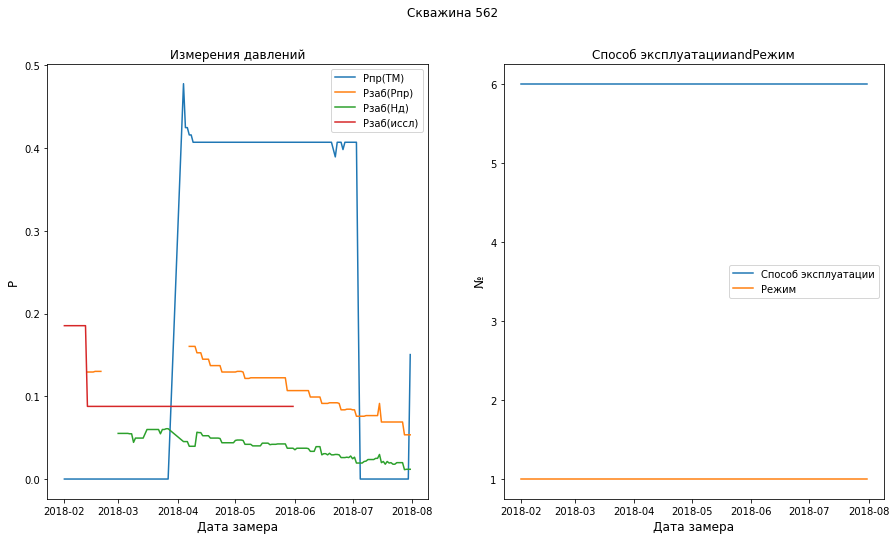

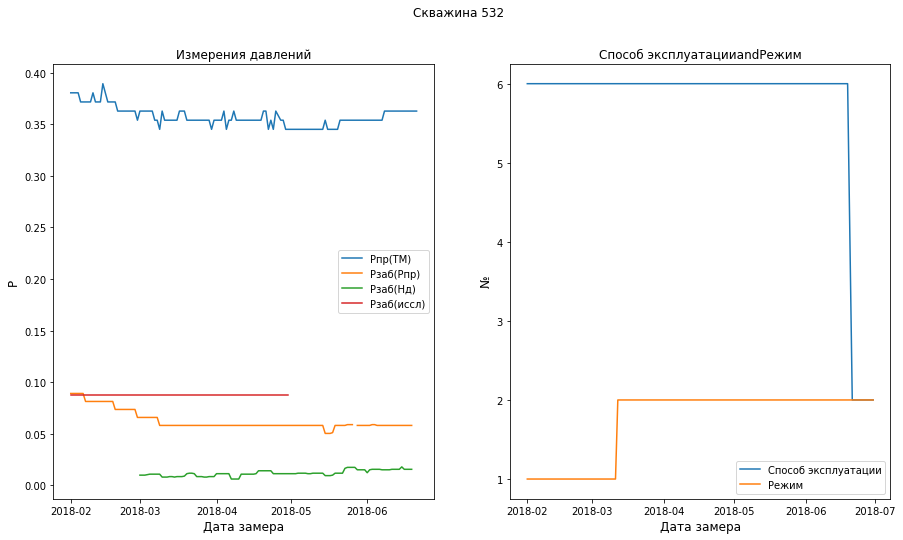

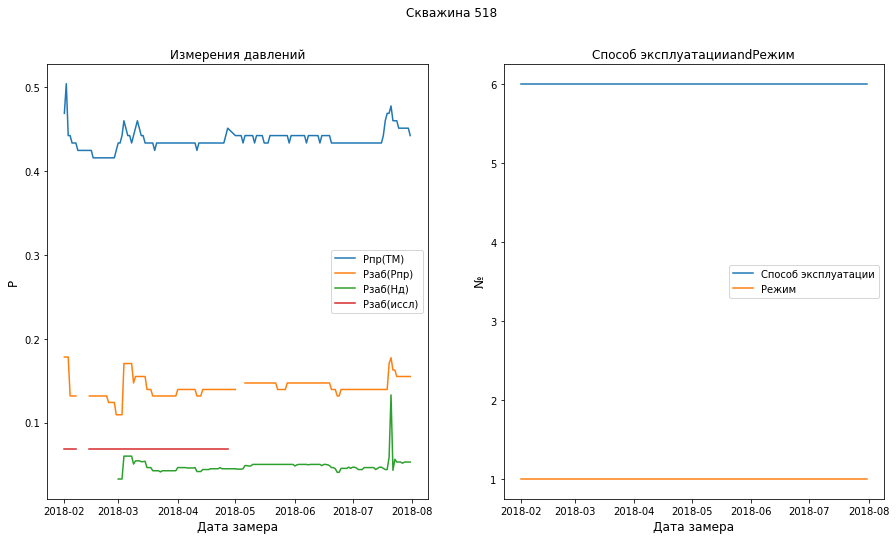

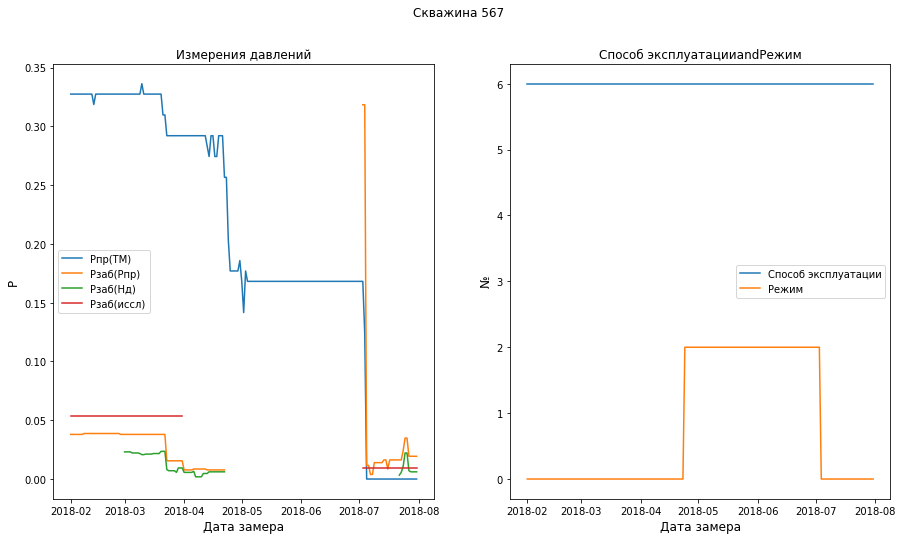

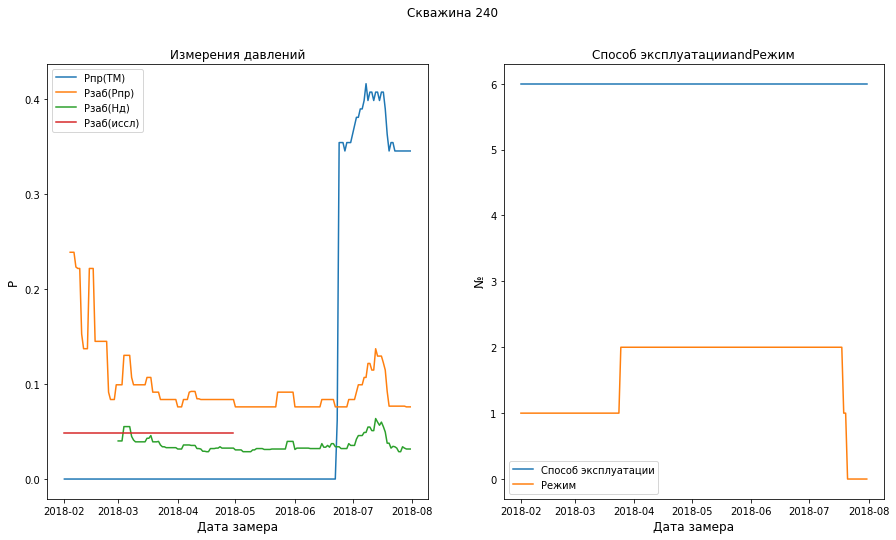

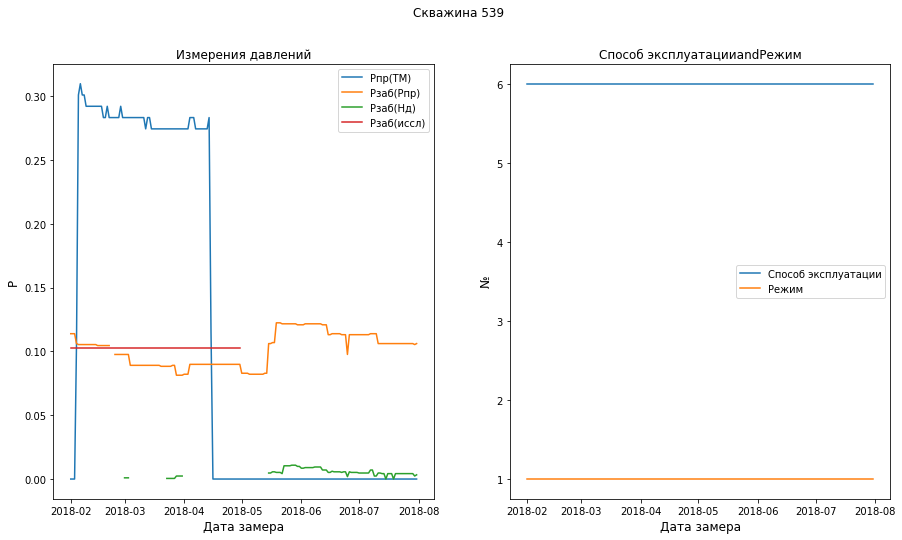

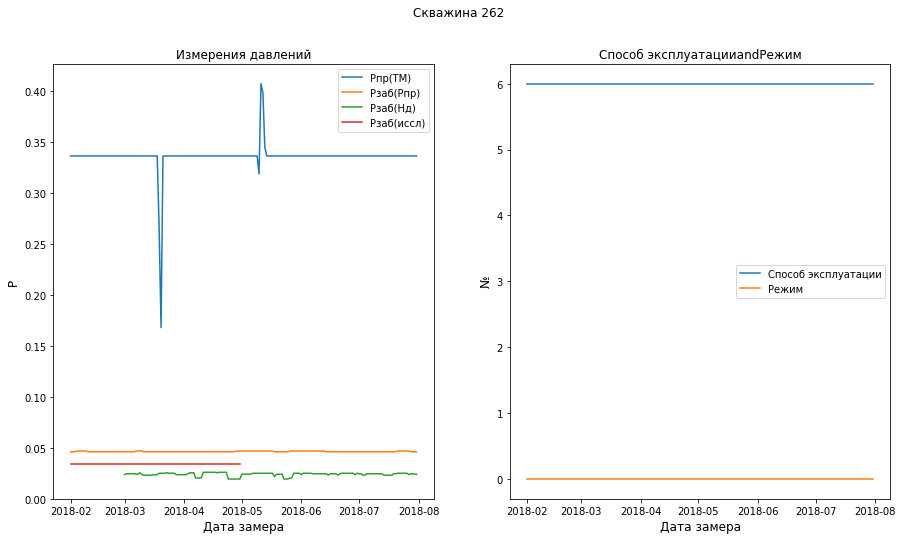

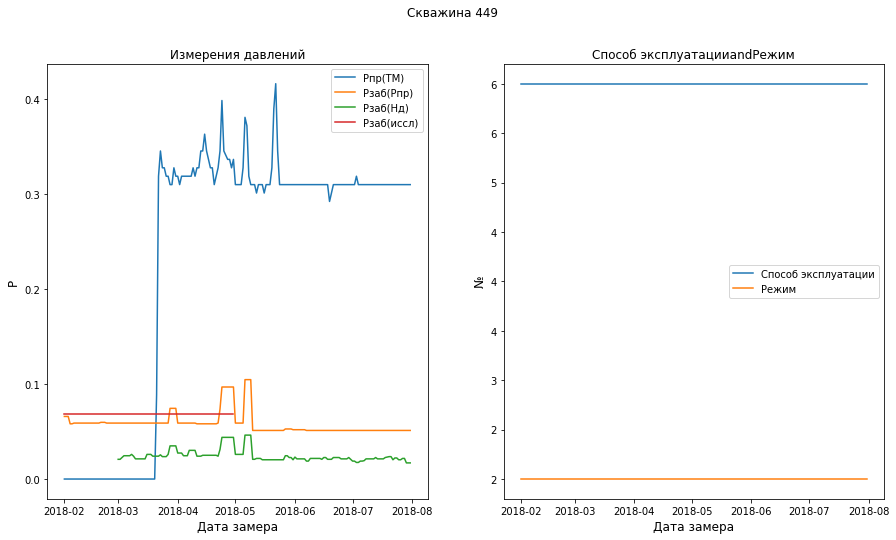

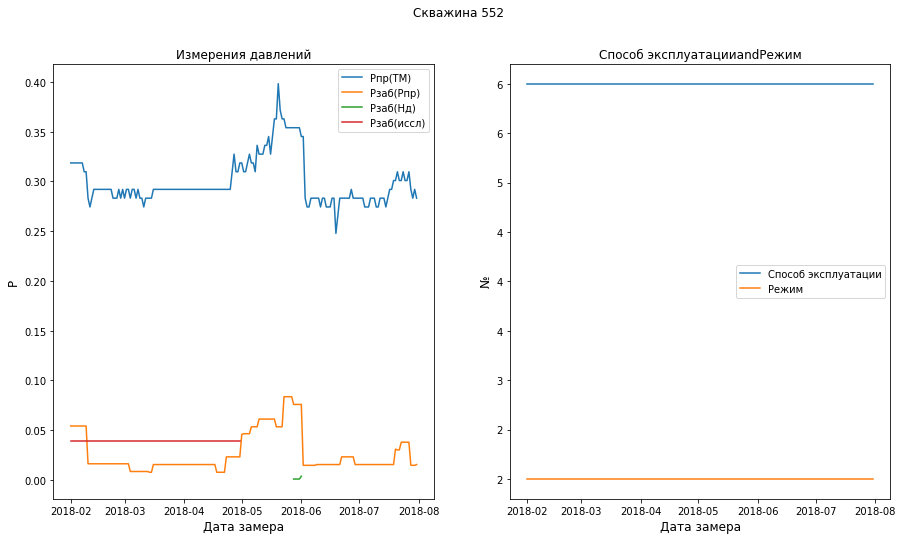

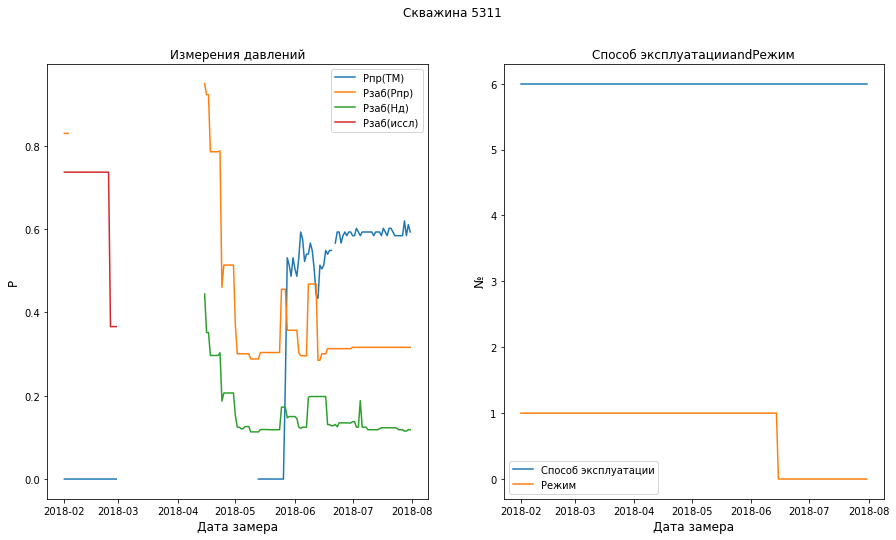

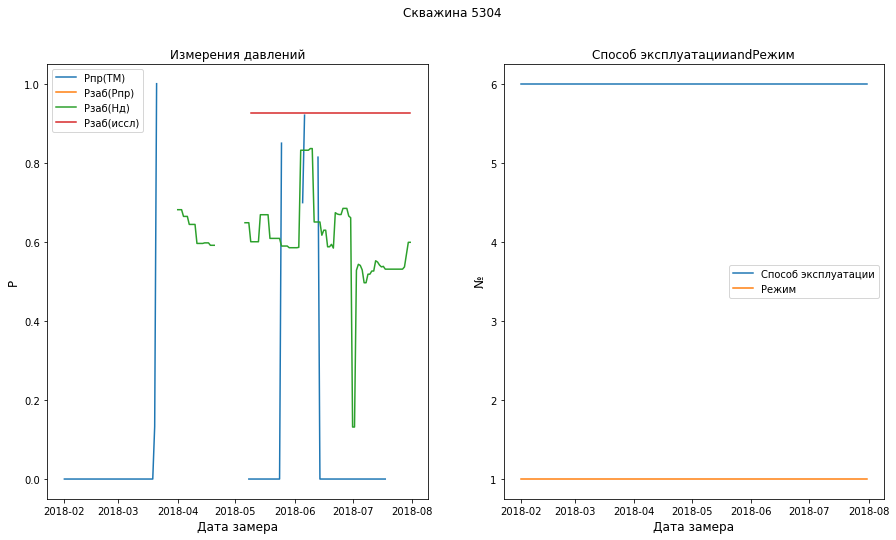

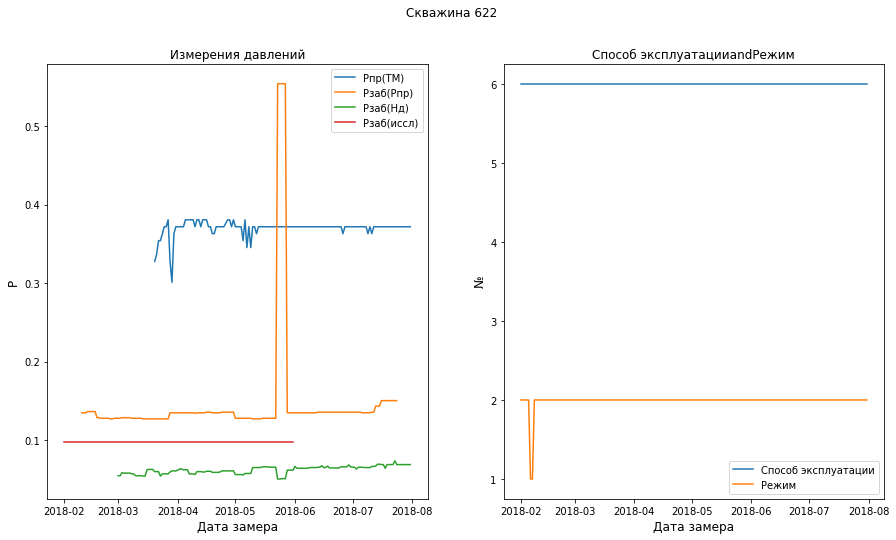

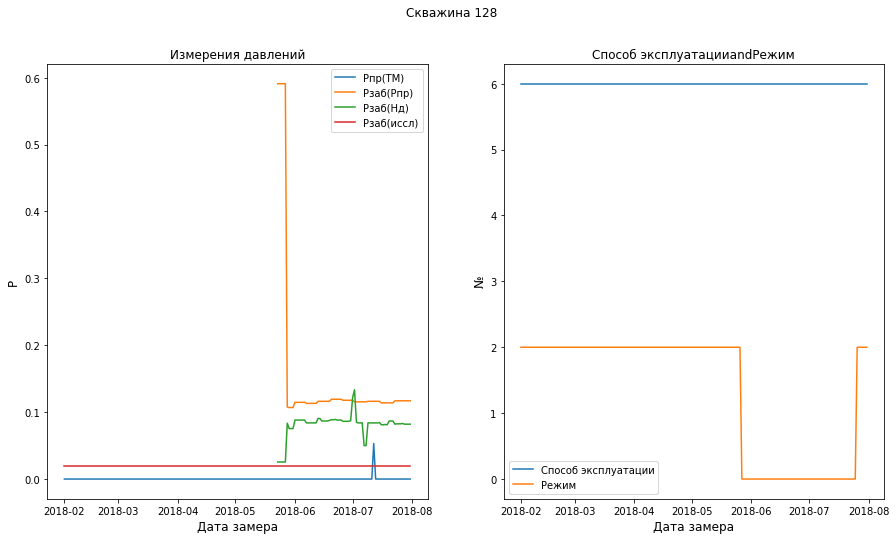

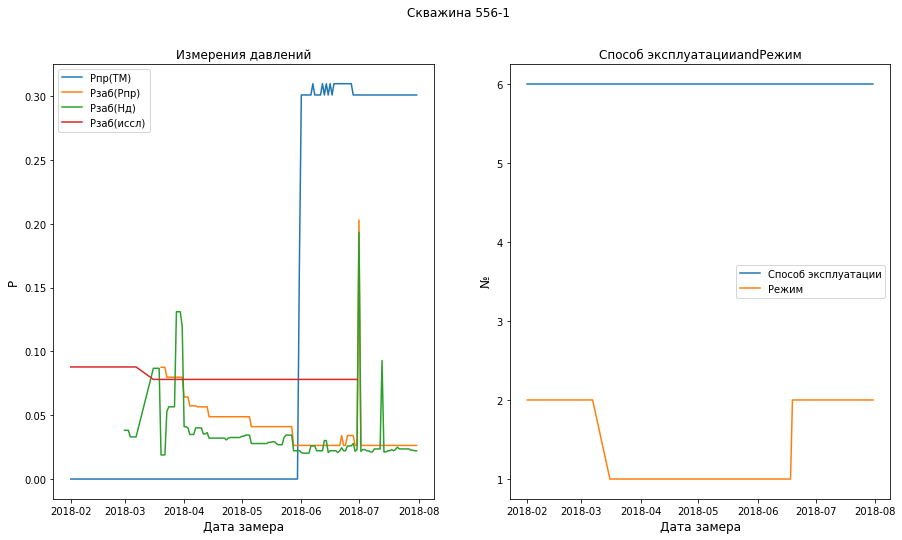

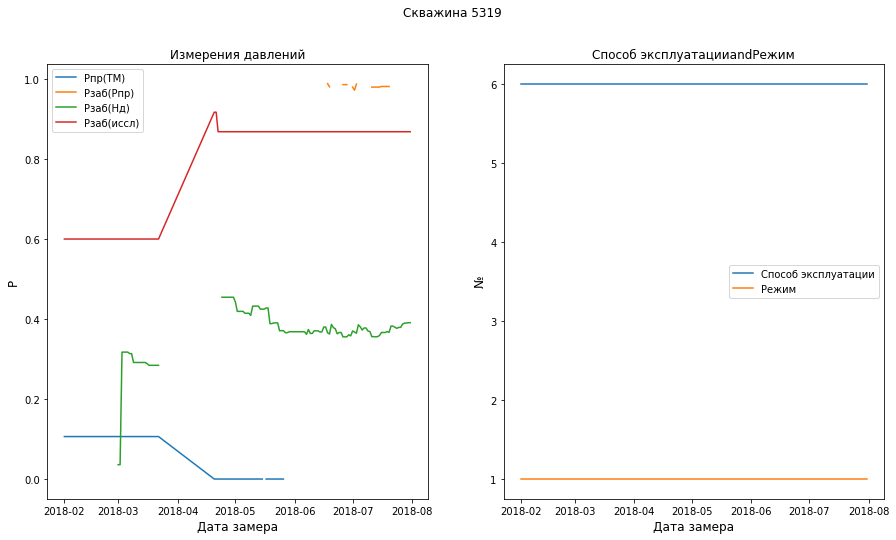

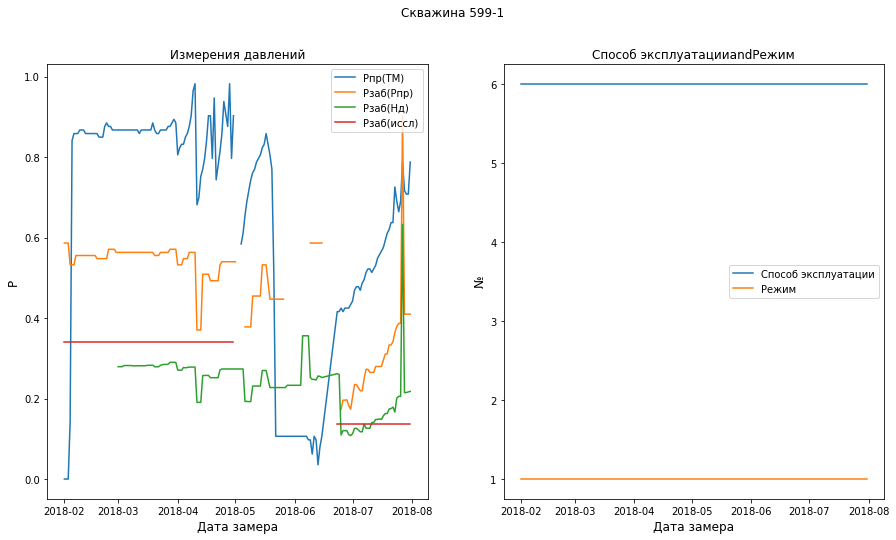

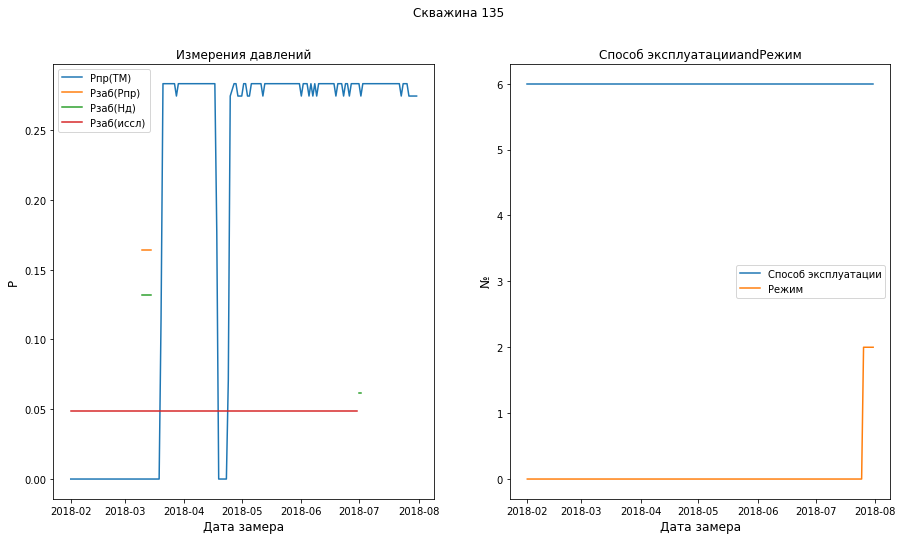

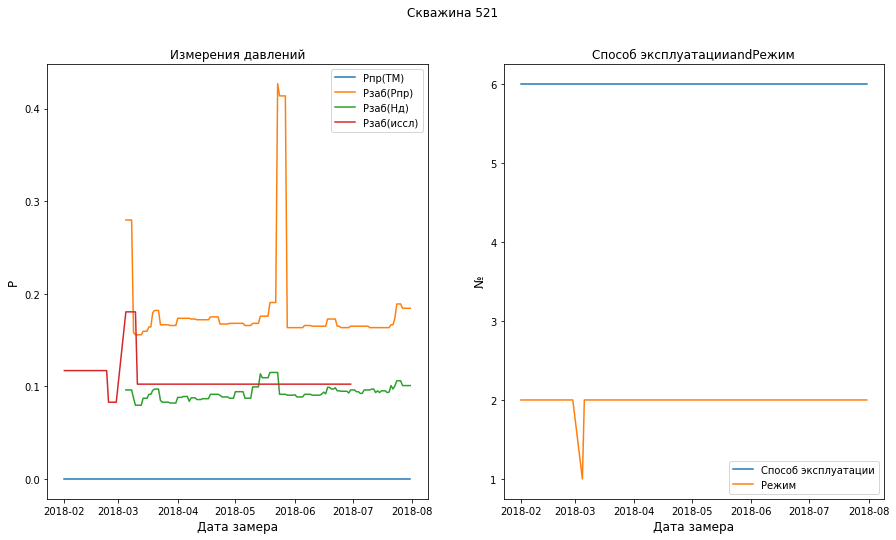

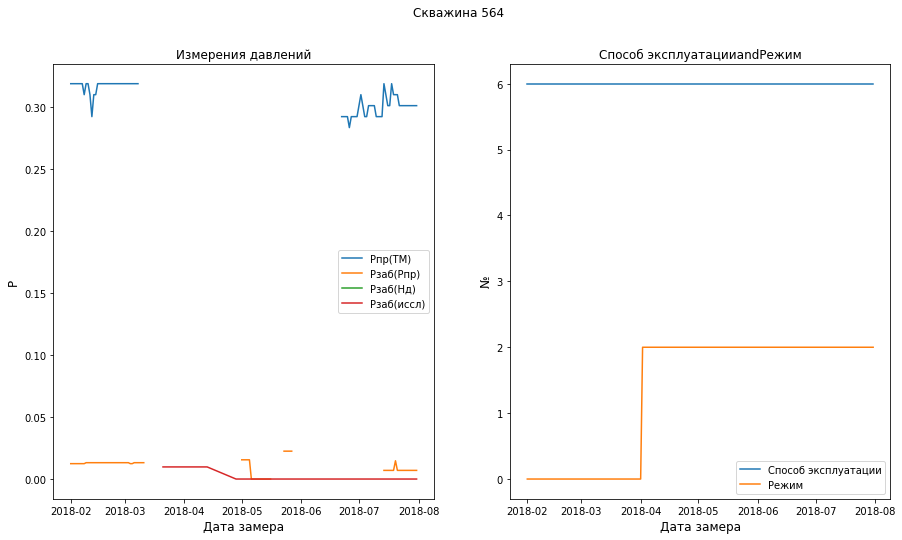

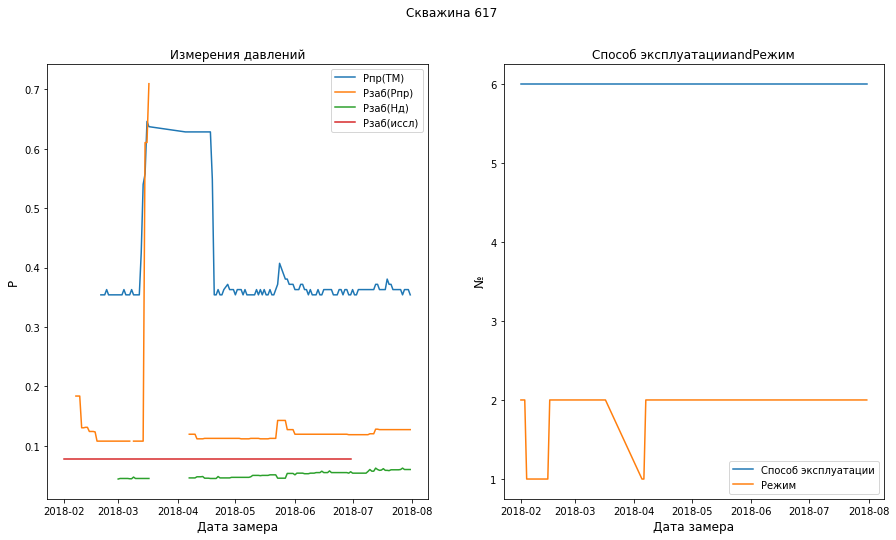

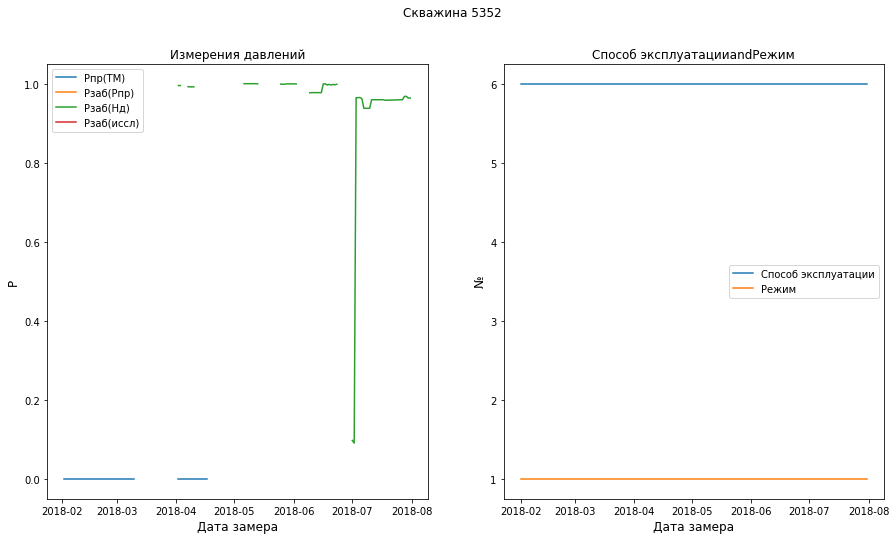

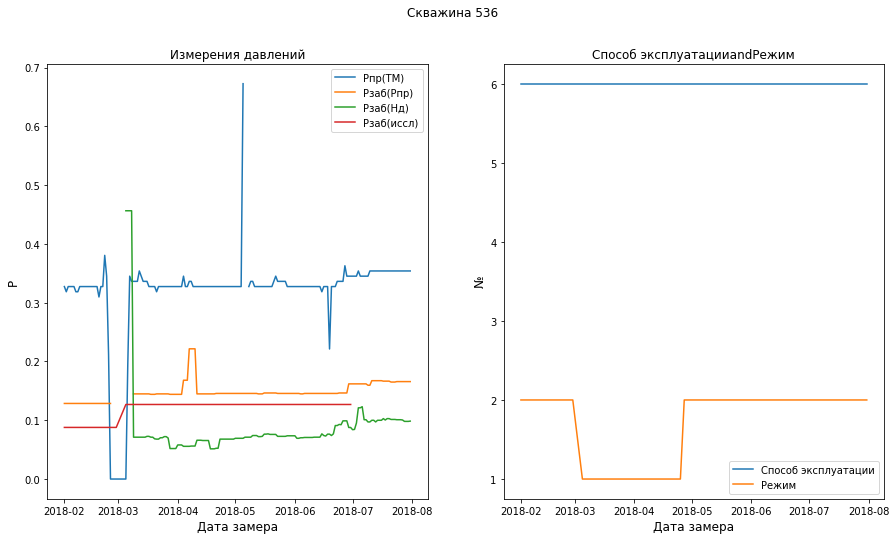

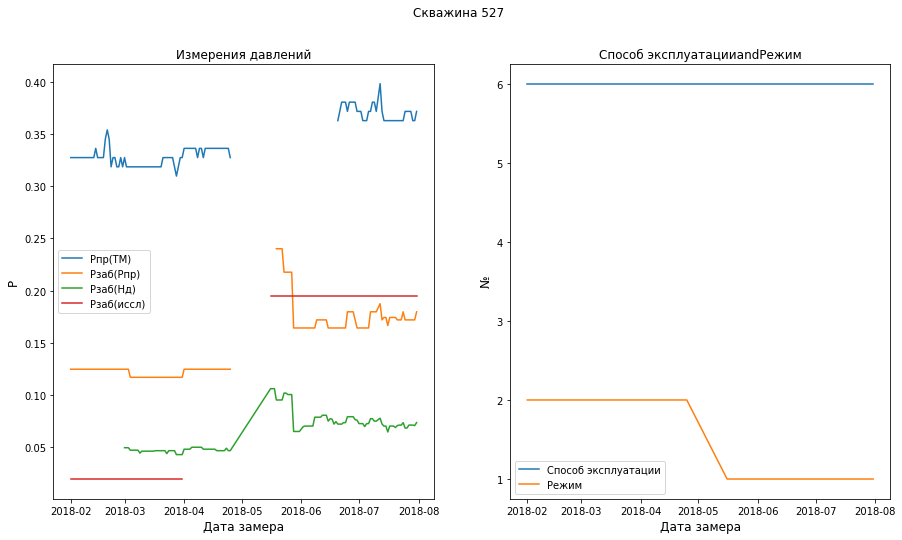

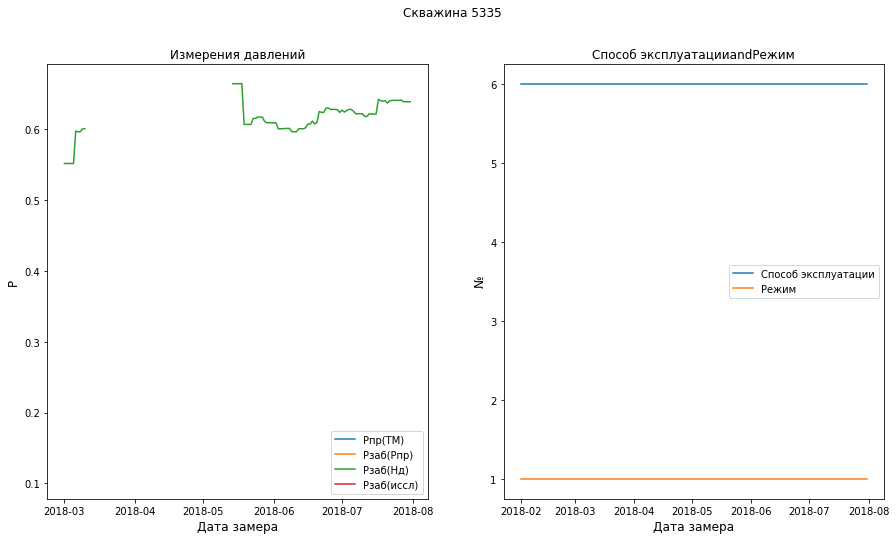

In [51]:
#для быстрого взгляда на графики
for h in targets.index.unique():
    draw_plot(h, final[final[hole] == h], what_to_do = 'save' ) 

In [145]:
print(cats_x1)
print(cats_x2)

Index(['Газлифт', 'По НКТ с воронкой', 'По НКТ с пакером',
       'Прочие способы эксплуатации',
       'Установка электроцентробежная для подачи воды', 'Фонтанный',
       'Электропогружным насосом'],
      dtype='object')
Index(['АПВ', 'ПДФ', 'ПКВ'], dtype='object')


In [40]:
def print_hist(df):
    for pr in Y:
        df[pr].hist(bins=20)
        plt.title(pr)
        plt.xlabel('Величина давления')
        plt.ylabel('Количество измерений')
        plt.show()
        

In [10]:
def rolling(df, days):
    res = df.copy()
    for y in Y:
        res[y] = res[y].rolling(days).mean()
    return res

In [11]:
final_roll = rolling(final, 4)
load_before_influx(final_roll, 'rolled.csv')

NameError: name 'load_before_influx' is not defined

D:\anaconda\envs\foo\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


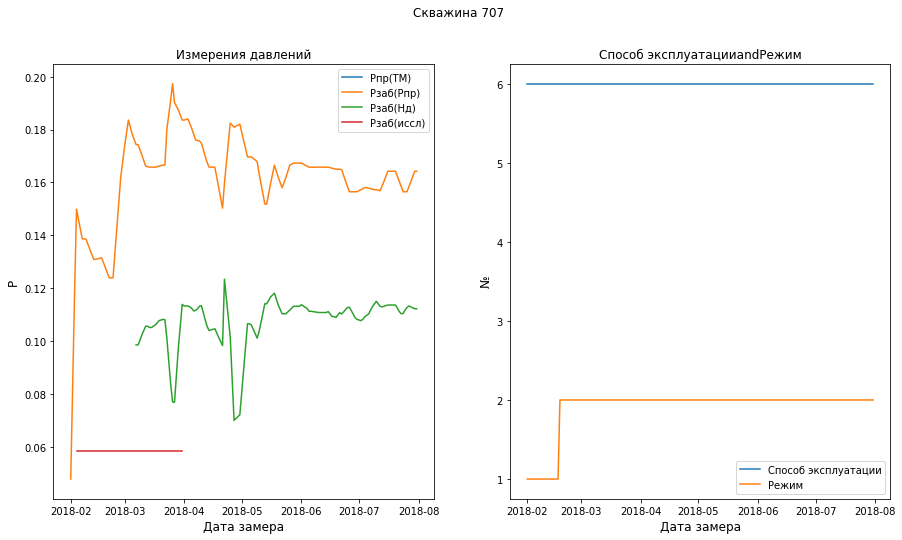

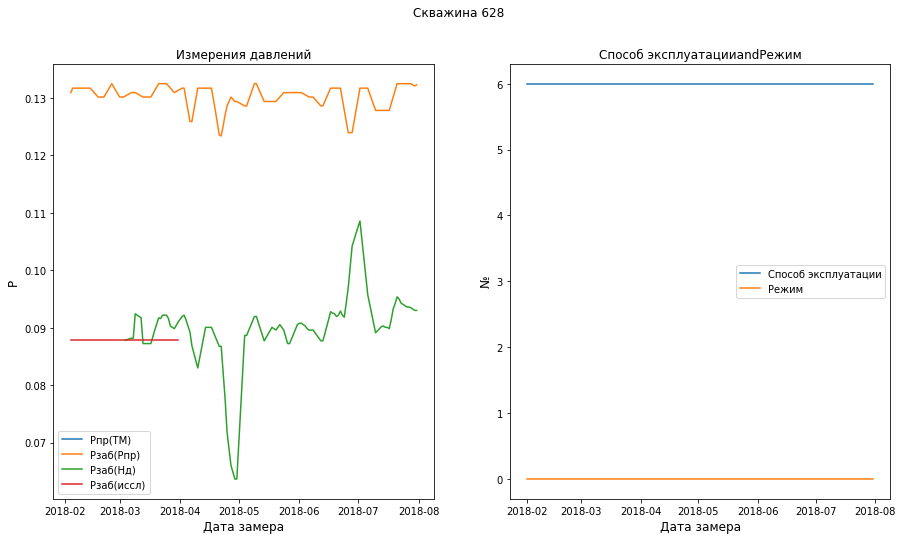

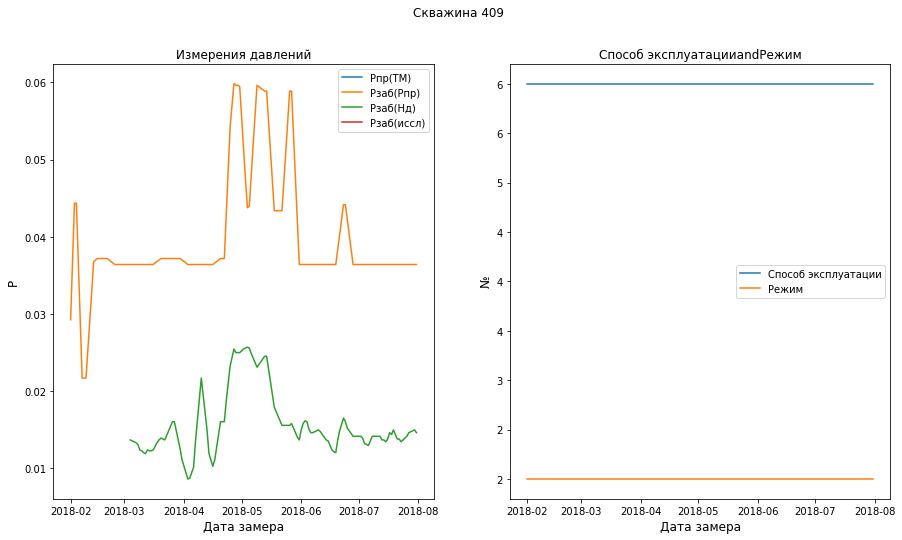

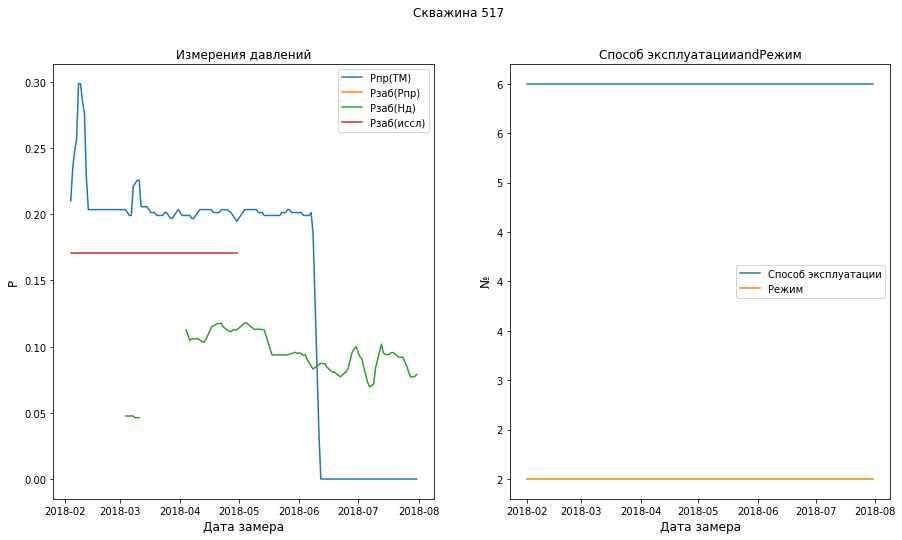

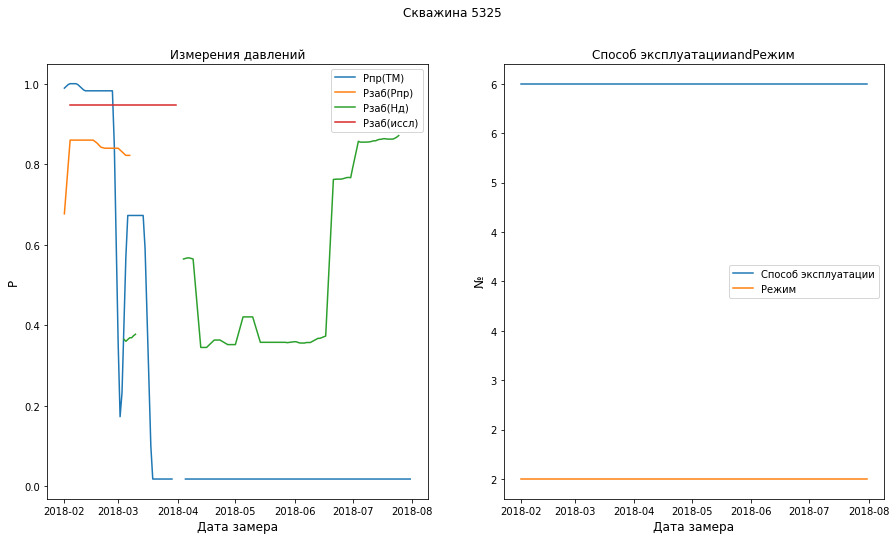

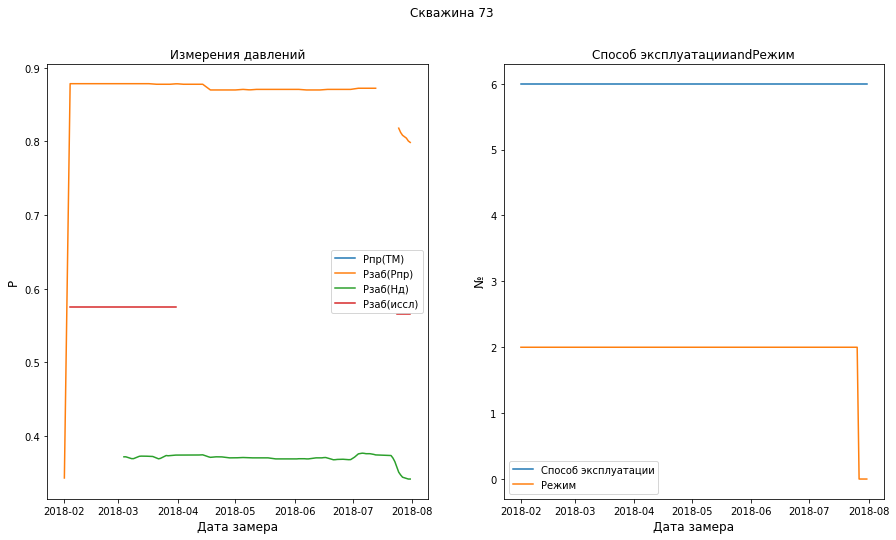

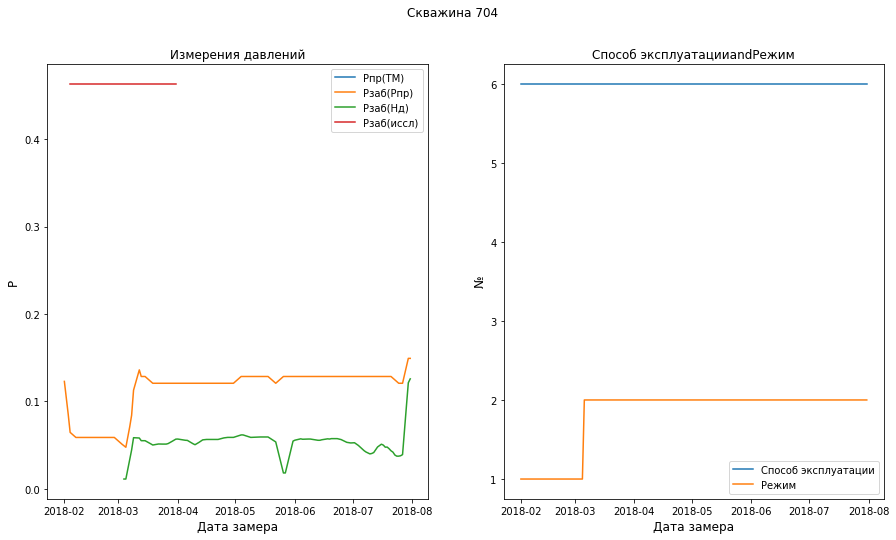

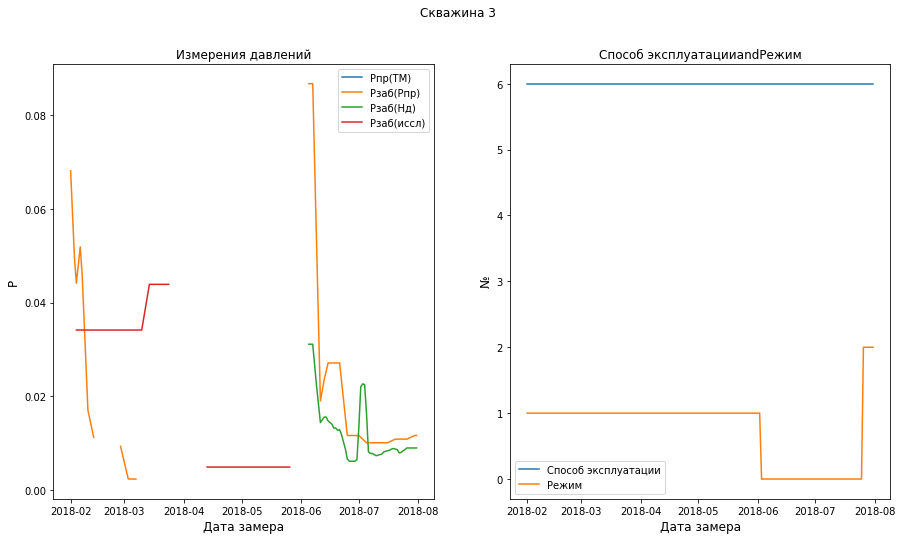

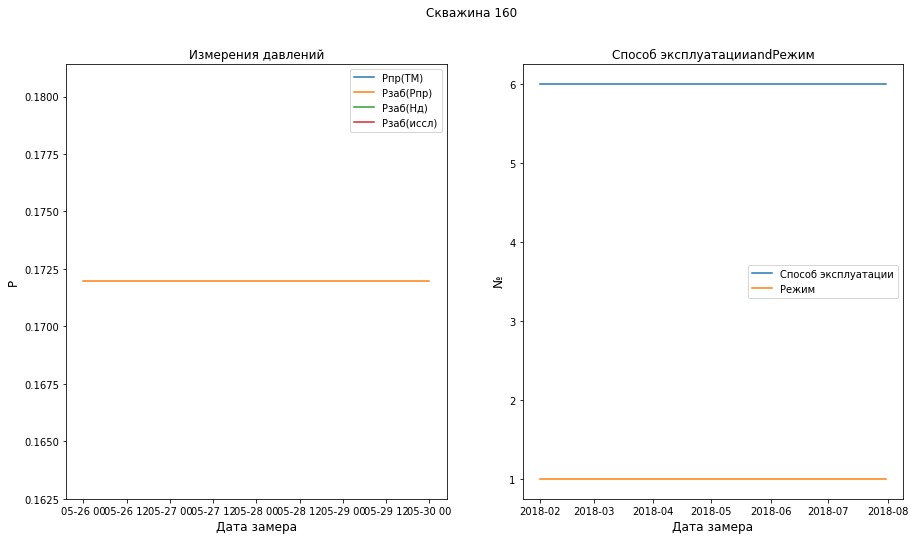

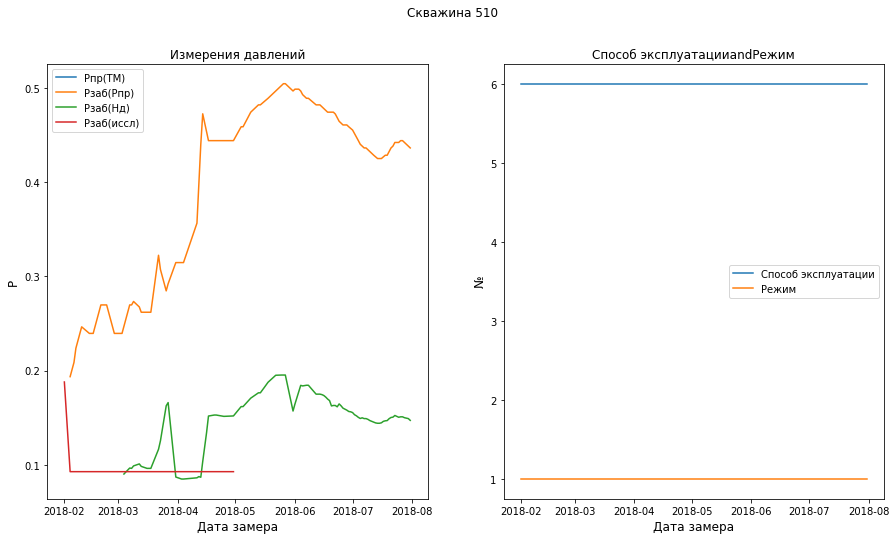

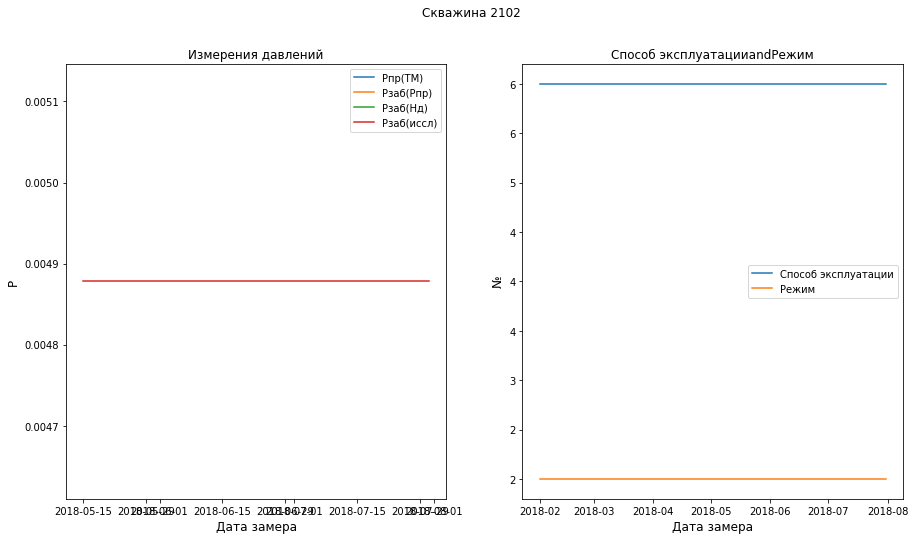

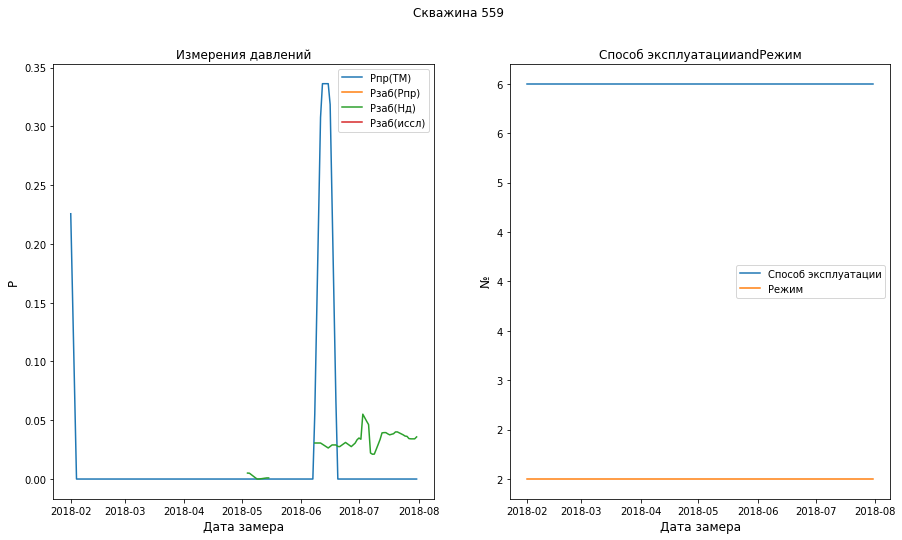

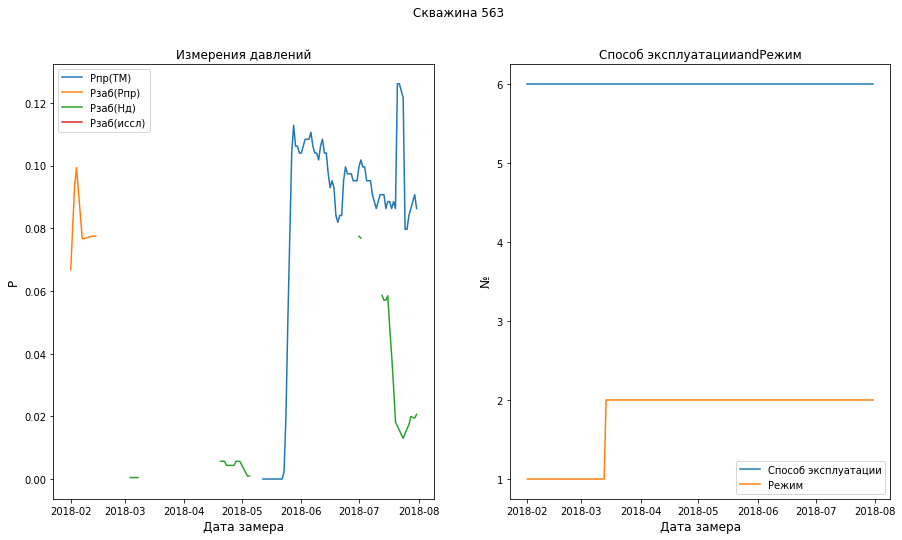

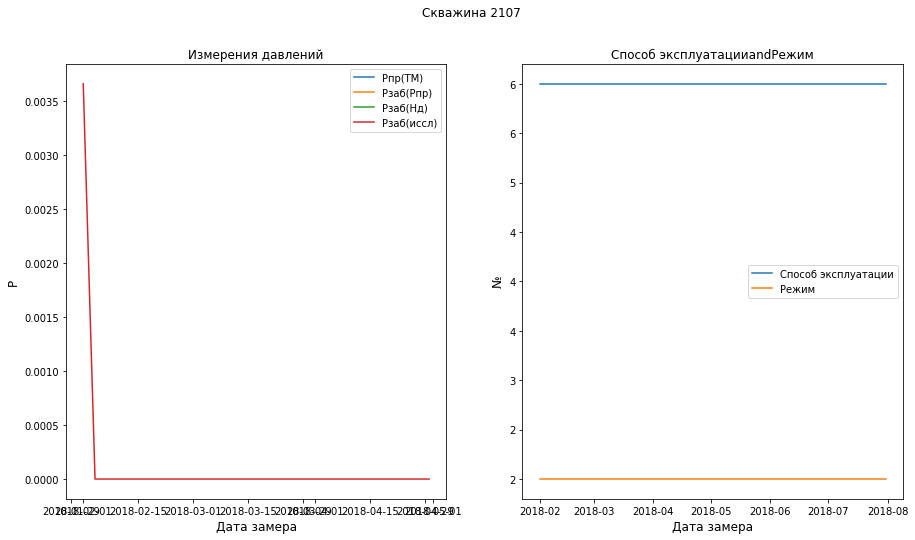

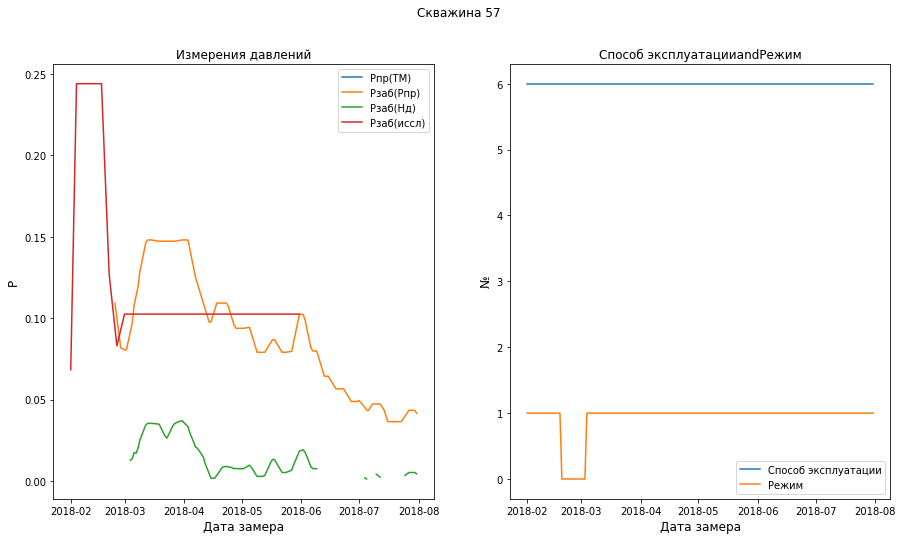

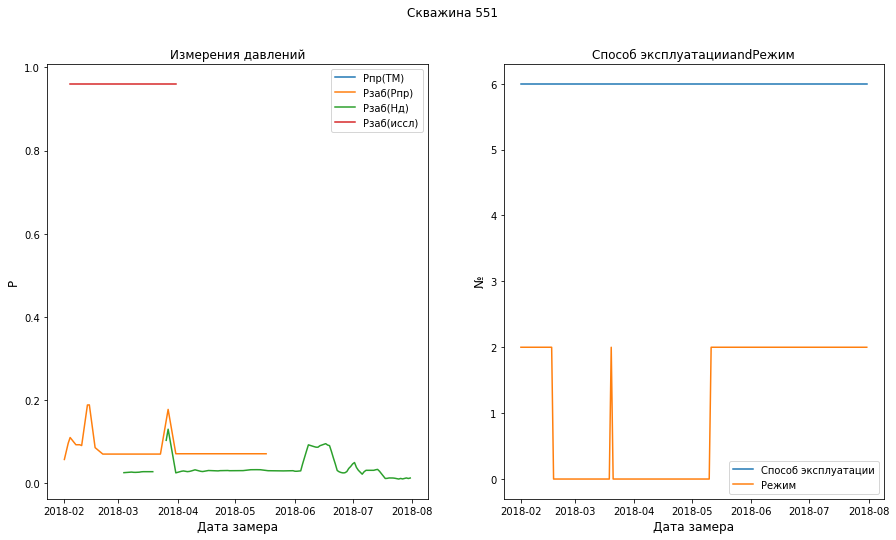

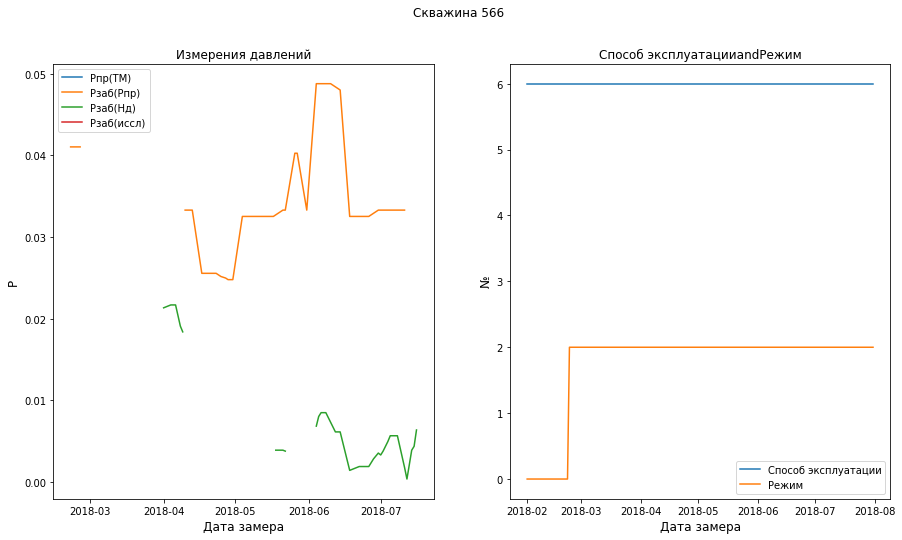

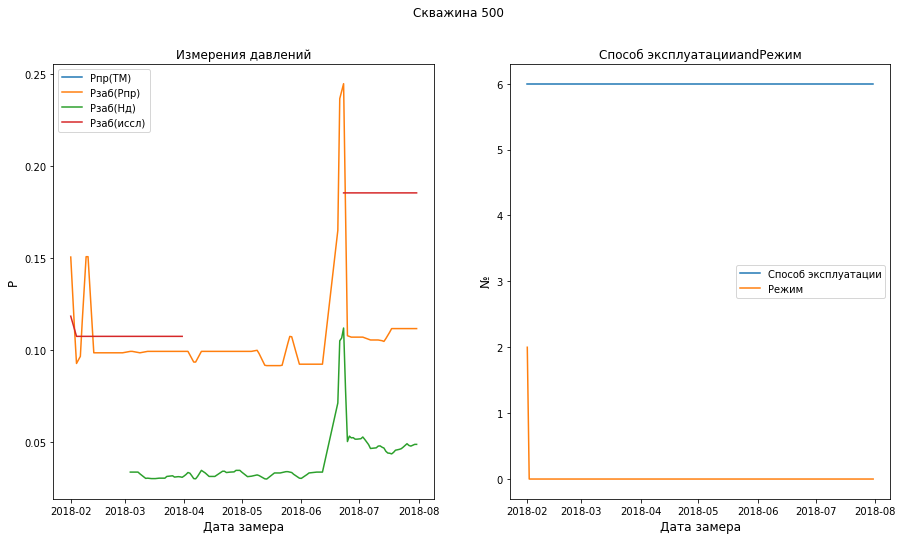

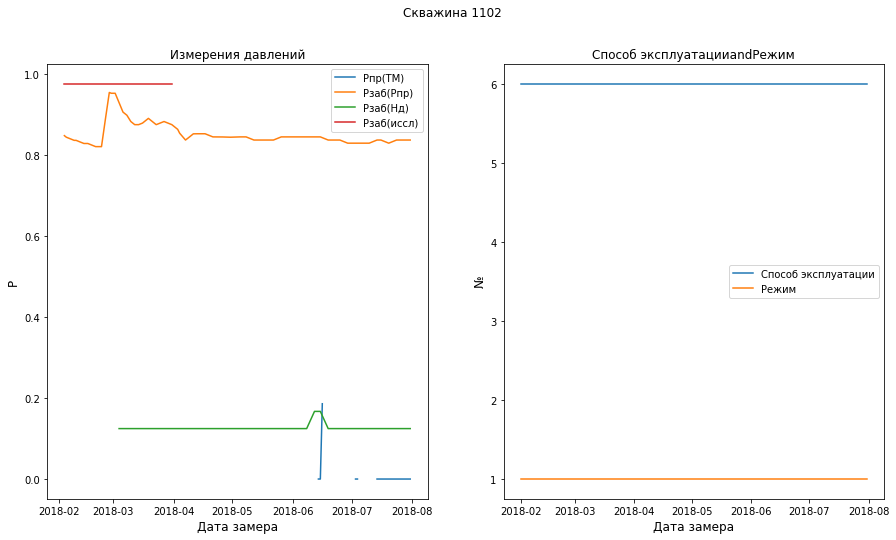

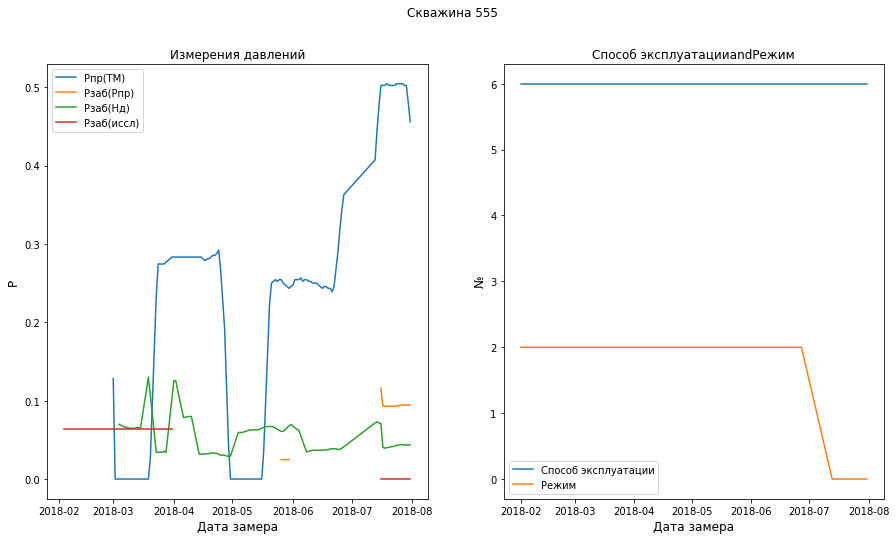

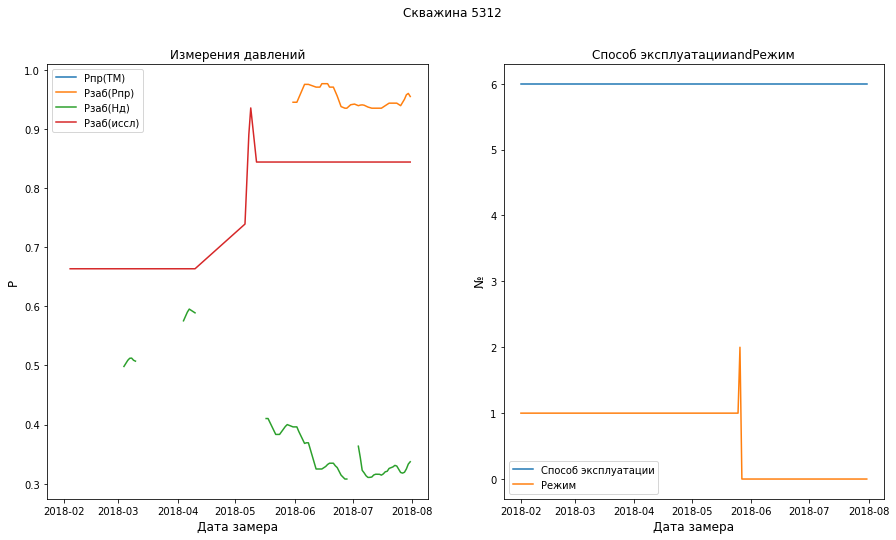

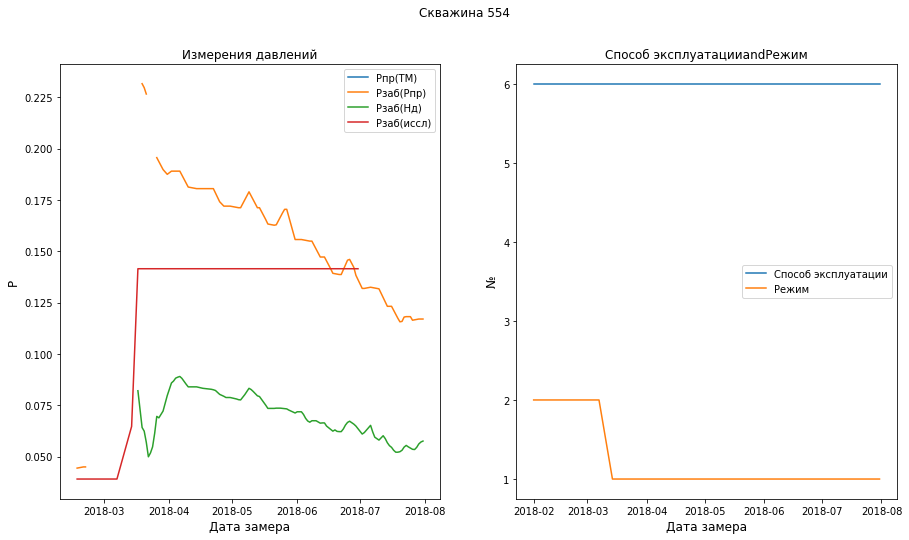

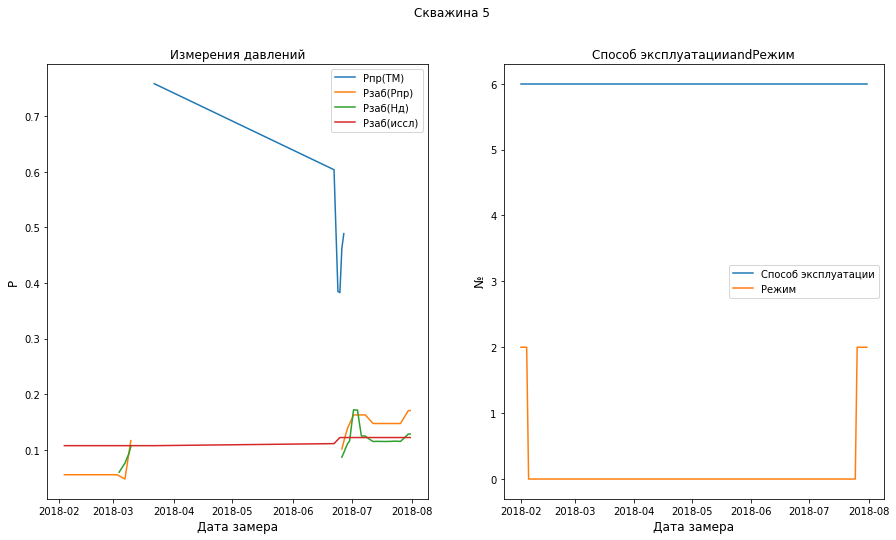

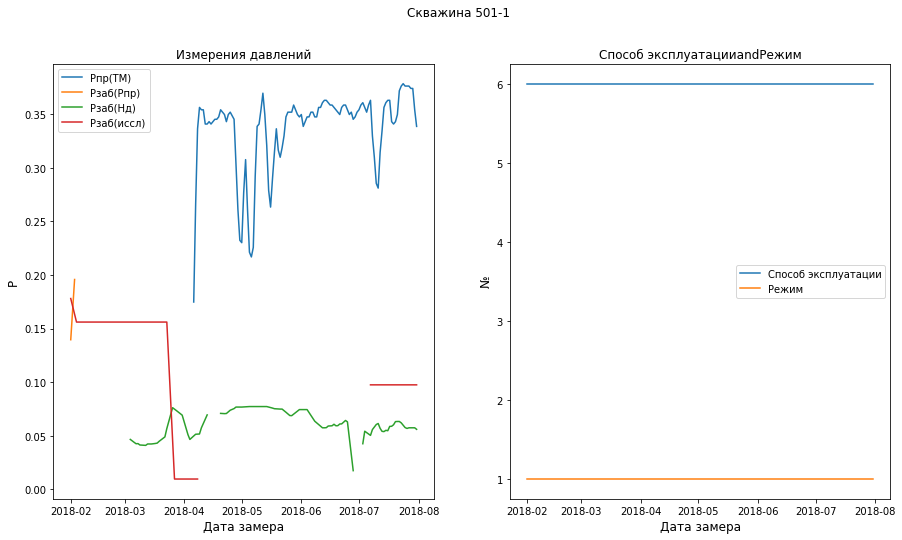

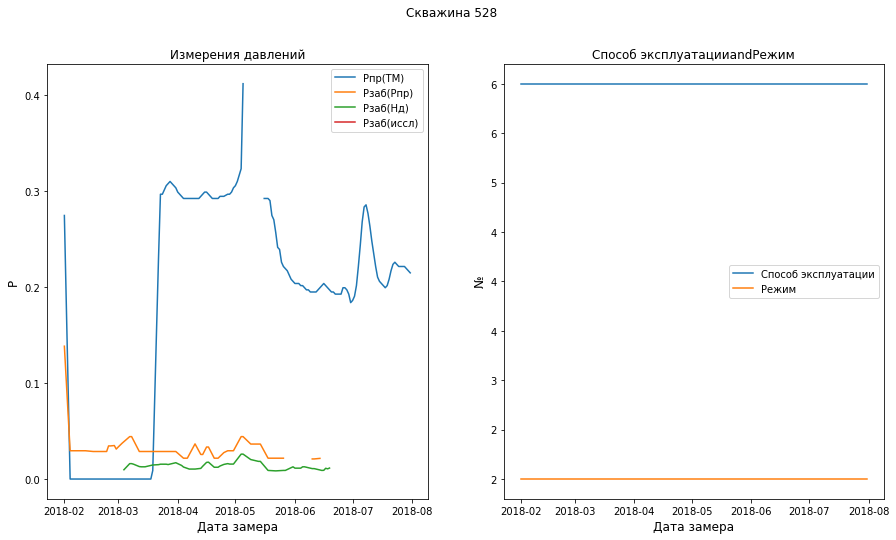

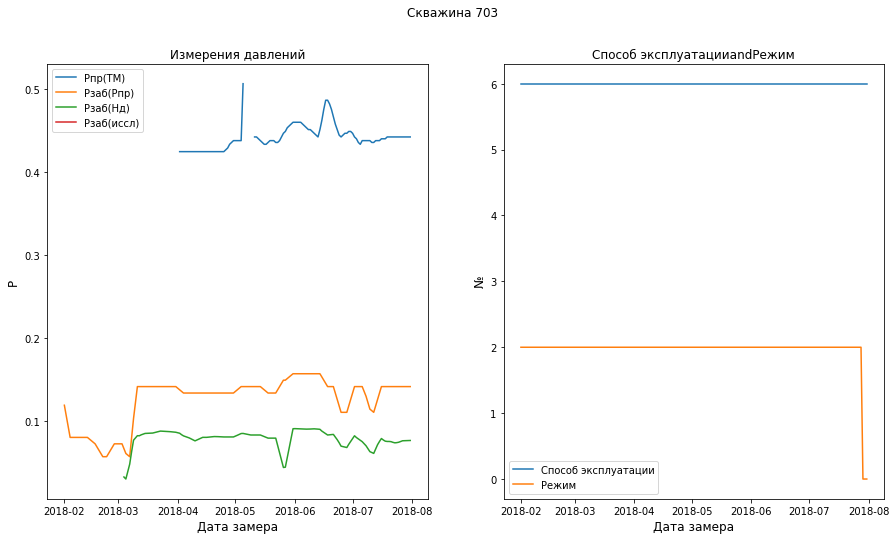

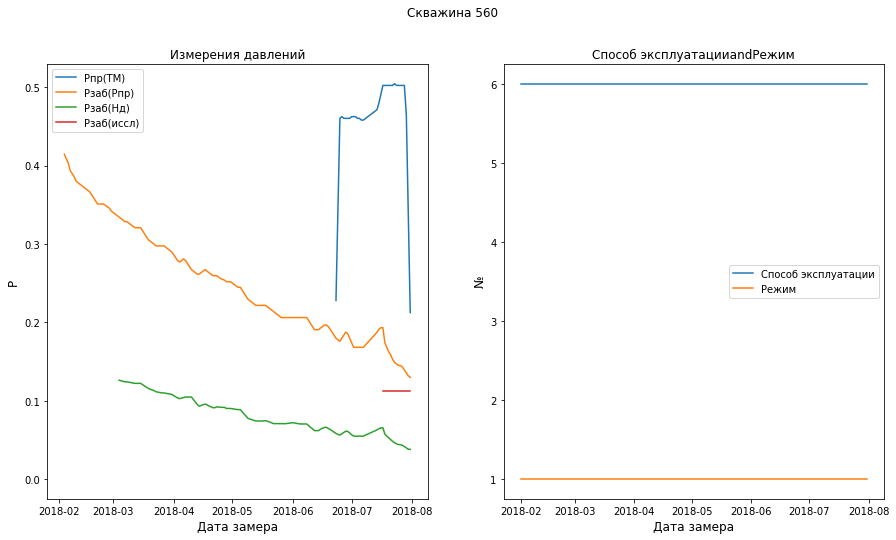

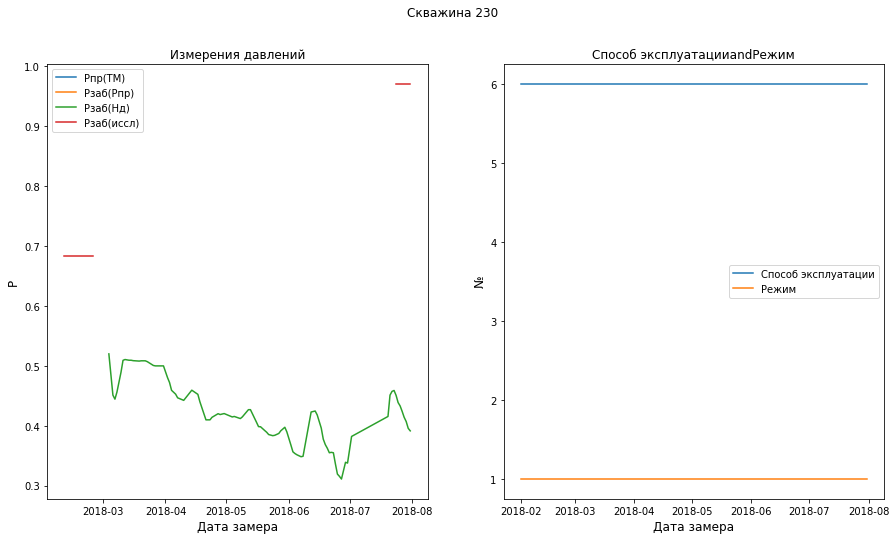

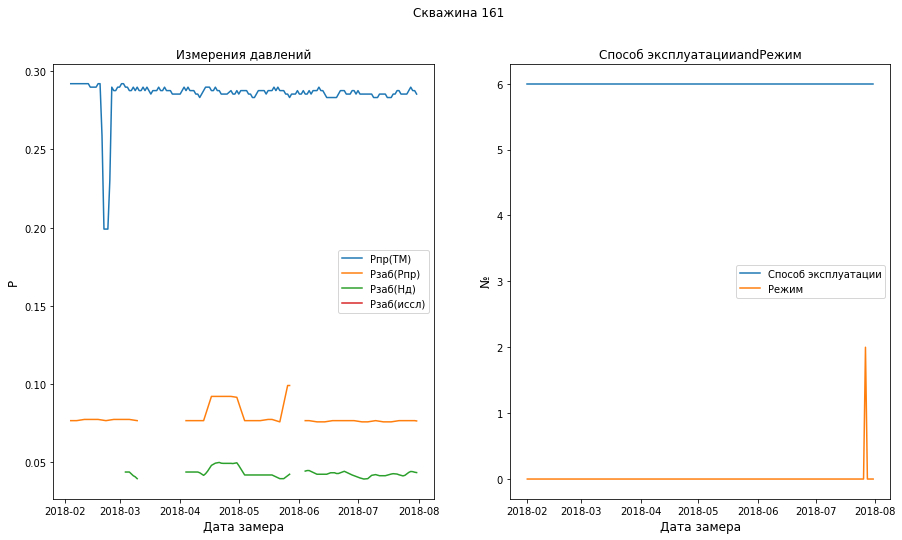

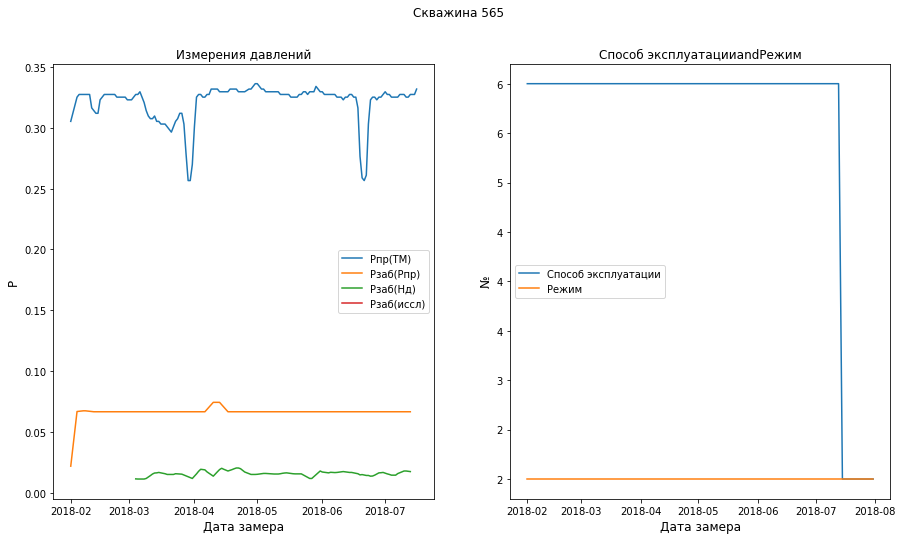

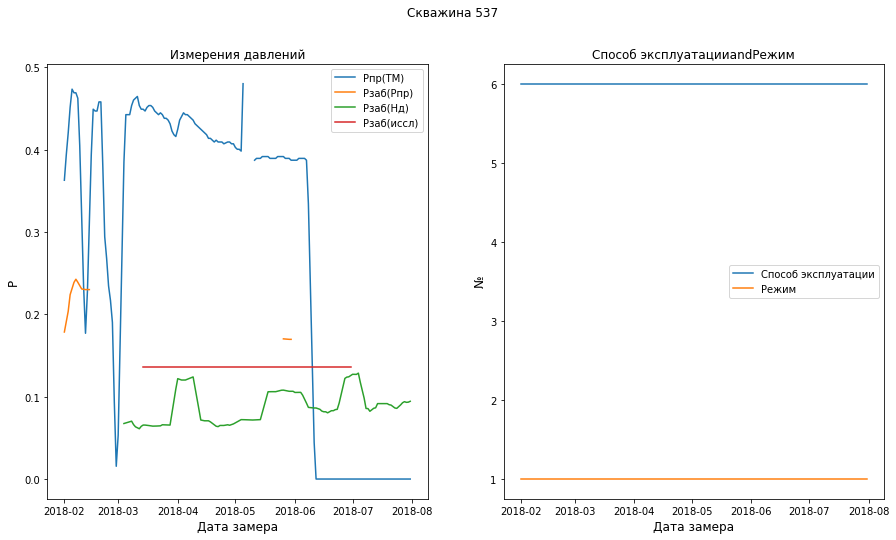

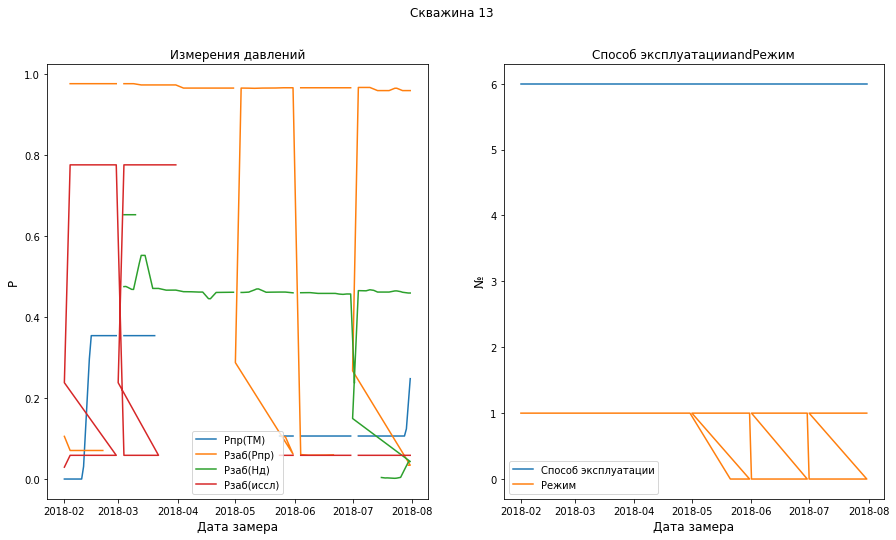

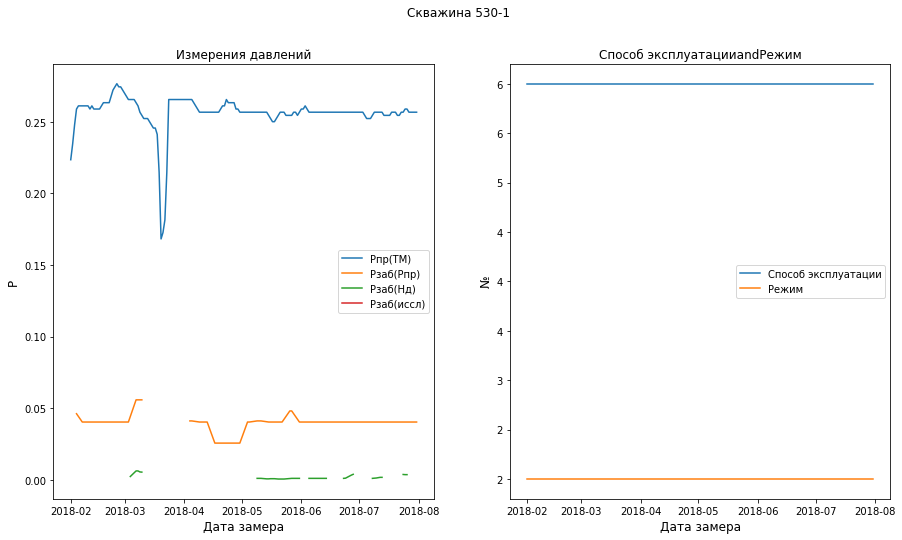

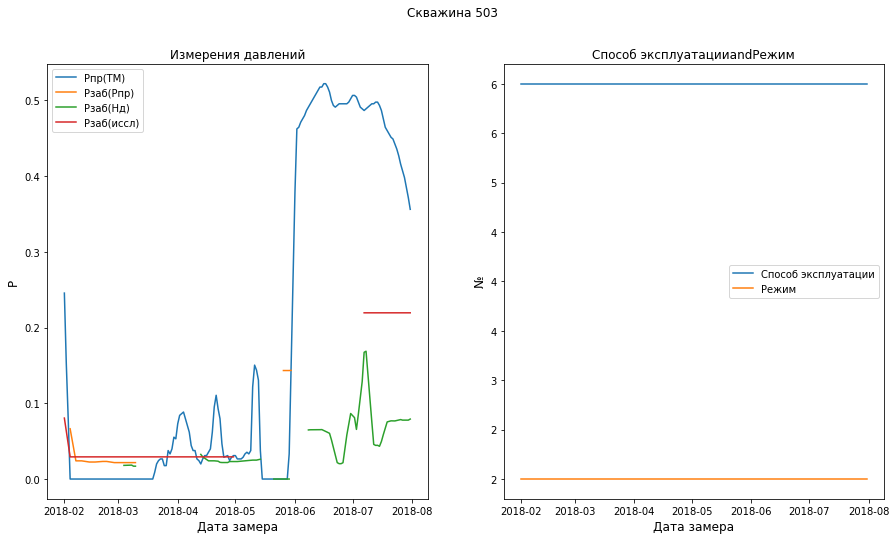

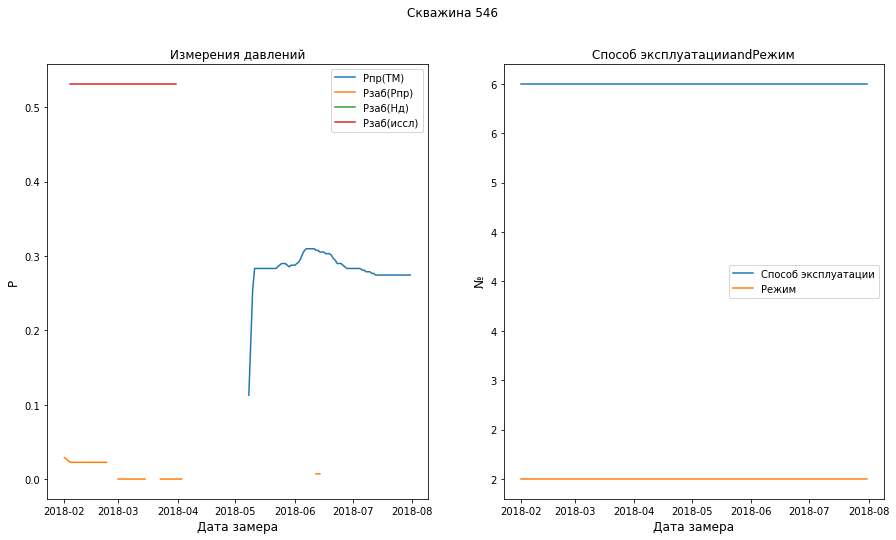

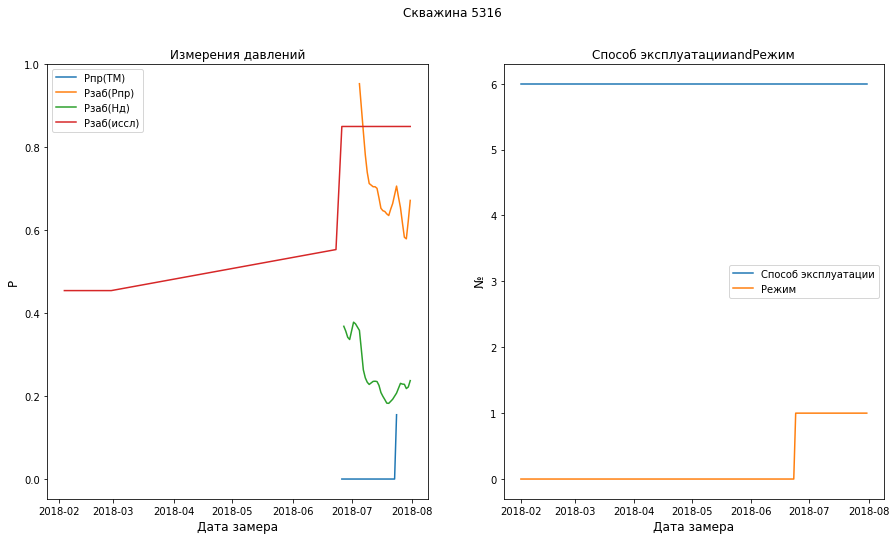

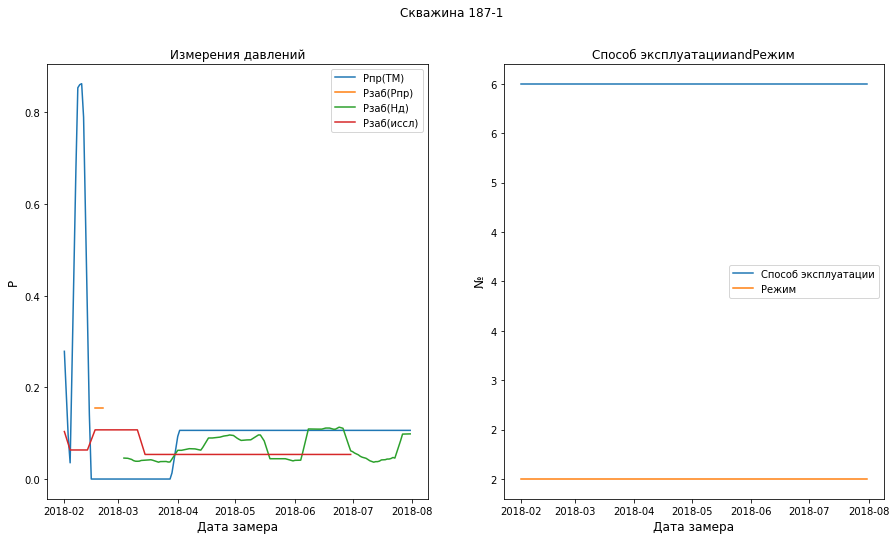

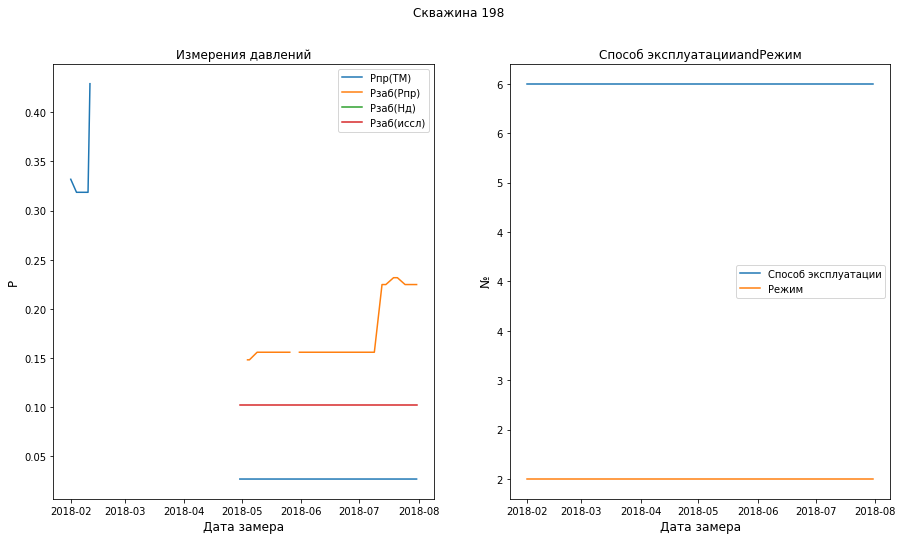

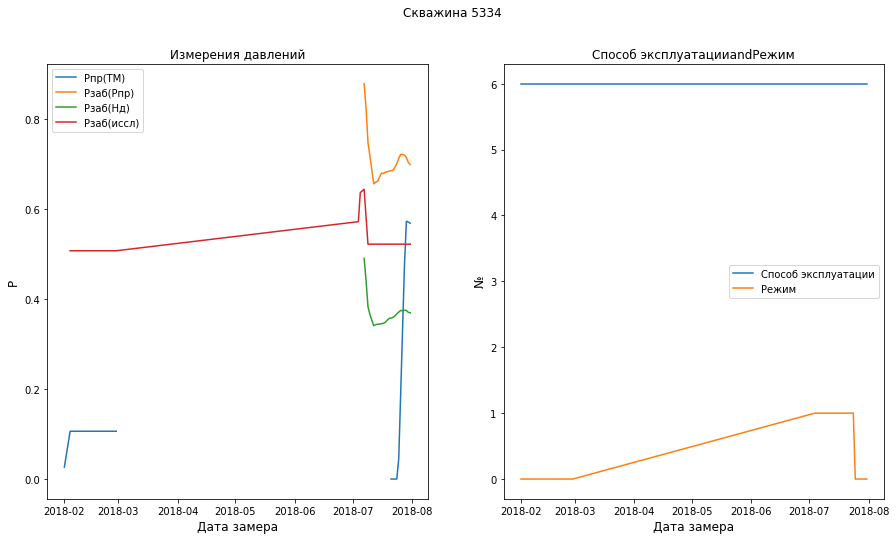

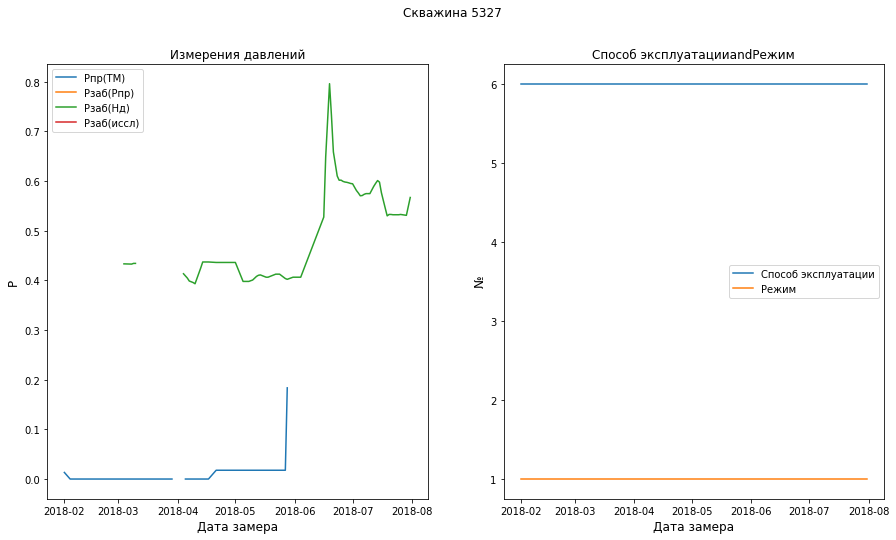

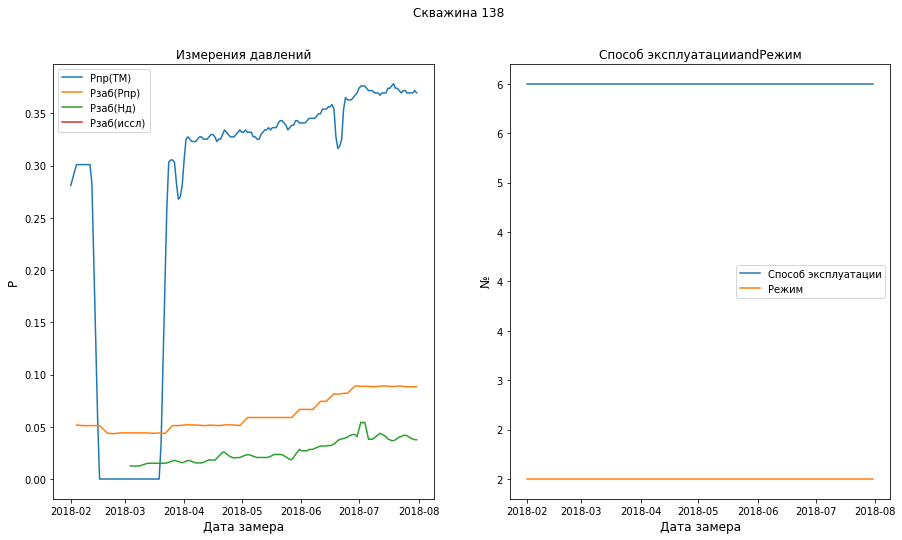

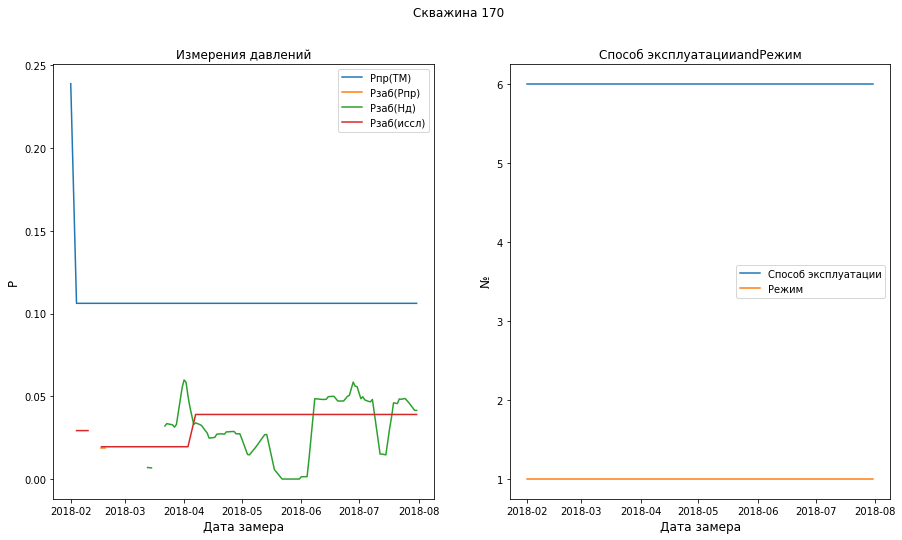

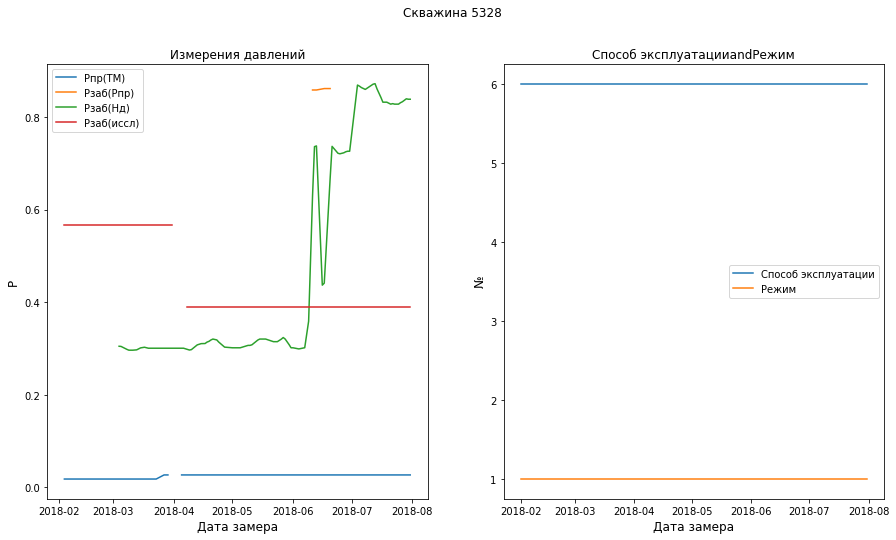

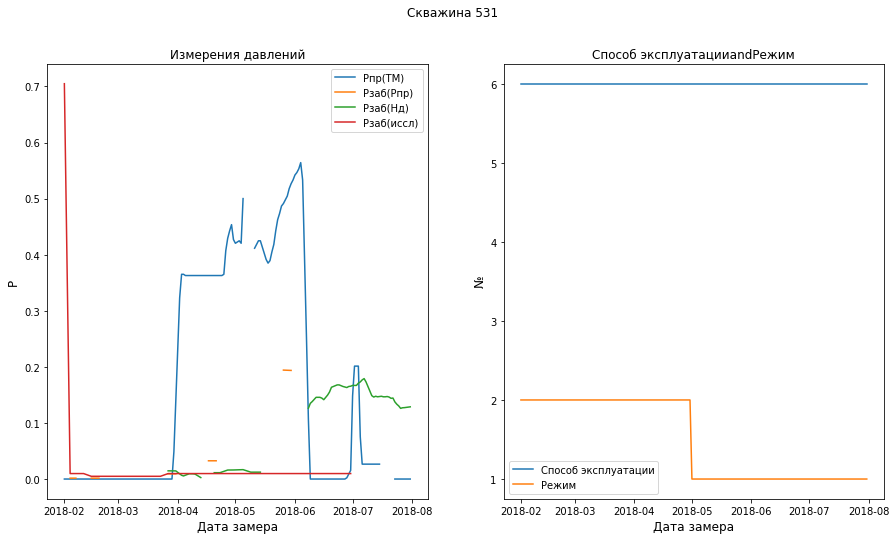

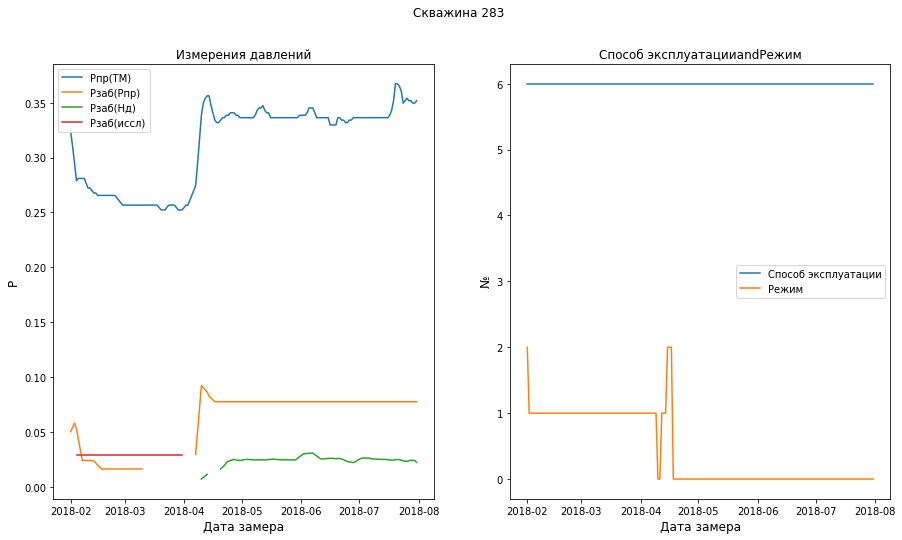

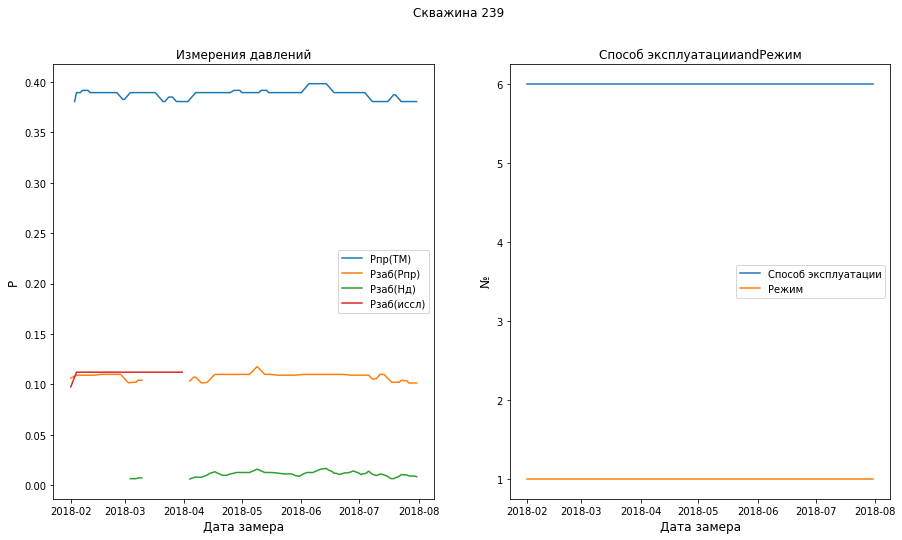

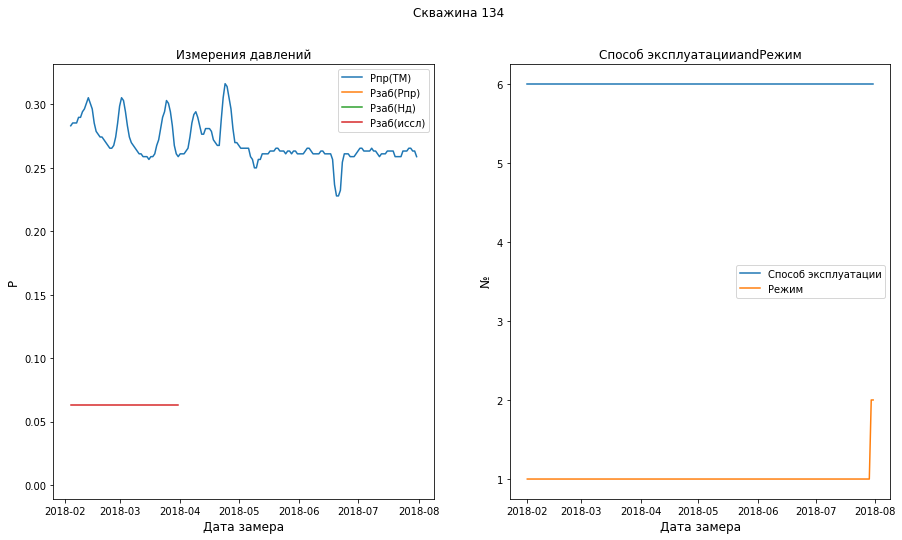

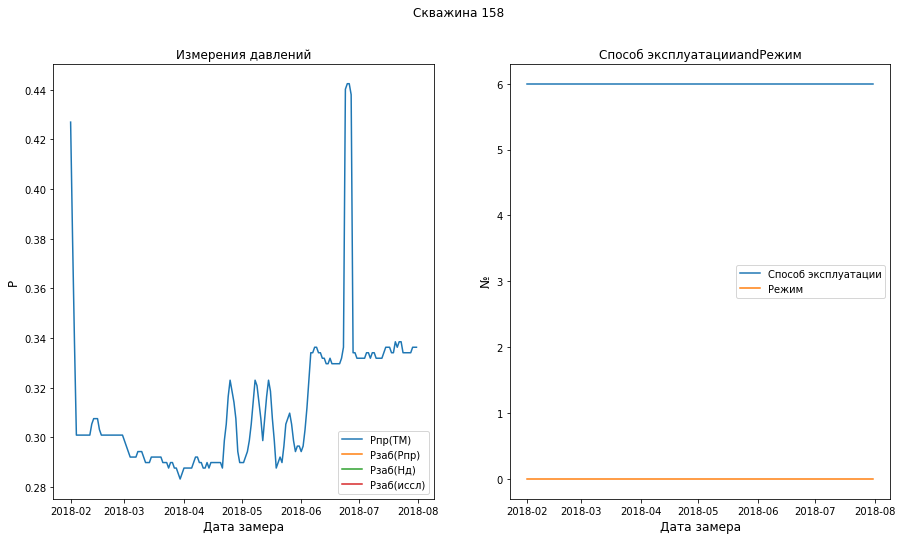

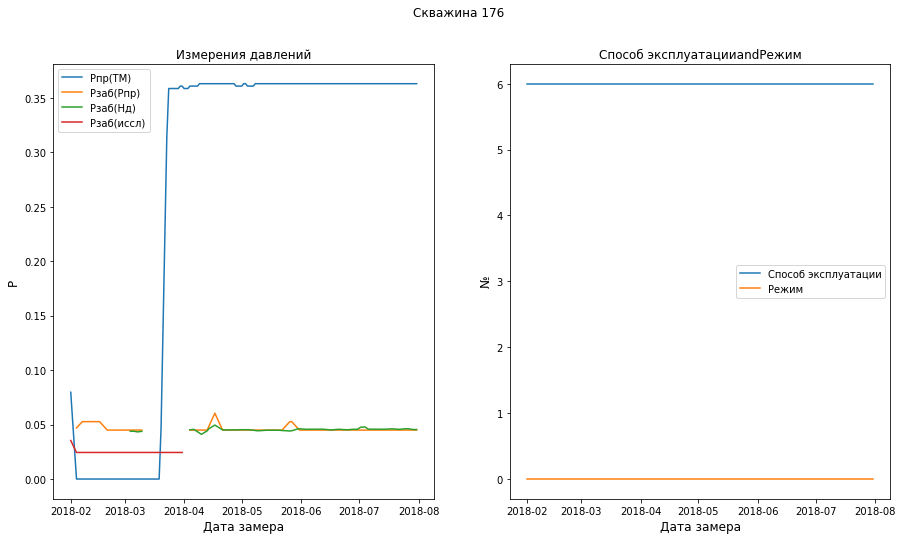

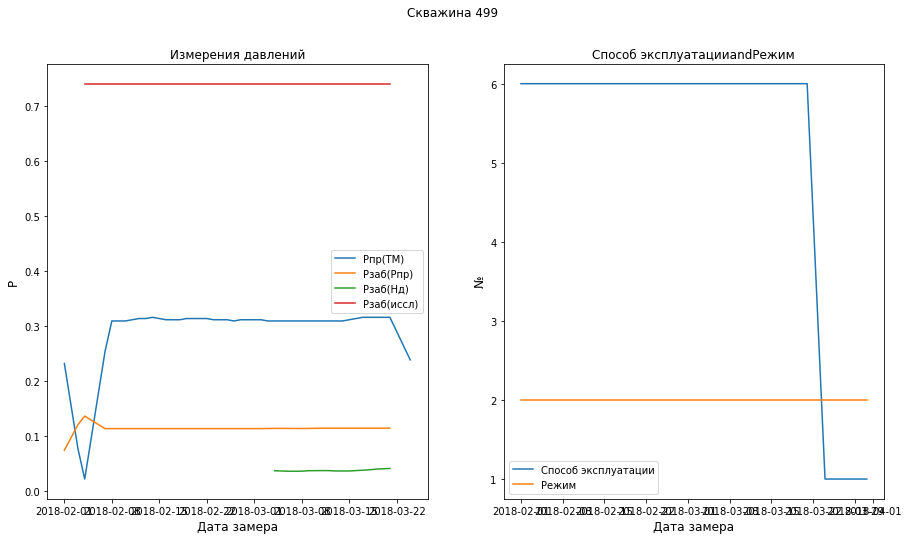

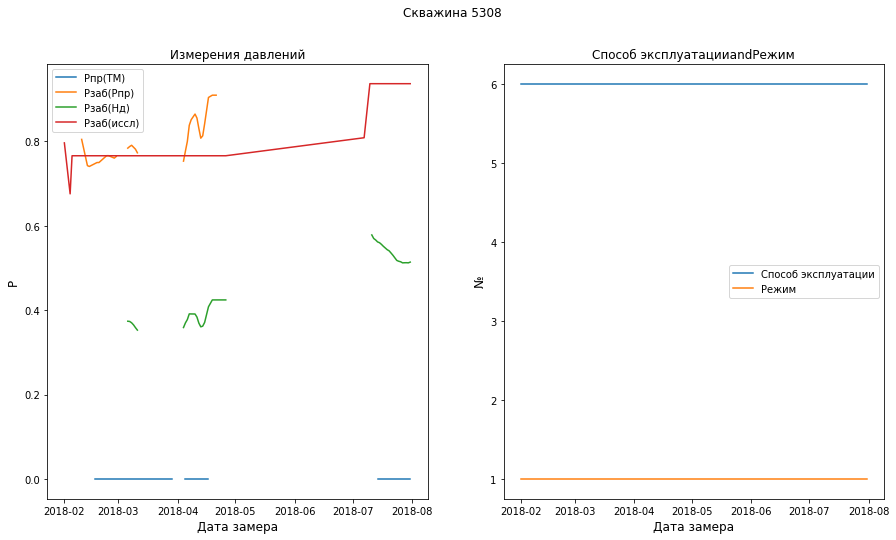

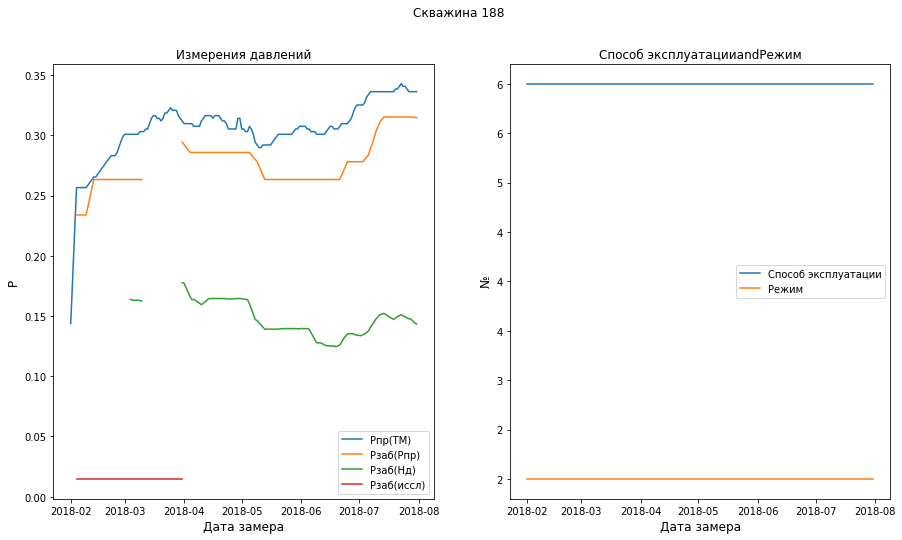

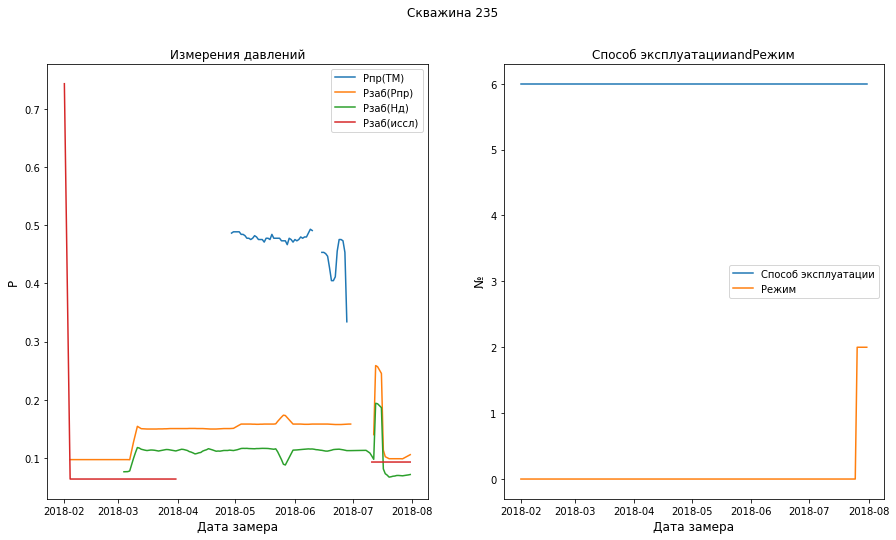

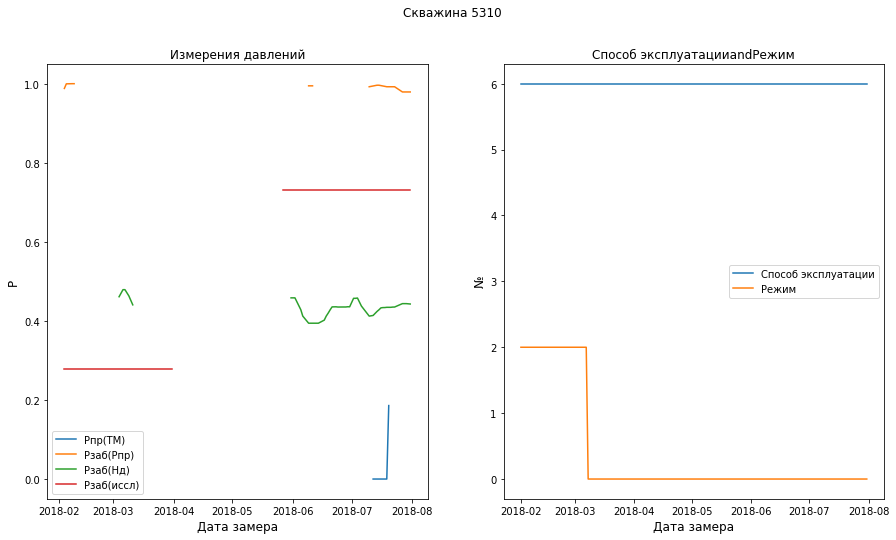

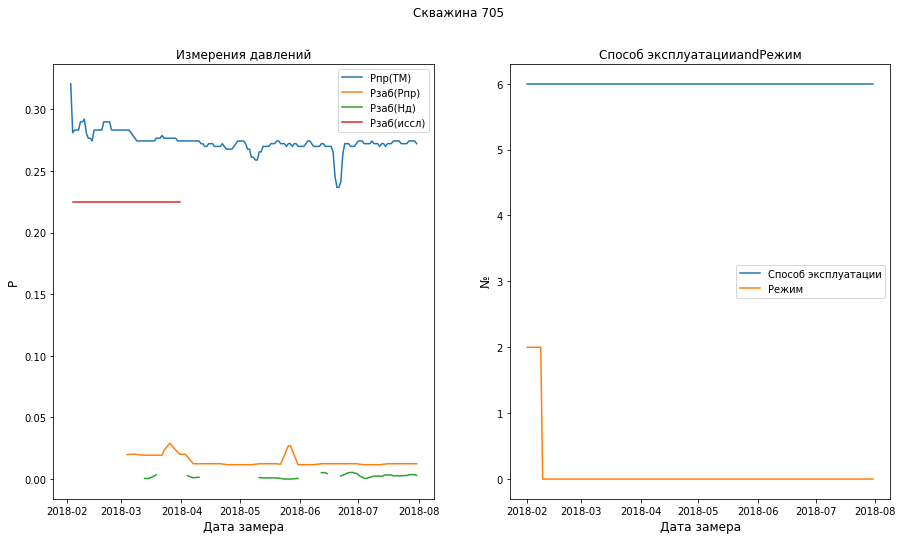

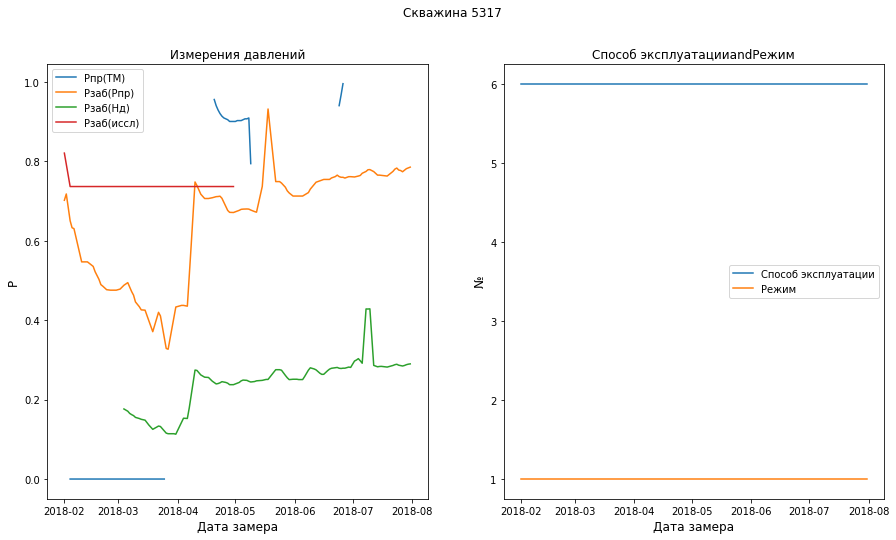

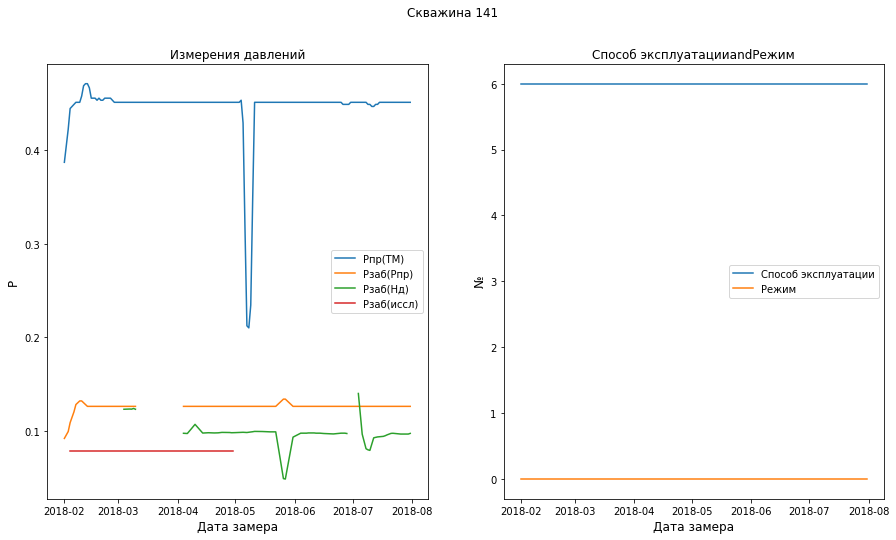

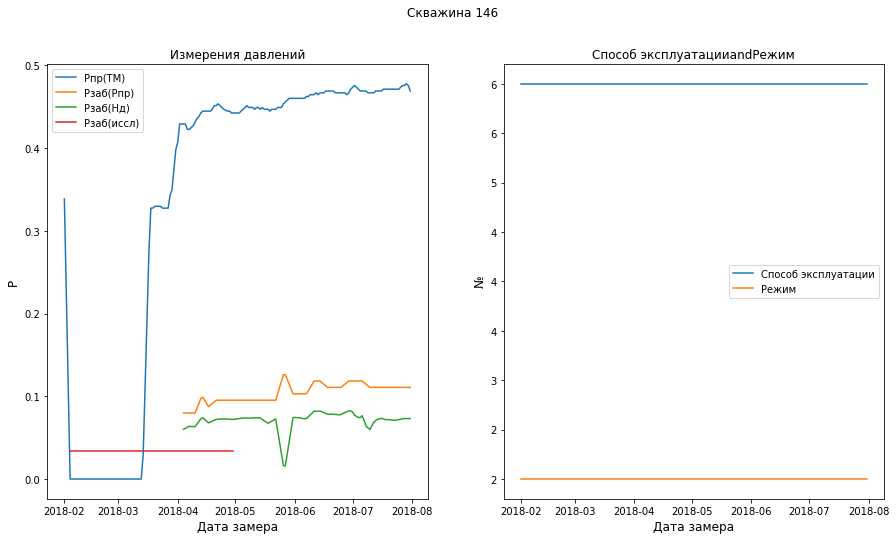

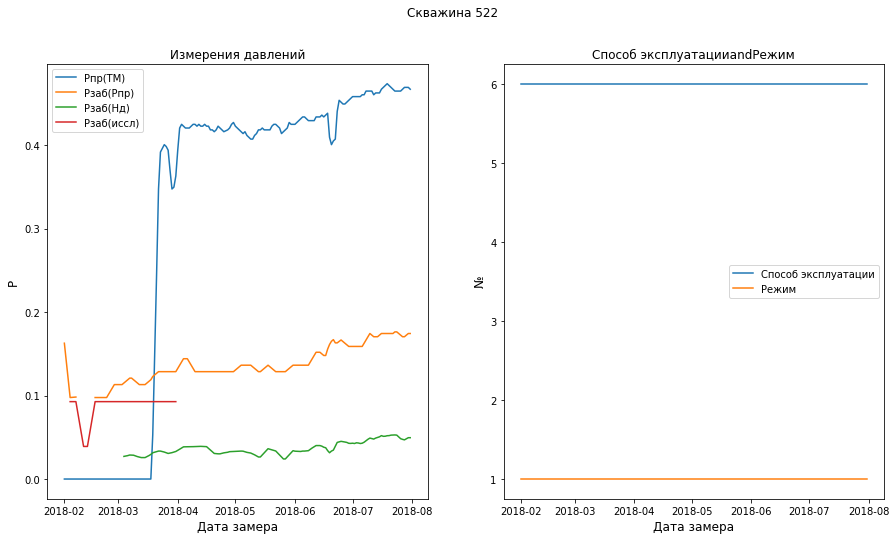

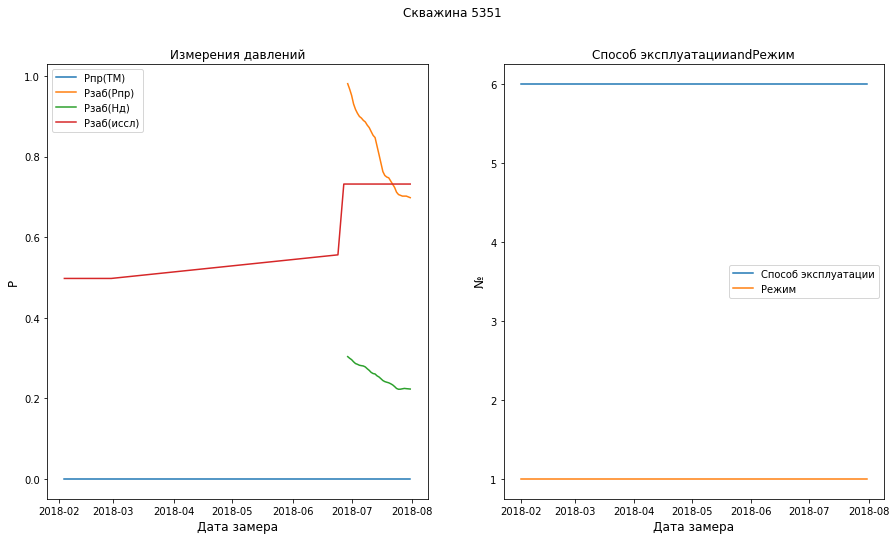

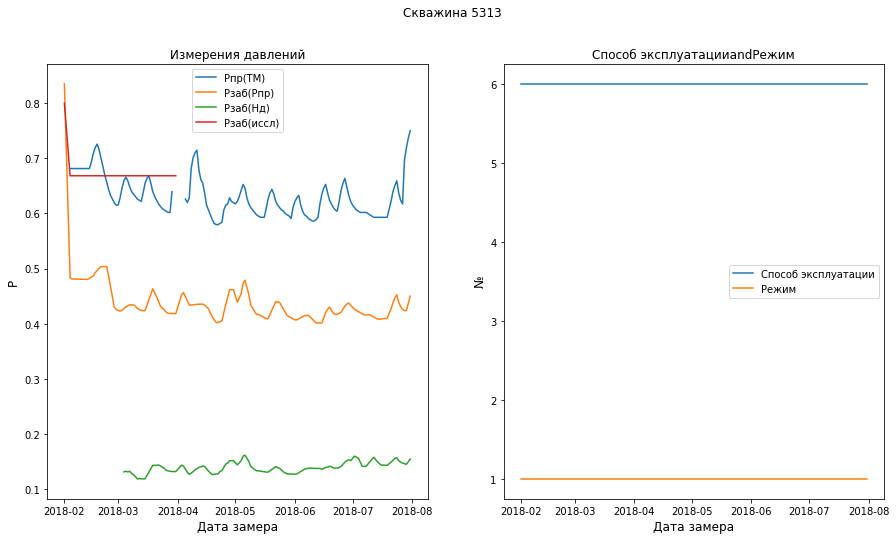

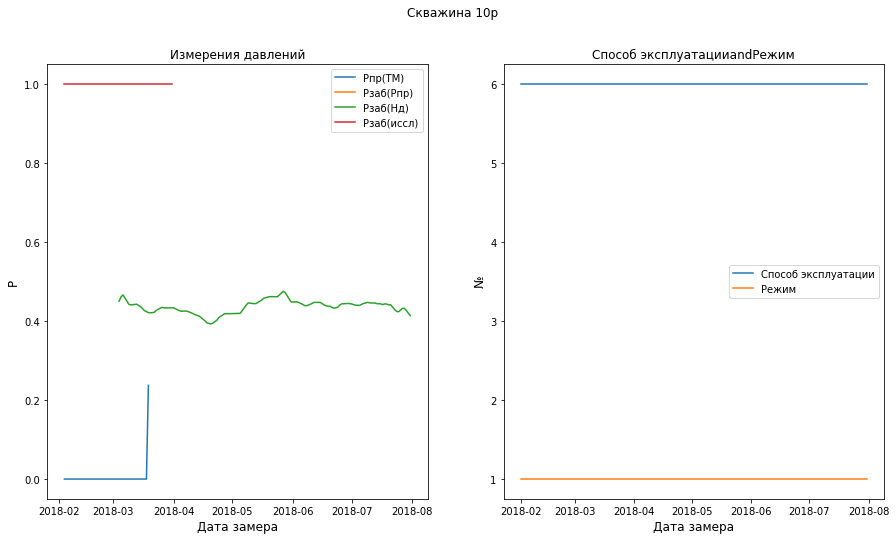

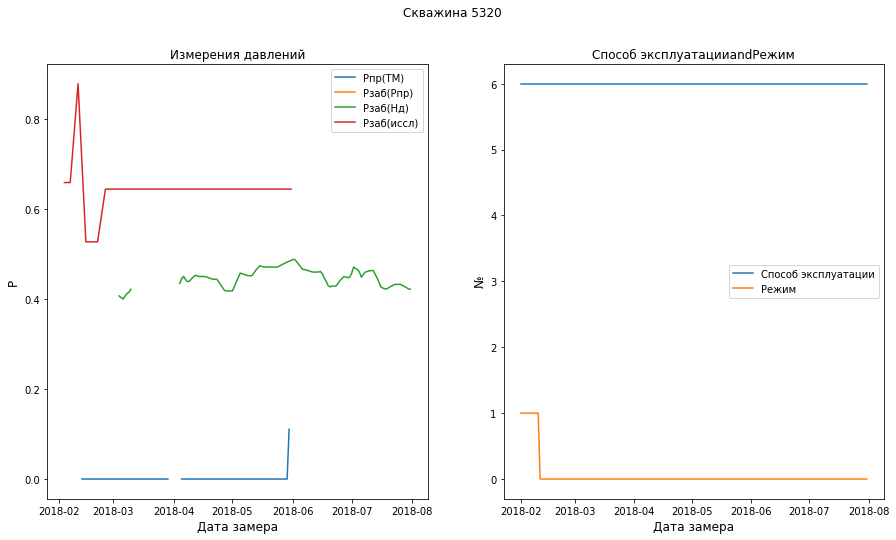

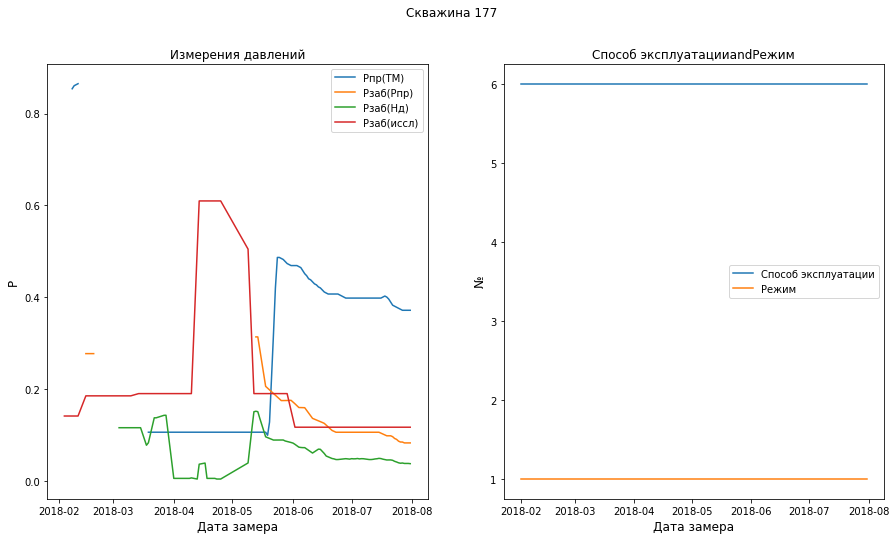

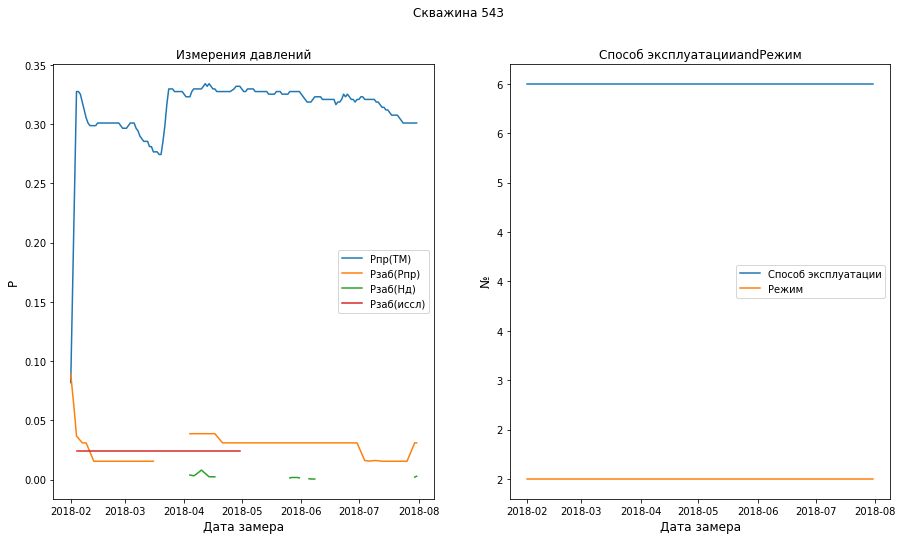

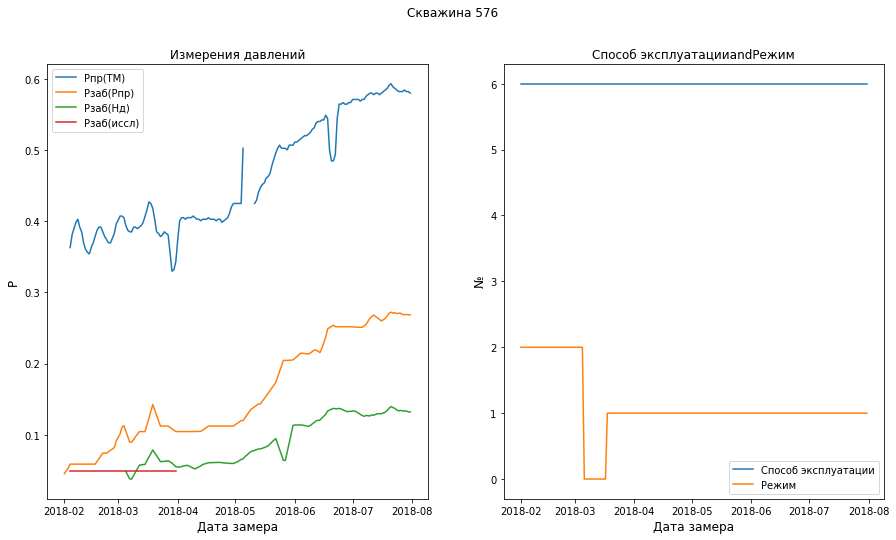

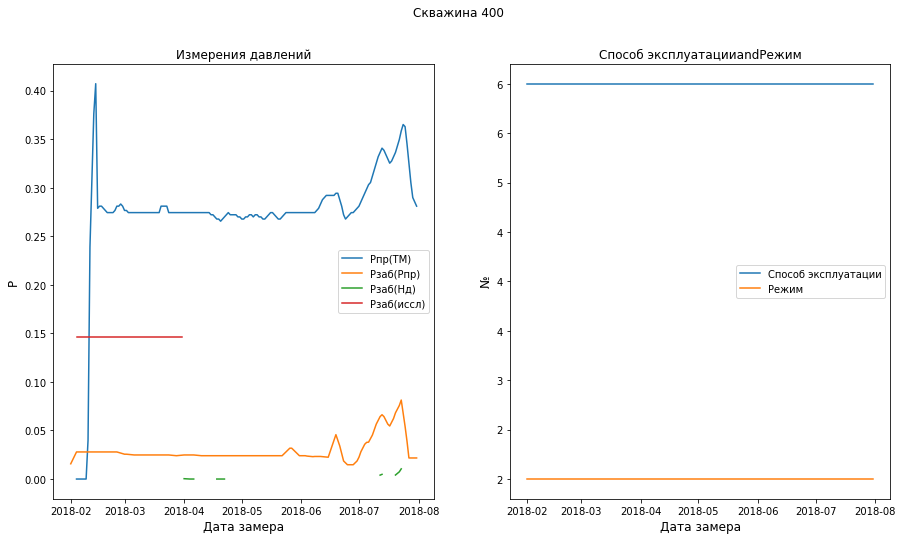

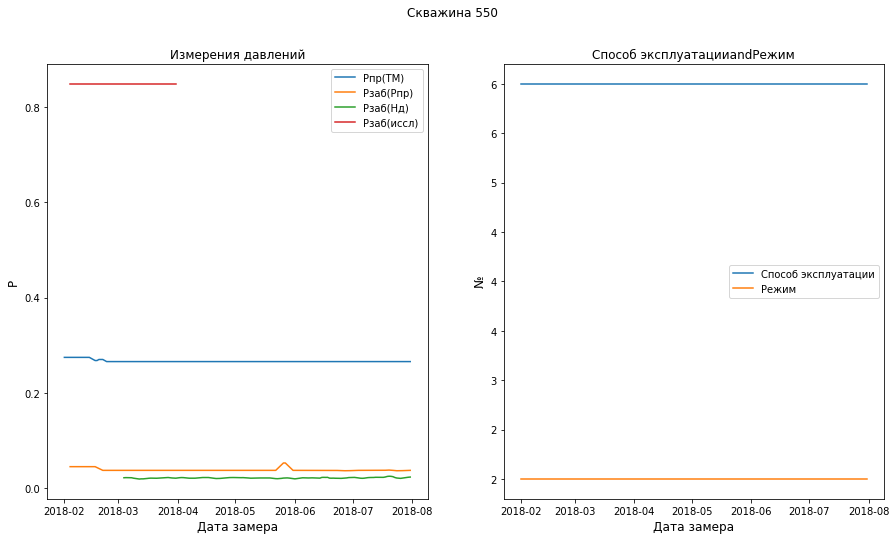

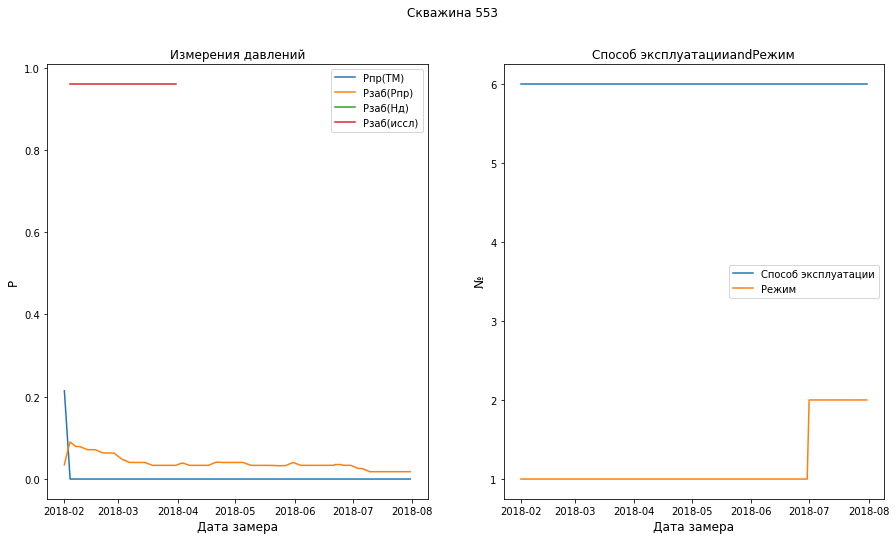

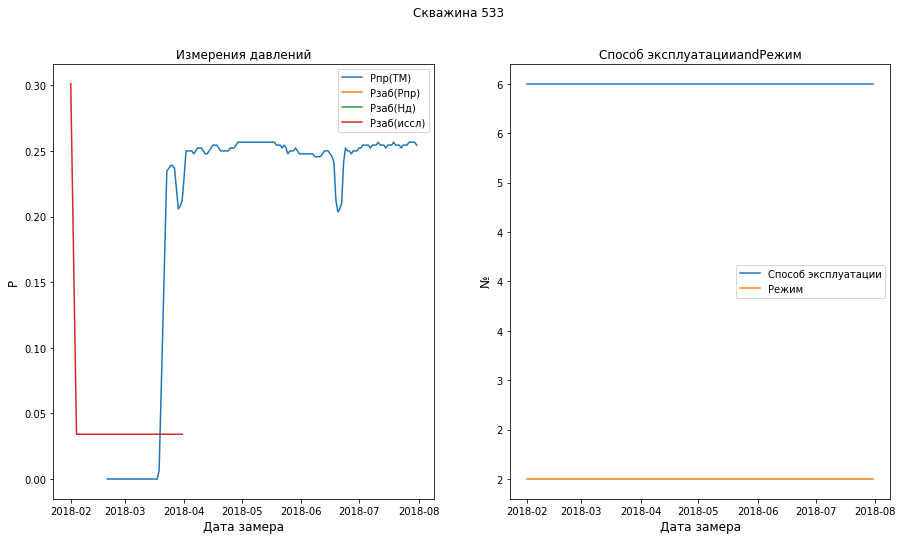

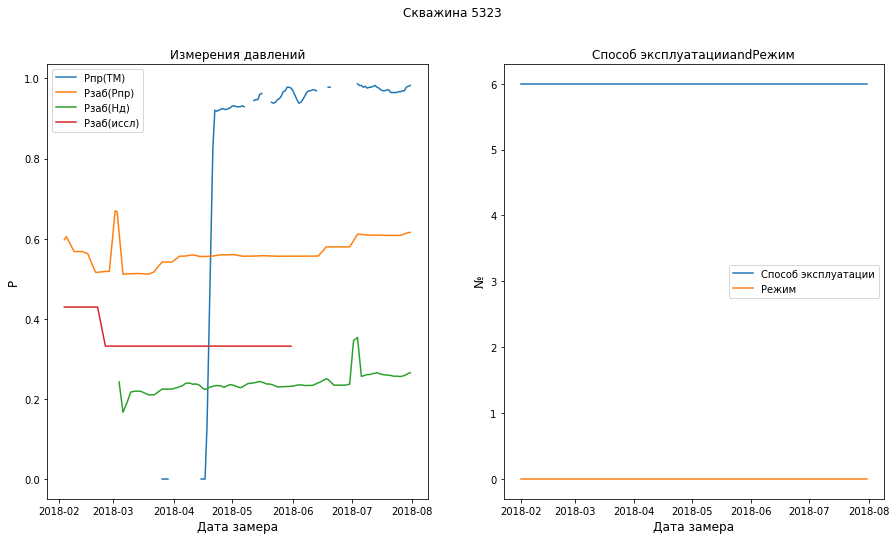

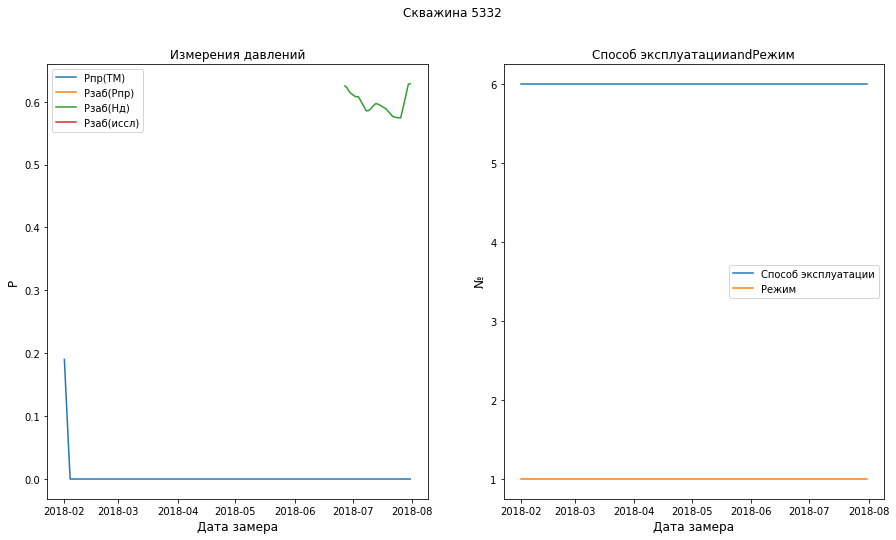

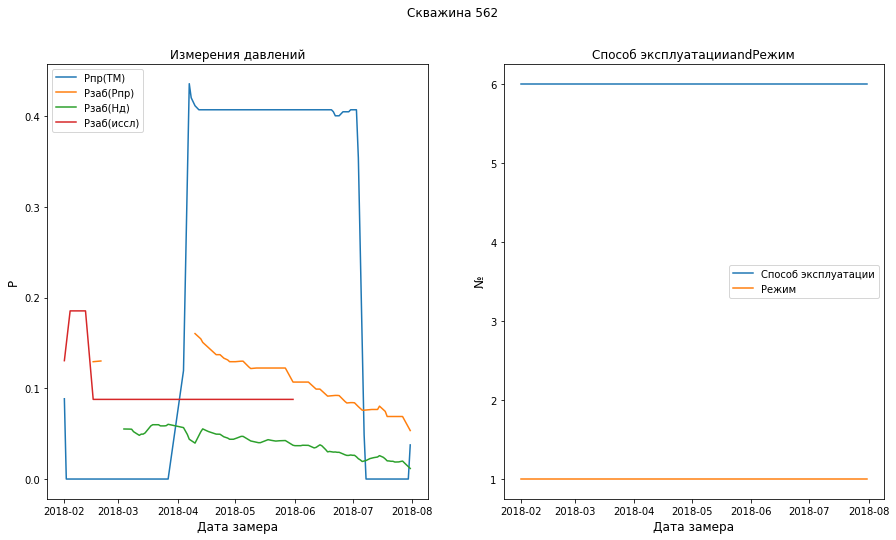

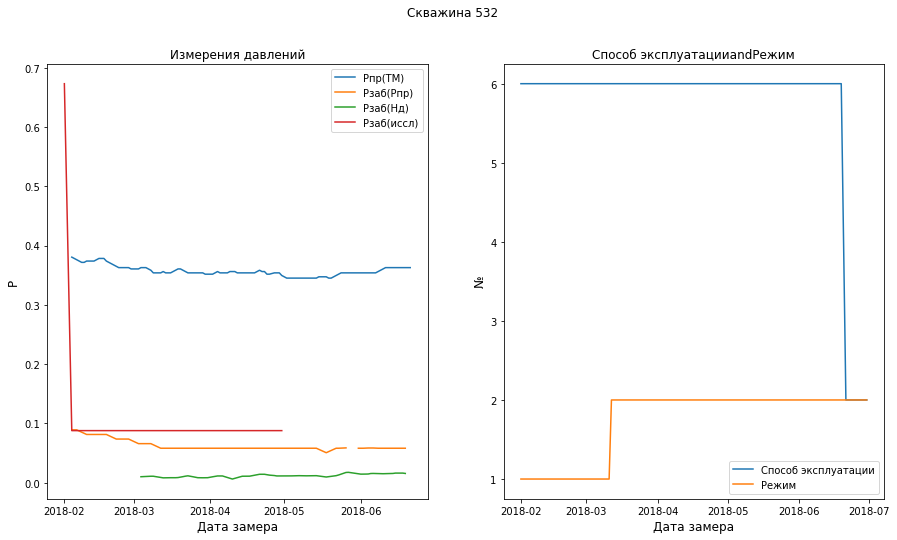

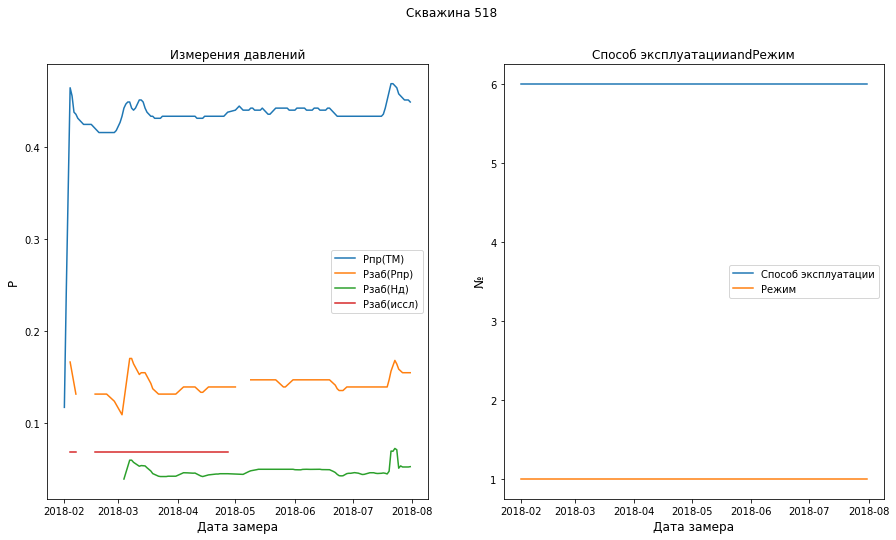

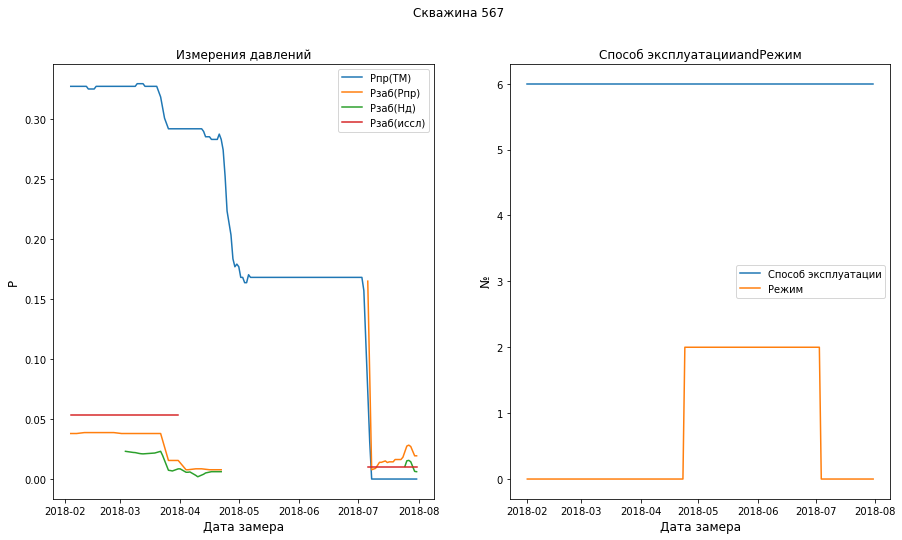

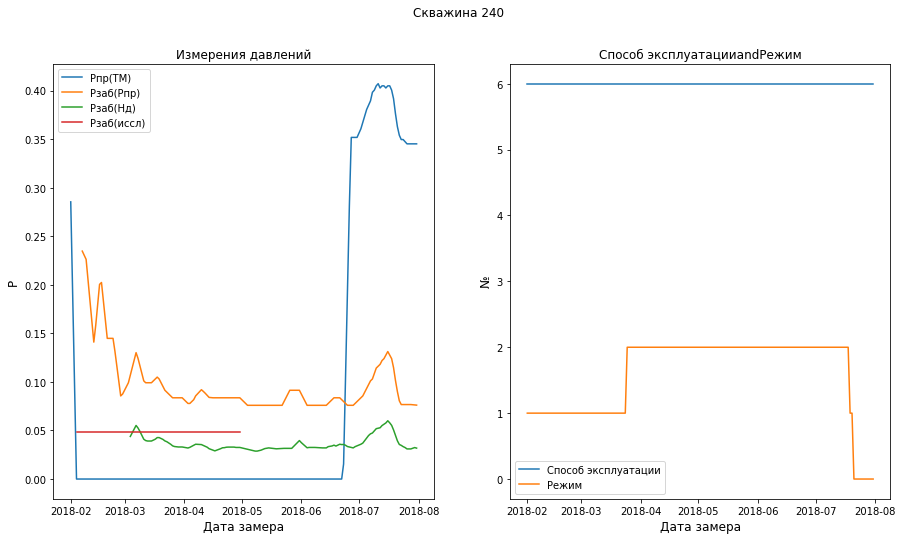

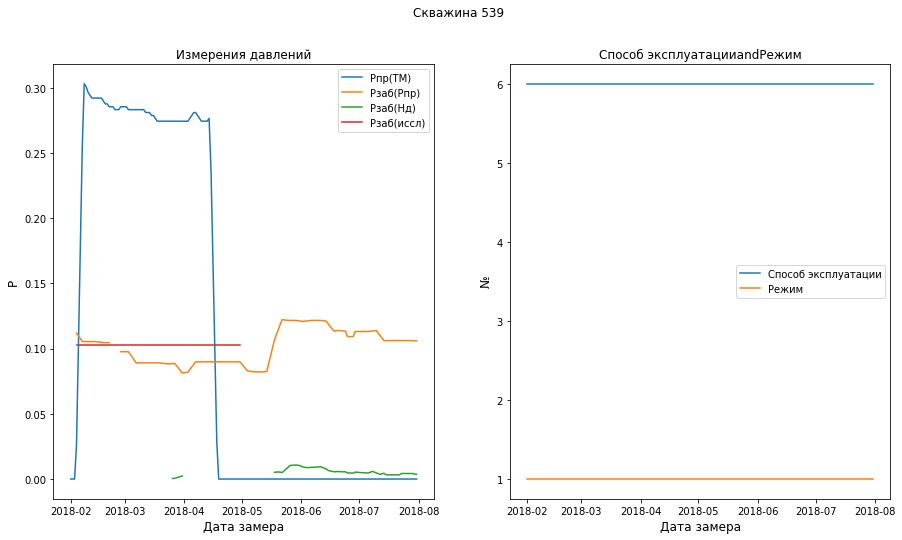

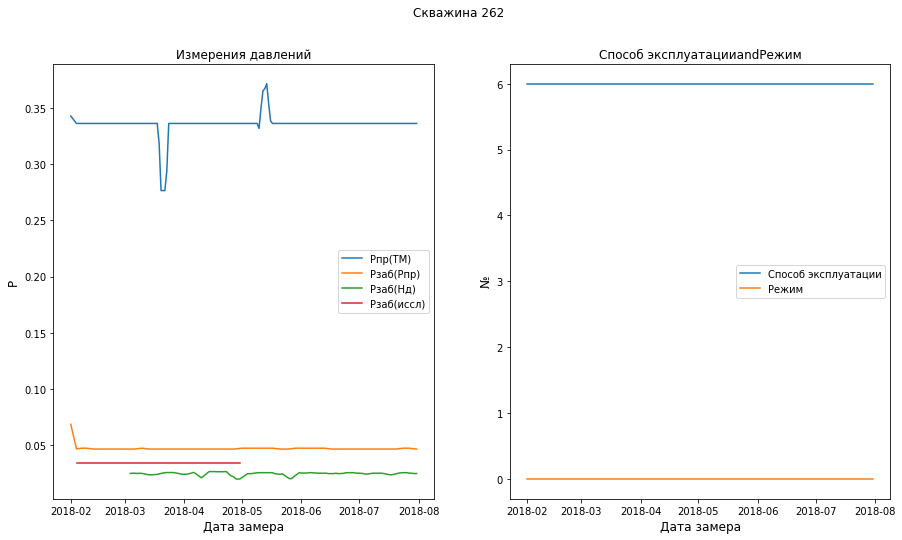

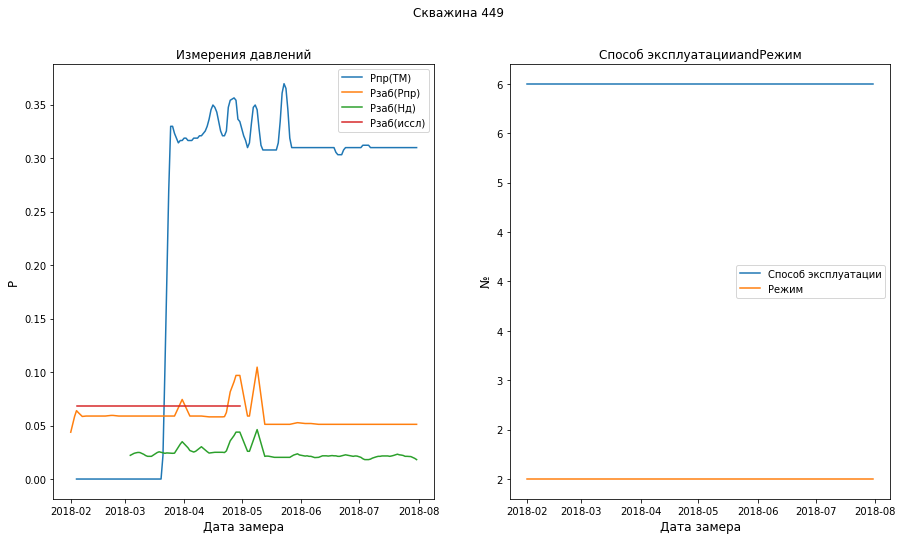

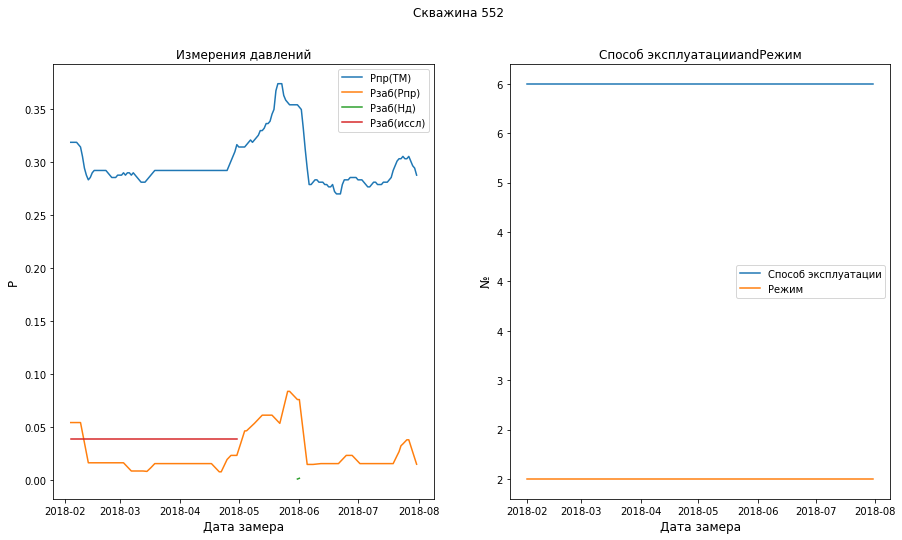

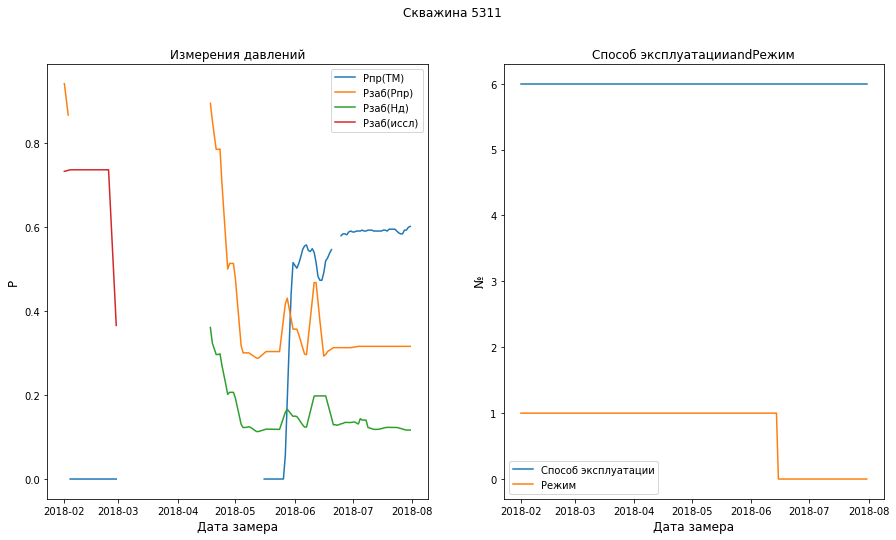

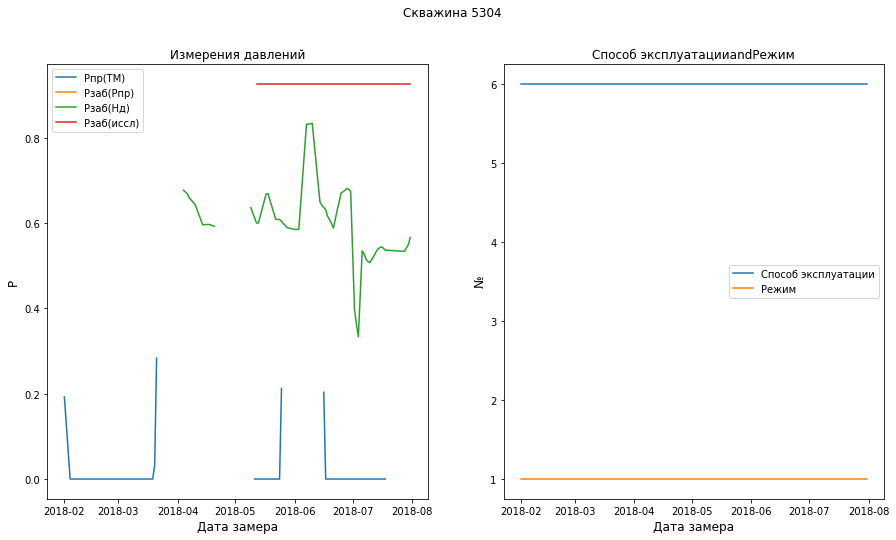

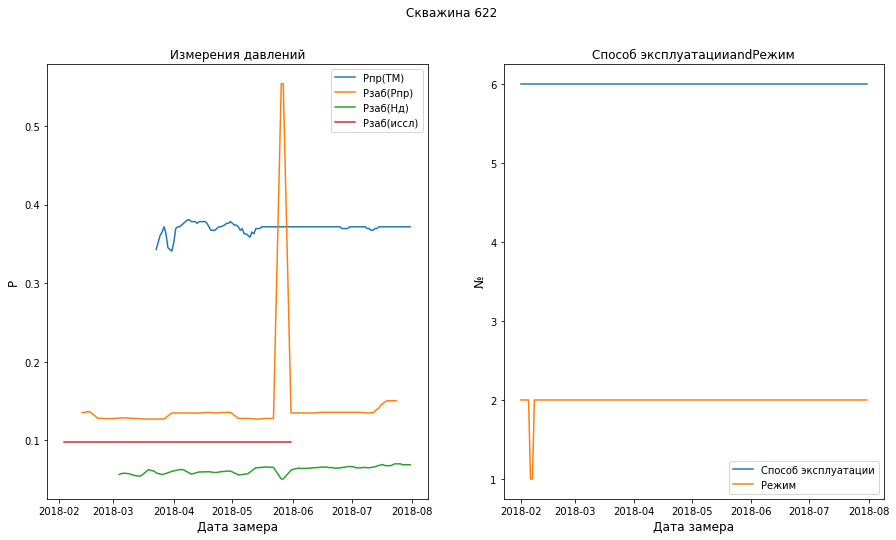

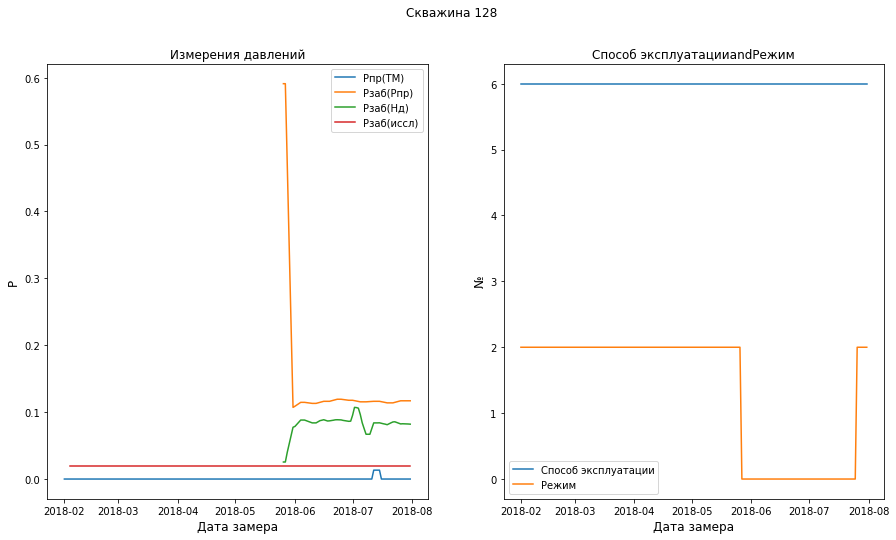

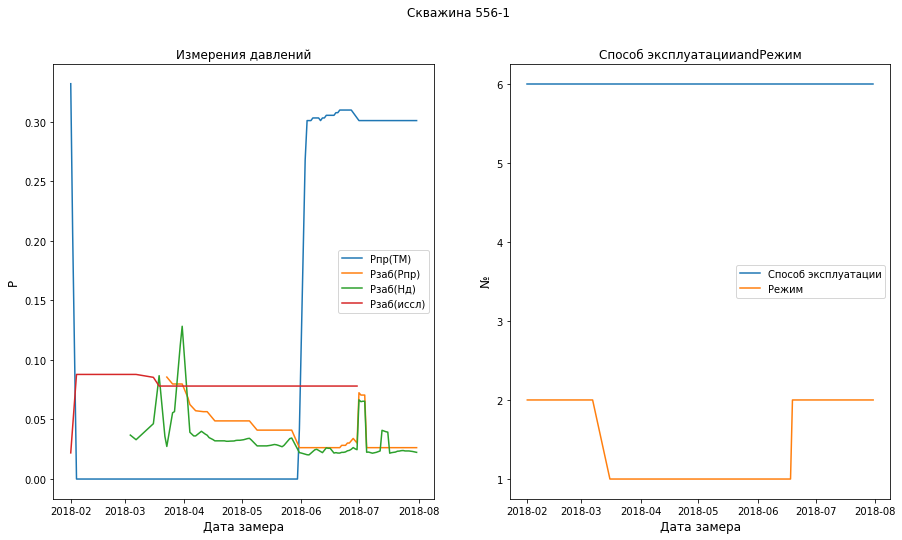

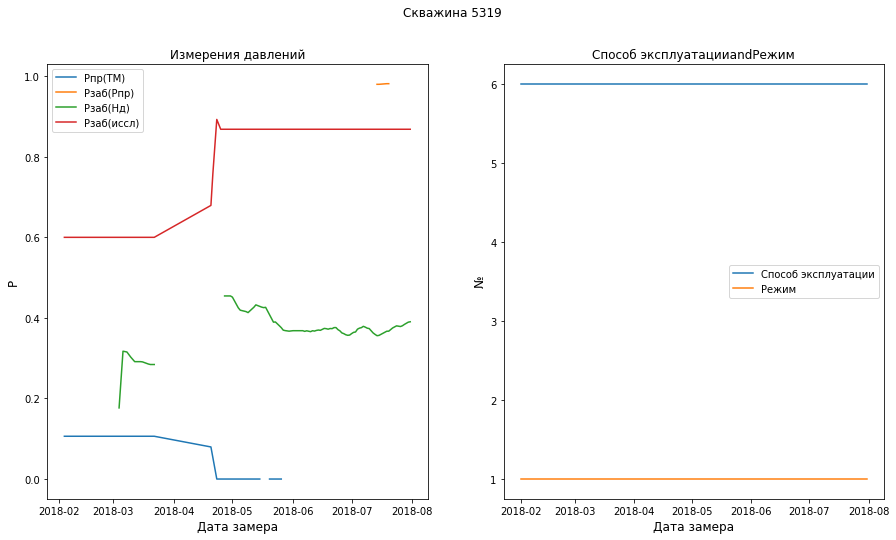

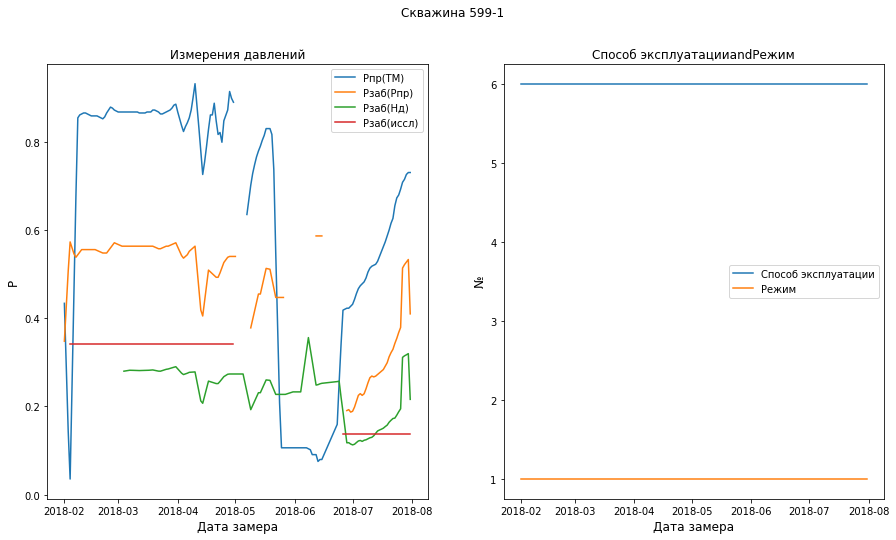

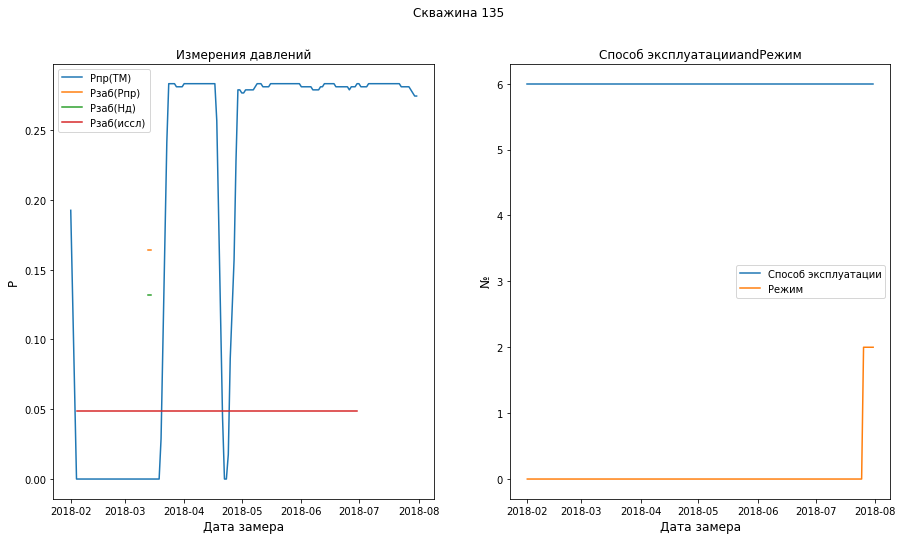

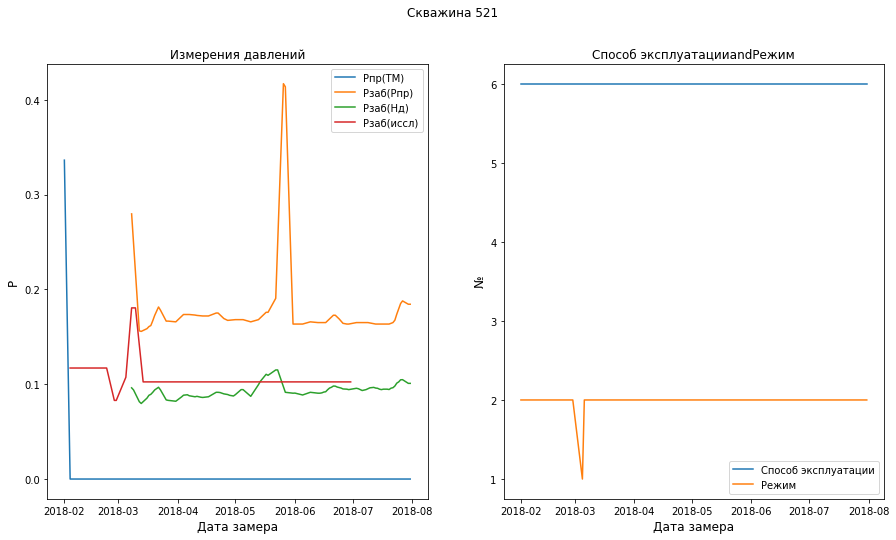

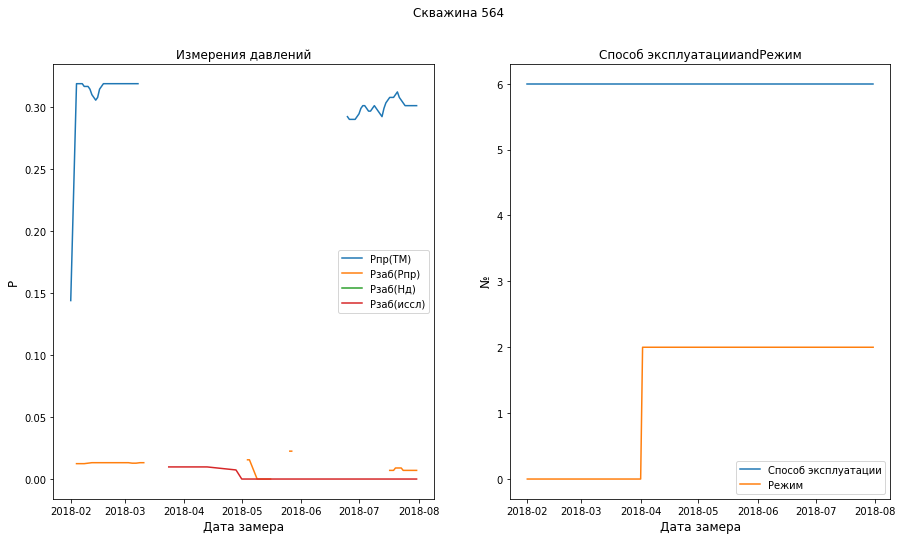

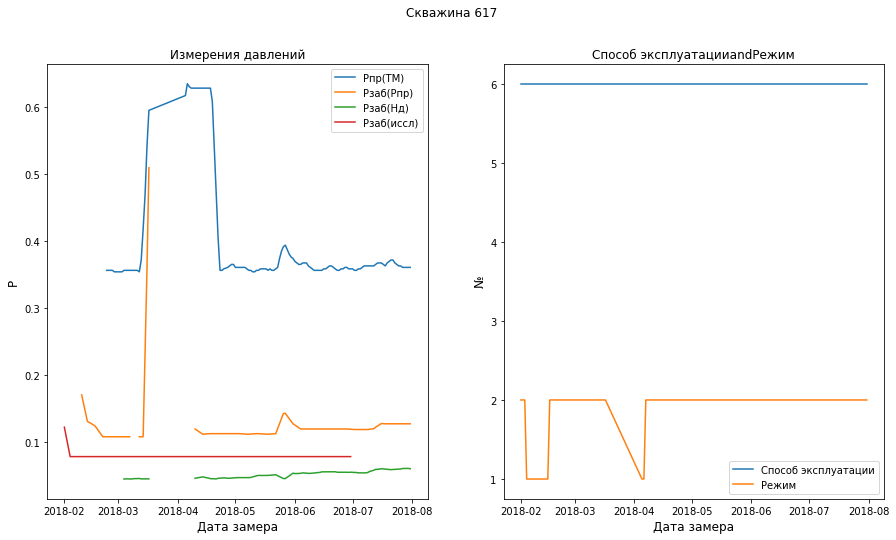

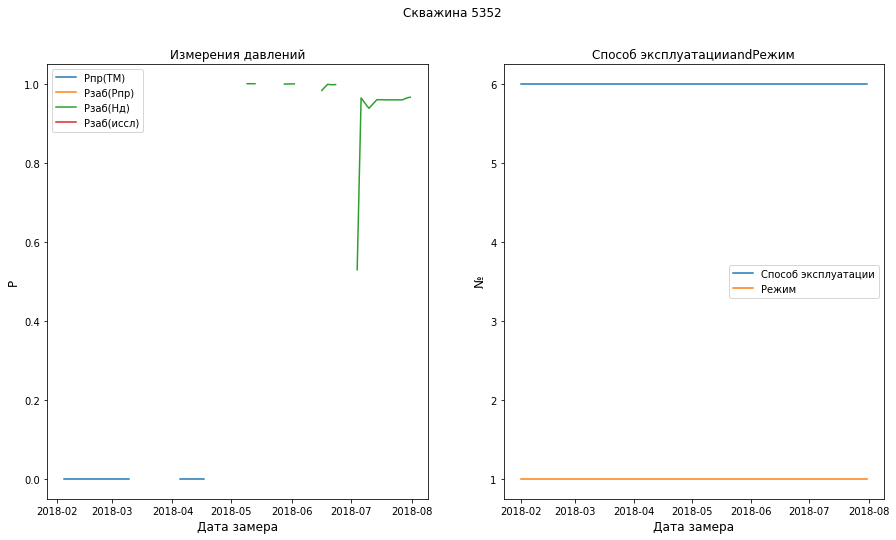

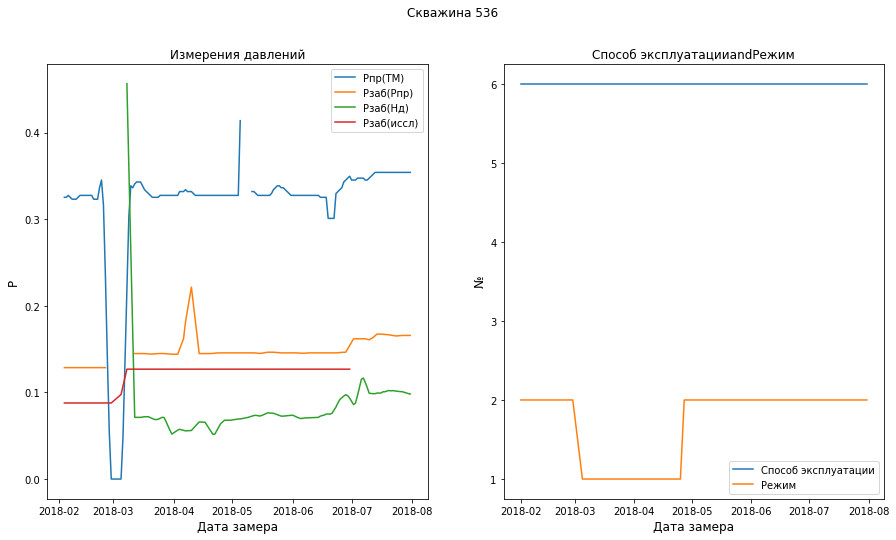

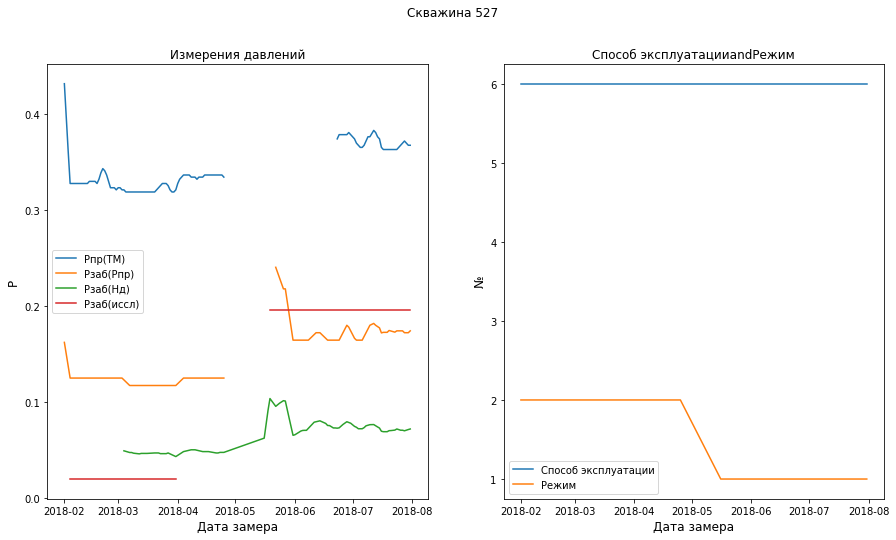

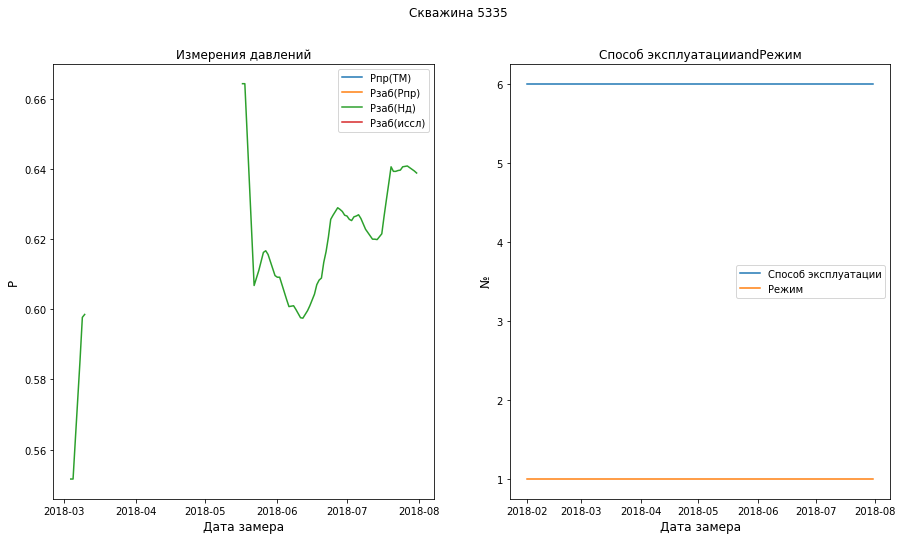

In [67]:
for h in targets.index.unique():
    draw_plot(h, final_roll[final_roll[hole] == h], what_to_do = 'save') 

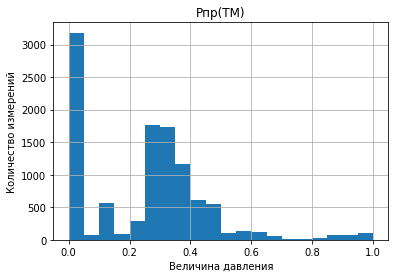

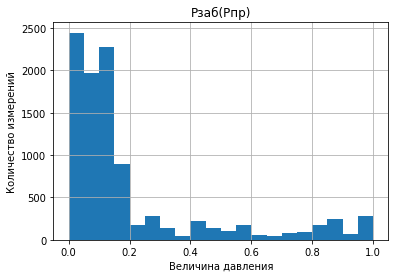

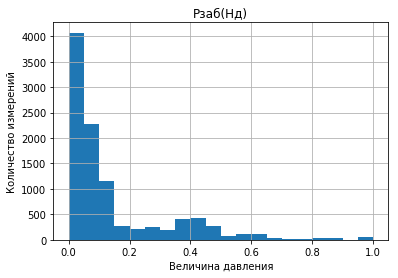

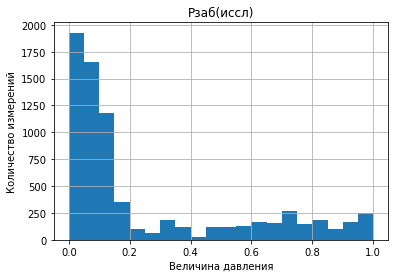

In [68]:
print_hist(final)

In [78]:
def most_freq_val_pres(df):
    most_freq = []
    for p in Y:
        val = df[p].mode()[0]
        most_freq.append(val)
        print('Даты с наиболее частовстречаемыми давлениями для ' + p + ':')
        dates = df[df[p] == val].index
        dates = dates.unique()
        print(dates)
    return most_freq

In [79]:
most_freq = most_freq_val_pres(final_roll)

Даты с наиболее частовстречаемыми давлениями для Рпр(ТМ):
DatetimeIndex(['2018-02-04', '2018-02-05', '2018-02-06', '2018-02-07',
               '2018-02-08', '2018-02-09', '2018-02-10', '2018-02-11',
               '2018-02-12', '2018-02-13',
               ...
               '2018-05-15', '2018-05-16', '2018-05-17', '2018-05-18',
               '2018-05-19', '2018-05-20', '2018-05-21', '2018-07-12',
               '2018-07-13', '2018-04-26'],
              dtype='datetime64[ns]', name='Дата замера', length=181, freq=None)
Даты с наиболее частовстречаемыми давлениями для Рзаб(Рпр):
DatetimeIndex(['2018-02-12', '2018-02-13', '2018-02-14', '2018-02-15',
               '2018-02-16', '2018-02-17', '2018-02-18', '2018-02-19',
               '2018-02-20', '2018-02-21',
               ...
               '2018-07-04', '2018-07-05', '2018-07-06', '2018-07-07',
               '2018-07-08', '2018-07-09', '2018-07-10', '2018-07-11',
               '2018-07-12', '2018-07-13'],
              dtype='

In [82]:
for i in range(4):
    p = most_freq[i]
    y = Y[i]
    first = final_roll[final_roll[y] == p][x1].mode()[0]
    second = final_roll[final_roll[y] == p][x2].mode()[0]
    print(cats_x1[first], cats_x2[second])

Электропогружным насосом ПДФ
Электропогружным насосом ПКВ
Электропогружным насосом ПДФ
Электропогружным насосом АПВ


Электропогружным насосом   АПВ


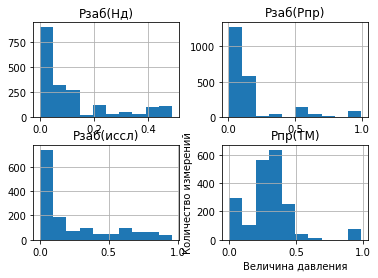

Электропогружным насосом   ПДФ


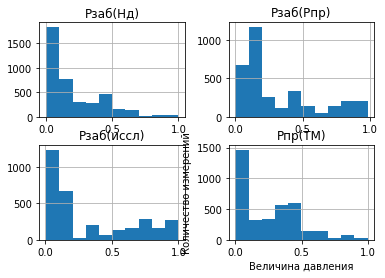

Электропогружным насосом   ПКВ


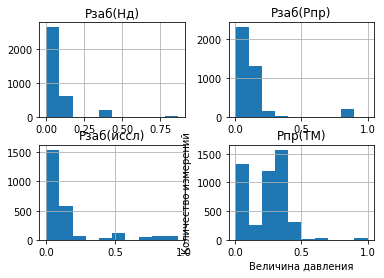

In [29]:
for xF in range(cats_x1.codes.max()  + 1):
    for xS in range(cats_x2.codes.max()  + 1):
        tmp = final_roll.loc[(final_roll[x1] == xF) & (final_roll[x2] == xS)]
        #tmp.groupby(pd.cut(tmp[y1], np.arange(0, 1.1, 0.1)))[y1].count().hist()
        if tmp.count()[0] > 50:
            print(cats_x1.categories[xF],' ',cats_x2.categories[xS])
            tmp[Y].hist(bins = 10)
            plt.xlabel('Величина давления')
            plt.ylabel('Количество измерений')
            plt.show()